In [ ]:
# Download the libraries if you don't have
!pip install nltk
!pip install textblob
!pip install wordcloud
!pip install demoji
!pip install transformers
!pip install tensorflow
!pip install sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Basic Libraries 
# --------------------------------------
import numpy as np
import pandas as pd
import seaborn as sns
# import os
import re
import sys
import demoji
import json
import string
from collections import Counter

# Plot library 
# --------------------------------------
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import plotly.io as pio


# NLP
# --------------------------------------
import nltk
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.stem import WordNetLemmatizer
from textblob import Word, TextBlob
from wordcloud import WordCloud, STOPWORDS  # visualization of words
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline


# Metrics 
# --------------------------------------
from sklearn.model_selection import cross_val_score, GridSearchCV, cross_validate, train_test_split
from sklearn.preprocessing import LabelEncoder


# Tensorflow
import tensorflow as tf


# Torch & BERT
# --------------------------------------
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
from torch.utils.data import TensorDataset, DataLoader
from transformers import BertTokenizer, TFBertForSequenceClassification, TFXLNetModel, XLNetTokenizer
from transformers import BertModel, InputExample, InputFeatures


# Machine Learning Models 
# --------------------------------------
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import plot_confusion_matrix
from sklearn import metrics


# Customize to Remove Warnings and Better Observation 
# --------------------------------------------------------
from warnings import filterwarnings
filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 200)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [ ]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('vader_lexicon')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In this notebook we will perform sentiment analysis on tweets about COVID-19 vaccines

# 1. Load the data

In [ ]:
raw_dataset = pd.read_csv("vax_tweets_sentiment.csv")
raw_dataset.head()

Unnamed: 0                   id             user_name              user_location                                   user_description         user_created user_followers user_friends  \
0          0  1340539111971516416            Rachel Roh  La Crescenta-Montrose, CA  Aggregator of Asian American news; scanning di...  2009-04-08 17:52:46            405         1692   
1          1  1338158543359250433           Albert Fong          San Francisco, CA  Marketing dude, tech geek, heavy metal & '80s ...  2009-09-21 15:27:30            834          666   
2          2  1337858199140118533              eli🇱🇹🇪🇺👌                   Your Bed                                     heil, hydra 🖐☺  2020-06-25 23:30:28             10           88   
3          3  1337855739918835717         Charles Adler     Vancouver, BC - Canada  Hosting "CharlesAdlerTonight" Global News Radi...  2008-09-10 11:28:53          49165         3933   
4          4  1337854064604966912  Citizen News Channel                        NaN  Citizen News Channel bringing you an alternati...  2020-04-23 17:58:42            152          580   

  user_favourites user_verified        date                                               text                                           hashtags               source retweets  favorites is_retweet  \
0            3247         False  2020-12-20  Same folks said daikon paste could treat a cyt...                                 ['PfizerBioNTech']  Twitter for Android        0       0.00      False   
1             178         False  2020-12-13  While the world has been on the wrong side of ...                                                NaN      Twitter Web App        1       1.00      False   
2             155         False  2020-12-12        Russian vaccine is created to last 2-4 y...  ['coronavirus', 'SputnikV', 'AstraZeneca', 'Pf...  Twitter for Android        0       0.00      False   
3           21853          True  2020-12-12  Facts are immutable, Senator, even when you're...                                                NaN      Twitter Web App      446    2129.00      False   
4            1473         False  2020-12-12     Explain to me again why we need a vaccine          ['whereareallthesickpeople', 'PfizerBioNTech']   Twitter for iPhone        0       0.00      False   

  sentiment                                          orig_text  
0   neutral  Same folks said daikon paste could treat a cyt...  
1  positive  While the world has been on the wrong side of ...  
2   neutral  #coronavirus #SputnikV #AstraZeneca #PfizerBio...  
3   neutral  Facts are immutable, Senator, even when you're...  
4   neutral  Explain to me again why we need a vaccine @Bor...

## 1.1 Explore the data

In [ ]:
raw_dataset.shape

(29452, 19)

In [ ]:
raw_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29452 entries, 0 to 29451
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        29452 non-null  object 
 1   id                29449 non-null  object 
 2   user_name         29449 non-null  object 
 3   user_location     22599 non-null  object 
 4   user_description  27389 non-null  object 
 5   user_created      29448 non-null  object 
 6   user_followers    29448 non-null  object 
 7   user_friends      29448 non-null  object 
 8   user_favourites   29447 non-null  object 
 9   user_verified     29447 non-null  object 
 10  date              29447 non-null  object 
 11  text              29447 non-null  object 
 12  hashtags          23239 non-null  object 
 13  source            29424 non-null  object 
 14  retweets          29446 non-null  object 
 15  favorites         29445 non-null  float64
 16  is_retweet        29445 non-null  object

In [ ]:
raw_dataset = raw_dataset.drop(['id'], axis=1)

In [ ]:
raw_dataset.head()

Unnamed: 0             user_name              user_location                                   user_description         user_created user_followers user_friends user_favourites user_verified  \
0          0            Rachel Roh  La Crescenta-Montrose, CA  Aggregator of Asian American news; scanning di...  2009-04-08 17:52:46            405         1692            3247         False   
1          1           Albert Fong          San Francisco, CA  Marketing dude, tech geek, heavy metal & '80s ...  2009-09-21 15:27:30            834          666             178         False   
2          2              eli🇱🇹🇪🇺👌                   Your Bed                                     heil, hydra 🖐☺  2020-06-25 23:30:28             10           88             155         False   
3          3         Charles Adler     Vancouver, BC - Canada  Hosting "CharlesAdlerTonight" Global News Radi...  2008-09-10 11:28:53          49165         3933           21853          True   
4          4  Citizen News Channel                        NaN  Citizen News Channel bringing you an alternati...  2020-04-23 17:58:42            152          580            1473         False   

         date                                               text                                           hashtags               source retweets  favorites is_retweet sentiment  \
0  2020-12-20  Same folks said daikon paste could treat a cyt...                                 ['PfizerBioNTech']  Twitter for Android        0       0.00      False   neutral   
1  2020-12-13  While the world has been on the wrong side of ...                                                NaN      Twitter Web App        1       1.00      False  positive   
2  2020-12-12        Russian vaccine is created to last 2-4 y...  ['coronavirus', 'SputnikV', 'AstraZeneca', 'Pf...  Twitter for Android        0       0.00      False   neutral   
3  2020-12-12  Facts are immutable, Senator, even when you're...                                                NaN      Twitter Web App      446    2129.00      False   neutral   
4  2020-12-12     Explain to me again why we need a vaccine          ['whereareallthesickpeople', 'PfizerBioNTech']   Twitter for iPhone        0       0.00      False   neutral   

                                           orig_text  
0  Same folks said daikon paste could treat a cyt...  
1  While the world has been on the wrong side of ...  
2  #coronavirus #SputnikV #AstraZeneca #PfizerBio...  
3  Facts are immutable, Senator, even when you're...  
4  Explain to me again why we need a vaccine @Bor...

In [ ]:
raw_dataset.describe()

favorites
count   29445.00
mean       14.04
std       192.58
min         0.00
25%         0.00
50%         1.00
75%         4.00
max     22815.00

In [ ]:
# check for missing values
raw_dataset.isnull().sum()

Unnamed: 0             0
user_name              3
user_location       6853
user_description    2063
user_created           4
user_followers         4
user_friends           4
user_favourites        5
user_verified          5
date                   5
text                   5
hashtags            6213
source                28
retweets               6
favorites              7
is_retweet             7
sentiment              7
orig_text              7
dtype: int64

In [ ]:
# Function to check the missing data
def missing_data(data):
    total = data.isnull().sum()
    null_percentage = (data.isnull().sum()/data.isnull().count()*100)
    missing_info_data = pd.concat([total, null_percentage], axis=1, keys=['Total', 'Null percentage(%)'])
    types = []
    for col in data.columns:
        dtype = str(data[col].dtype)
        types.append(dtype)
    missing_info_data['Types'] = types
    return(np.transpose(missing_info_data))

In [ ]:
missing_data(raw_dataset)

Unnamed: 0 user_name user_location user_description user_created user_followers user_friends user_favourites user_verified    date    text hashtags  source retweets favorites  \
Total                       0         3          6853             2063            4              4            4               5             5       5       5     6213      28        6         7   
Null percentage(%)       0.00      0.01         23.27             7.00         0.01           0.01         0.01            0.02          0.02    0.02    0.02    21.10    0.10     0.02      0.02   
Types                  object    object        object           object       object         object       object          object        object  object  object   object  object   object   float64   

                   is_retweet sentiment orig_text  
Total                       7         7         7  
Null percentage(%)       0.02      0.02      0.02  
Types                  object    object    object

In [ ]:
raw_dataset.count()

Unnamed: 0          29452
user_name           29449
user_location       22599
user_description    27389
user_created        29448
user_followers      29448
user_friends        29448
user_favourites     29447
user_verified       29447
date                29447
text                29447
hashtags            23239
source              29424
retweets            29446
favorites           29445
is_retweet          29445
sentiment           29445
orig_text           29445
dtype: int64

In [ ]:
# Function to check the unique values in each column
def unique_values(data):
    total = data.count()
    unique_info_data = pd.DataFrame(total)
    unique_info_data.columns = ['Total']
    uniques = []
    types = []
    
    for col in data.columns:
        unique = data[col].nunique()
        uniques.append(unique)
        
        dtype = str(data[col].dtype)
        types.append(dtype)
        
    unique_info_data['Uniques'] = uniques
    unique_info_data['Types'] = types
    return(np.transpose(unique_info_data))

In [ ]:
unique_values(raw_dataset)

Unnamed: 0 user_name user_location user_description user_created user_followers user_friends user_favourites user_verified    date    text hashtags  source retweets favorites is_retweet  \
Total        29452     29449         22599            27389        29448          29448        29448           29447         29447   29447   29447    23239   29424    29446     29445      29445   
Uniques      29451     16813          6399            15982        16956           7303         4271           11909             3      96   27767    11336     136      209       403          1   
Types       object    object        object           object       object         object       object          object        object  object  object   object  object   object   float64     object   

        sentiment orig_text  
Total       29445     29445  
Uniques         3     29419  
Types      object    object

In [ ]:
# Function to check the most frequent values in the dataset
def most_frequent_values(data):
    total = data.count()
    most_frequent_info_data = pd.DataFrame(total)
    most_frequent_info_data.columns = ['Total']
    items = []
    vals = []
    for col in data.columns:
        item = data[col].value_counts().index[0]
        val = data[col].value_counts().values[0]
        items.append(item)
        vals.append(val)
    most_frequent_info_data['Most frequent item'] = items
    most_frequent_info_data['Frequence'] = vals
    most_frequent_info_data['Percent from total'] = np.round(vals / total * 100, 3)
    return(np.transpose(most_frequent_info_data))

In [ ]:
most_frequent_values(raw_dataset)

Unnamed: 0          user_name user_location                                   user_description         user_created user_followers user_friends user_favourites user_verified  \
Total                   29452              29449         22599                                              27389                29448          29448        29448           29447         29447   
Most frequent item     doses   Workout Solutions         India  George Tsanis – Workout Solutions Health and F...  2010-09-20 17:01:08              0            0               0         False   
Frequence                   2                263           883                                                263                  263            252          257             410         25903   
Percent from total       0.01               0.89          3.91                                               0.96                 0.89           0.86         0.87            1.39         87.97   

                          date      text     hashtags           source retweets favorites is_retweet sentiment                                          orig_text  
Total                    29447     29447        23239            29424    29446     29445      29445     29445                                              29445  
Most frequent item  2021-03-01            ['Covaxin']  Twitter Web App        0      0.00      False   neutral  #Covid19 Vaccine Rollout Needs Spark Even More...  
Frequence                 2911        59         1367             9581    18201     11953      29445     18566                                                  5  
Percent from total        9.89      0.20         5.88            32.56    61.81     40.59     100.00     63.05                                               0.02

In [ ]:
# Function to plot the count of values in each columns 
def plot_count(feature, title, df, size=1, ordered=True):
    fig, ax = plt.subplots(1,1, figsize=(4*size,4))
    total = float(len(df))
    if ordered:
        g = sns.countplot(df[feature], order=df[feature].value_counts().index[:20], palette='Set3')
    else:
        g = sns.countplot(df[feature], palette='Set3')
        
    g.set_title("Number and percentage of {}".format(title))
    
    if(size > 2):
        plt.xticks(rotation=90, size=8)
        
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x()+p.get_width()/2., height, '{:1.2f}%'.format(100*height/total), ha="center") 
    plt.show()

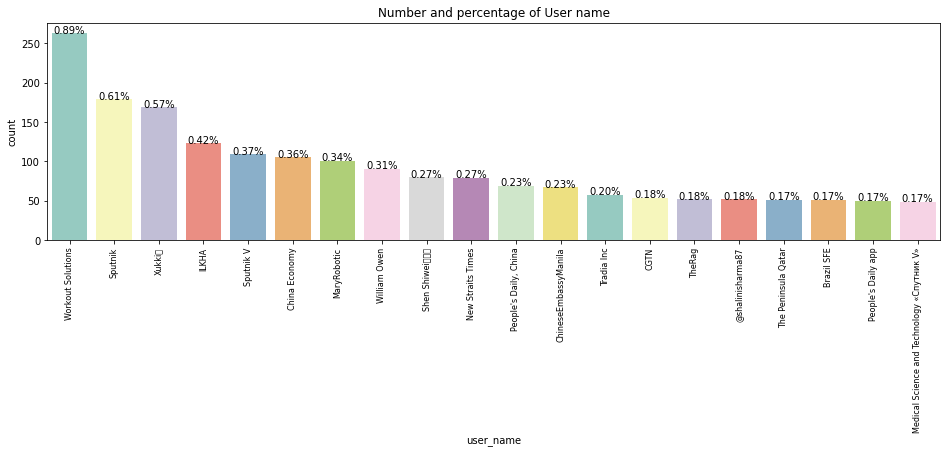

In [ ]:
plot_count("user_name", "User name", raw_dataset, 4)

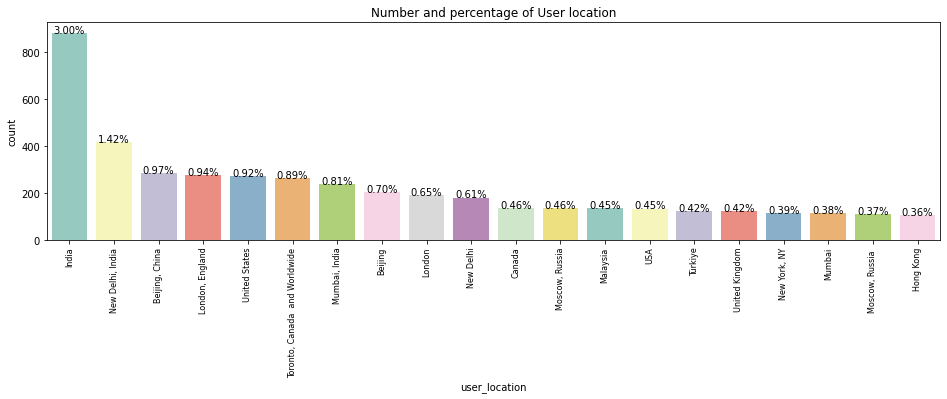

In [ ]:
plot_count("user_location", "User location", raw_dataset, 4)

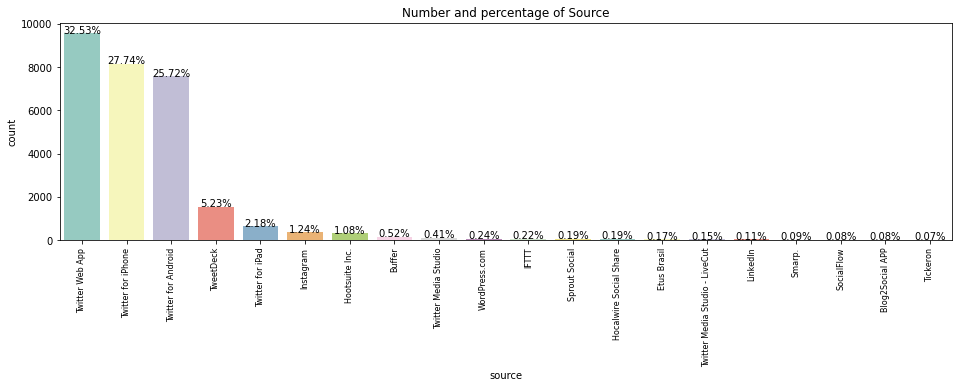

In [ ]:
plot_count("source", "Source", raw_dataset, 4)

In [ ]:
# Function to print the wordcloud
def show_wordcloud(data, title=""):
    text = " ".join(t for t in data.dropna())
    stopwords = set(STOPWORDS)
    stopwords.update(["t", "co", "https", "amp", "U"])
    wordcloud = WordCloud(stopwords=stopwords, scale=4, max_font_size=50, max_words=500,background_color="white").generate(text)
    fig = plt.figure(1, figsize=(16,16))
    plt.axis('off')
    fig.suptitle(title, fontsize=20)
    fig.subplots_adjust(top=2.3)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.show()

### Prevalent words in tweet texts

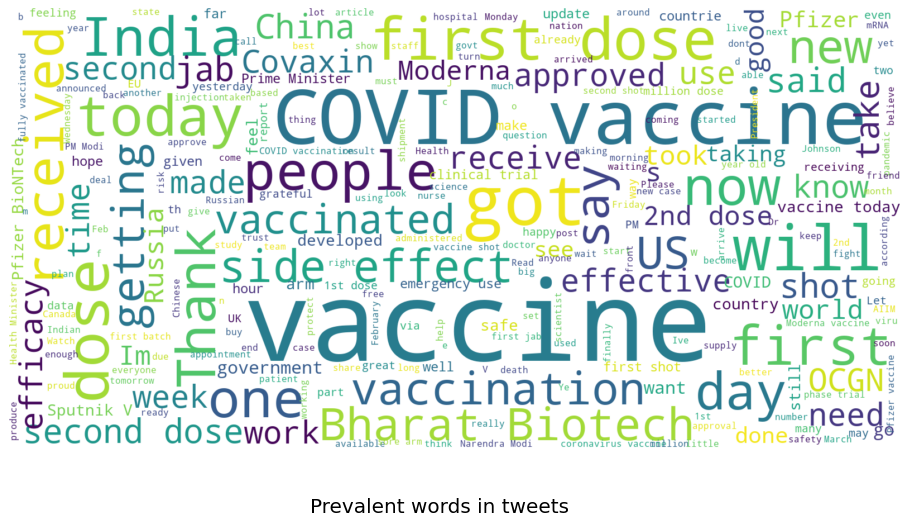

In [ ]:
show_wordcloud(raw_dataset['text'], title = 'Prevalent words in tweets')

# 2. Data Cleaning

In [ ]:
# get the mapping of emojis and its meaning
def get_emojis(s):
  emoji_map.update(demoji.findall(s))  

In [ ]:
# df.text.apply(get_emojis)
# with open("emoji_mapping.json", "w") as outfile:
#     json.dump(emoji_map, outfile)
  
with open("emoji_mapping.json", "r") as infile:
    emoji_map = json.load(infile)

In [ ]:
def tweets_cleaning(df, text_col="text", emoji_map={}):
  
  # demojify
  def replace_emoji(s):
    # print(s)
    if s is None:
      return ""
    if s is np.nan:
      return ""
    for word, replacement in emoji_map.items():
      s = s.replace(word, " "+replacement+" ")
    return s

  df["original_text"] = df[text_col].copy()
  df[text_col] = df[text_col].apply(replace_emoji)


  # Remove twitter handles
  df[text_col] = df[text_col].apply(lambda x:re.sub('@[^\s]+','',str(x)))
    
  # Remove URLs
  df[text_col] = df[text_col].apply(lambda x:re.sub(r"http\S+", "", str(x)))

  # Remove hashtags
  df[text_col] = df[text_col].apply(lambda x:re.sub(r'\B#\S+','',str(x)))

  # Lower casing
  df[text_col] = df[text_col].str.lower()

  # remove numbers and special characters
  df[text_col] = df[text_col].apply(lambda x : re.sub(r"[^a-zA-Z ]", "", x))

  df = df[df[text_col].apply(lambda x : len(x))>2]
  
  # Remove stopwords
  def remove_stopwords(text):
    STOPWORDS = set(stopwords.words('english'))
    update_words = ['covid','#coronavirus', '#coronavirusoutbreak', '#coronavirusPandemic', 
                    '#covid19', '#covid_19', '#epitwitter', '#ihavecorona', 'amp', 'coronavirus', 'covid19']
    STOPWORDS.update(update_words)
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])

  def lemmatize(text):
    word_list = nltk.word_tokenize(text)
    lemmatized_output = ' '.join([lemmatizer.lemmatize(w) for w in word_list])
    if text!=lemmatized_output:
      print(text,"===",lemmatized_output)
    return lemmatized_output

  
  df[text_col] = df[text_col].apply(lambda text: remove_stopwords(text))

  #df[text_col] = df[text_col].apply(lambda text: lemmatize(text))

  # Single character or double space removal
  df[text_col] = df[text_col].apply(lambda x:re.sub(r'\s+[a-zA-Z]\s+', '', str(x)))
  df[text_col] = df[text_col].apply(lambda x:re.sub(r'\s+', ' ', str(x), flags=re.I))

  return df[df[text_col]!=''] # remove none

In [ ]:
df = tweets_cleaning(raw_dataset, emoji_map=emoji_map)

In [ ]:
df.head()

Unnamed: 0             user_name              user_location                                   user_description         user_created user_followers user_friends user_favourites user_verified  \
0          0            Rachel Roh  La Crescenta-Montrose, CA  Aggregator of Asian American news; scanning di...  2009-04-08 17:52:46            405         1692            3247         False   
1          1           Albert Fong          San Francisco, CA  Marketing dude, tech geek, heavy metal & '80s ...  2009-09-21 15:27:30            834          666             178         False   
2          2              eli🇱🇹🇪🇺👌                   Your Bed                                     heil, hydra 🖐☺  2020-06-25 23:30:28             10           88             155         False   
3          3         Charles Adler     Vancouver, BC - Canada  Hosting "CharlesAdlerTonight" Global News Radi...  2008-09-10 11:28:53          49165         3933           21853          True   
4          4  Citizen News Channel                        NaN  Citizen News Channel bringing you an alternati...  2020-04-23 17:58:42            152          580            1473         False   

         date                                               text                                           hashtags               source retweets  favorites is_retweet sentiment  \
0  2020-12-20  folks said daikon paste could treat cytokine s...                                 ['PfizerBioNTech']  Twitter for Android        0       0.00      False   neutral   
1  2020-12-13  world wrong side history year hopefully bigges...                                                NaN      Twitter Web App        1       1.00      False  positive   
2  2020-12-12                 russian vaccine created last years  ['coronavirus', 'SputnikV', 'AstraZeneca', 'Pf...  Twitter for Android        0       0.00      False   neutral   
3  2020-12-12  facts immutable senator even youre ethically s...                                                NaN      Twitter Web App      446    2129.00      False   neutral   
4  2020-12-12                               explain need vaccine     ['whereareallthesickpeople', 'PfizerBioNTech']   Twitter for iPhone        0       0.00      False   neutral   

                                           orig_text                                      original_text  
0  Same folks said daikon paste could treat a cyt...  Same folks said daikon paste could treat a cyt...  
1  While the world has been on the wrong side of ...  While the world has been on the wrong side of ...  
2  #coronavirus #SputnikV #AstraZeneca #PfizerBio...        Russian vaccine is created to last 2-4 y...  
3  Facts are immutable, Senator, even when you're...  Facts are immutable, Senator, even when you're...  
4  Explain to me again why we need a vaccine @Bor...     Explain to me again why we need a vaccine

# 3. Visualization

We will make some visualizations for exploratory data analysis. It is not for modeling, it is for observation and knowing data better.

Calculation of Term Frequencies
We can use Bar Plot, WordCloud or visualization techniques that can be used for categorical features by obtaining a numeric value.

In [ ]:
# TLE
# extract the term frequencies(frequency of the words) and create a df
# tf = df["text"].apply(lambda x: pd.value_counts(x.split(" "))).sum(axis=0).reset_index()
# tf.head()

# Above, we have a way to observe, not in terms of modeling, but in terms of exploring and analyzing.

## 3.1 WordCloud

It allows to creation cloud shaped visuals according to the frequency of the words in the relevant text.<br>
For this, we need to specify all the texts as a single text. So, we have to make a single line to all elements of text column.

In [ ]:
# check every row and join with these with a space
text = " ".join(i for i in df.text) 

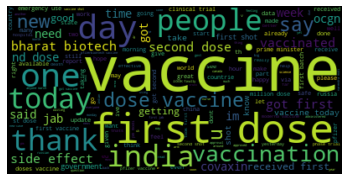

In [ ]:
wordcloud = WordCloud().generate(text)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

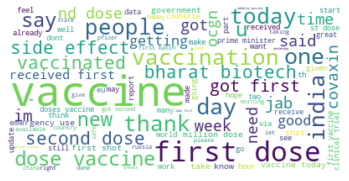

In [ ]:
 # configure the graph
wordcloud = WordCloud(max_font_size=50,
                      max_words=100,
                      background_color="white").generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

# 4. Sentiment Analysis

This section will be divided into 2 parts. The first part is to explain methods and how to use sentiment analysis. The second part is to implementation of sentiment analysis in our dataset.

1. Sentiment Analysis Tutorial
2. Implementation to Our Dataset 

## 4.1 Sentiment Analysis Tutorial

Sentiment Analysis aims to express the emotional state of the texts in a mathematical way. Let's say we have a sentence, each word in it has positive/negative/neutral meanings. These meanings are evaluated holistically and evaluations are made about whether a text is positive or negative.

In [ ]:
df["text"].head()

0    folks said daikon paste could treat cytokine s...
1    world wrong side history year hopefully bigges...
2                   russian vaccine created last years
3    facts immutable senator even youre ethically s...
4                                 explain need vaccine
Name: text, dtype: object

For instance, "good" has a negative meaning here. There is a pre-trained model in nltk for the meanings of words that can carry negative / positive values in this way. Such models are called ***pretty rate models***. Thanks to this pretty rate model, we find existing word sets and scores. These scores are called ***polarity scores***.

In [ ]:
# Example 1
sia = SentimentIntensityAnalyzer()
sia.polarity_scores("The covid situation was bad")

{'neg': 0.467, 'neu': 0.533, 'pos': 0.0, 'compound': -0.5423}

OUR FOCUS IS <u>THE COMPOUND SCORE</u>. 
<br>
Scores from the Compound Score are between -1/1. If the score is less than 0, the text is negative; if it is higher than 0, it means the text is positive.

In [ ]:
df["text"][0:10].apply(lambda x: sia.polarity_scores(x)) 

0    {'neg': 0.0, 'neu': 0.722, 'pos': 0.278, 'comp...
1    {'neg': 0.209, 'neu': 0.608, 'pos': 0.182, 'co...
2    {'neg': 0.0, 'neu': 0.667, 'pos': 0.333, 'comp...
3    {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
4    {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
5    {'neg': 0.0, 'neu': 0.508, 'pos': 0.492, 'comp...
6    {'neg': 0.186, 'neu': 0.419, 'pos': 0.395, 'co...
7    {'neg': 0.0, 'neu': 0.16, 'pos': 0.84, 'compou...
8    {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
9    {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
Name: text, dtype: object

In [ ]:
# take only compound scores
df["text"][0:10].apply(lambda x: sia.polarity_scores(x)["compound"])

0    0.40
1   -0.10
2    0.25
3    0.00
4    0.00
5    0.70
6    0.54
7    0.89
8    0.00
9    0.00
Name: text, dtype: float64

In [ ]:
# save the scores as a new column
df["polarity_score"] = df["text"].apply(lambda x: sia.polarity_scores(x)["compound"])

# 5. Feature Engineering

Firstly, we have to understand how to convert an unsupervised learning problem to a supervised learning problem.<br>

Let's say we have an unsupervised learning method. To make this supervised, we create labels (like positive-negative). Then, we choose the labels we created as the target variable, so that when a new data comes in, we get which class it belongs to as a result of the model.

We can look at the model building phase as starting here because we will create a label and select it as the target variable, and now we will have a supervised learning question.

Let's start with an example, then, apply it to all variables on text column.

In [ ]:
# we have such values and we will create a new variable by taking all of them so that we have a label.
df["text"][0:10].apply(lambda x: 'Negative' if sia.polarity_scores(x)["compound"] < 0 else ('Neutral' if sia.polarity_scores(x)["compound"]==0 else 'Positive'))

0    Positive
1    Negative
2    Positive
3     Neutral
4     Neutral
5    Positive
6    Positive
7    Positive
8     Neutral
9     Neutral
Name: text, dtype: object

In [ ]:
# if we want to see this example with new label and pos/neg side by side
rev_pol = pd.concat([df["text"][0:10], df["text"][0:10].apply(lambda x: 'Negative' if sia.polarity_scores(x)["compound"] < 0 else ('Neutral' if sia.polarity_scores(x)["compound"]==0 else 'Positive'))], axis=1)
rev_pol.columns = ["text", "Polarity Scores"]
rev_pol

text Polarity Scores
0  folks said daikon paste could treat cytokine s...        Positive
1  world wrong side history year hopefully bigges...        Negative
2                 russian vaccine created last years        Positive
3  facts immutable senator even youre ethically s...         Neutral
4                               explain need vaccine         Neutral
5  anyone useful adviceguidance whether vaccine s...        Positive
6  bit sad claim fame success patriotic competiti...        Positive
7                      many bright days best winning        Positive
8                                    vaccine getting         Neutral
9                   states start getting monday says         Neutral

Let's assign a new variable with a polarity score greater than 0 to be positive and the smaller ones to be negative, and equal to zero to be Neutral.

In [ ]:
df["sentiment_label"] = df["text"].apply(lambda x: 'Negative' if sia.polarity_scores(x)["compound"] < 0 else ('Neutral' if sia.polarity_scores(x)["compound"]==0 else 'Positive'))
df["sentiment_label"].value_counts()

Neutral     12986
Positive    11386
Negative     4832
Name: sentiment_label, dtype: int64

Our label has a string naming as pos/neg which is not binary encoded, let's pass it through label_encoder.

In [ ]:
df["Sentiment"] = LabelEncoder().fit_transform(df["sentiment_label"])
df.head()

Unnamed: 0             user_name              user_location                                   user_description         user_created user_followers user_friends user_favourites user_verified  \
0          0            Rachel Roh  La Crescenta-Montrose, CA  Aggregator of Asian American news; scanning di...  2009-04-08 17:52:46            405         1692            3247         False   
1          1           Albert Fong          San Francisco, CA  Marketing dude, tech geek, heavy metal & '80s ...  2009-09-21 15:27:30            834          666             178         False   
2          2              eli🇱🇹🇪🇺👌                   Your Bed                                     heil, hydra 🖐☺  2020-06-25 23:30:28             10           88             155         False   
3          3         Charles Adler     Vancouver, BC - Canada  Hosting "CharlesAdlerTonight" Global News Radi...  2008-09-10 11:28:53          49165         3933           21853          True   
4          4  Citizen News Channel                        NaN  Citizen News Channel bringing you an alternati...  2020-04-23 17:58:42            152          580            1473         False   

         date                                               text                                           hashtags               source retweets  favorites is_retweet sentiment  \
0  2020-12-20  folks said daikon paste could treat cytokine s...                                 ['PfizerBioNTech']  Twitter for Android        0       0.00      False   neutral   
1  2020-12-13  world wrong side history year hopefully bigges...                                                NaN      Twitter Web App        1       1.00      False  positive   
2  2020-12-12                 russian vaccine created last years  ['coronavirus', 'SputnikV', 'AstraZeneca', 'Pf...  Twitter for Android        0       0.00      False   neutral   
3  2020-12-12  facts immutable senator even youre ethically s...                                                NaN      Twitter Web App      446    2129.00      False   neutral   
4  2020-12-12                               explain need vaccine     ['whereareallthesickpeople', 'PfizerBioNTech']   Twitter for iPhone        0       0.00      False   neutral   

                                           orig_text                                      original_text  polarity_score sentiment_label  Sentiment  
0  Same folks said daikon paste could treat a cyt...  Same folks said daikon paste could treat a cyt...            0.40        Positive          2  
1  While the world has been on the wrong side of ...  While the world has been on the wrong side of ...           -0.10        Negative          0  
2  #coronavirus #SputnikV #AstraZeneca #PfizerBio...        Russian vaccine is created to last 2-4 y...            0.25        Positive          2  
3  Facts are immutable, Senator, even when you're...  Facts are immutable, Senator, even when you're...            0.00         Neutral          1  
4  Explain to me again why we need a vaccine @Bor...     Explain to me again why we need a vaccine                 0.00         Neutral          1

As you can see, we got arguments in X, but what we have is text and not variable/variables, no measurement values, we need to bring them to measurable format. We need to generate features from these texts, we need to derive features that are measurable and can be put into mathematical operations.

THE MOST CRITICAL POINT OF NLP WORKS IS THE NUMERICAL REPRESENTATIONS OF TEXTS AND WORDS. IN OTHER EXPRESSIONS, THEY ARE THE STUDY OF VECTORING WORDS.

In other words, we need to perform such operations on X so that we can bring it into a measurable format, on which mathematical operations and machine learning modeling can be performed. For this we need to create word vectors. Commonly used methods:

1. Count Vectors
2. TF-IDF
3. Another Word Embeddings Methods(Word2Vec, GloVe, BERT etc.)

We will analyze the implementation of Count Vectors and TF-IDF. Another word embedding methods can be researched and applied with similar preprocess(such as remove punctions, numbers etc.). Each of these methods is the method used by the computer to put these texts into mathematical operations in the world of linear algebra. The text I have is in the form of a text and I have to do something with this text so that it can be processed in the linear algebra world. Let's start to explanation of methods and application on our dataset.

## 5.1 Count Vectors

Count vectors means subtracting the frequencies of words. For example, it is to extract how many times the words in the review are used. So how do we represent these words (words, characters, ngrams).

<table>
  <tr>
    <th>Method</th>
    <th>Description</th>
  </tr>
  <tr>
    <td>Word</td>
    <td>Numerical representations of each word (Ex: numerical, word, each)</td>
  </tr>
  <tr>
    <td>Characters</td>
    <td>Numerical representations of each characters(Ex: n, u, m, e, r etc.)</td>
  </tr>
  <tr>
  <td>Ngam</td>
  <td>Refers to producing features according to word phrases</td>
  </tr>
</table>

Let's make an example for ngrams for better understaing.

In [ ]:
a = """ngram is a contiguous sequence of n items from a given sample of text or speech."""
TextBlob(a).ngrams(3)  # For example, let's create a triple ngram

[WordList(['ngram', 'is', 'a']),
 WordList(['is', 'a', 'contiguous']),
 WordList(['a', 'contiguous', 'sequence']),
 WordList(['contiguous', 'sequence', 'of']),
 WordList(['sequence', 'of', 'n']),
 WordList(['of', 'n', 'items']),
 WordList(['n', 'items', 'from']),
 WordList(['items', 'from', 'a']),
 WordList(['from', 'a', 'given']),
 WordList(['a', 'given', 'sample']),
 WordList(['given', 'sample', 'of']),
 WordList(['sample', 'of', 'text']),
 WordList(['of', 'text', 'or']),
 WordList(['text', 'or', 'speech'])]

Groups a word in 3, moves on to the next word and groups it in 3, etc. So ngram is to break words into chunks with groups.

So, we can count words, characters, ngrams.

For example, we have 4 sentences (1st document, 2nd document etc.), it can be anything we get here, for example 1st tweet, 2nd tweet etc. If we look at our example dataset, we have 1st tweet, 2nd tweet... In short, it refers to different units that we are interested in.

In [ ]:
corpus = ['This is the first document.',
          'This document is the second document.',
          'And this is the third one.',
          'Is this the first document?']

In [ ]:
# word frequency
vectorizer = CountVectorizer()
X_c = vectorizer.fit_transform(corpus)  # we transformed the corpus with fit_transform
vectorizer.get_feature_names() 

['and', 'document', 'first', 'is', 'one', 'second', 'the', 'third', 'this']

In [ ]:
X_c.toarray()  # we vectorized each unit

array([[0, 1, 1, 1, 0, 0, 1, 0, 1],
       [0, 2, 0, 1, 0, 1, 1, 0, 1],
       [1, 0, 0, 1, 1, 0, 1, 1, 1],
       [0, 1, 1, 1, 0, 0, 1, 0, 1]])

It means:
*   First document includes 0 "and", 1 "document", 1 "first" etc.
*   Second document includes 0 "and", 2 "document", 0 "first" etc.
*   Third document includes 1 "and", 0 "document", 0 "first" etc.
*   Fourth document includes 0 "and", 1 "document", 1 "first" etc.

For ngram, we will use an argument as analyzer="word", if we do not enter any argument, the default of CountVectorizer is to make word frequency.

In [ ]:
# n-gram
vectorizer2 = CountVectorizer(analyzer='word', ngram_range=(2, 2))
X_n = vectorizer2.fit_transform(corpus)
vectorizer2.get_feature_names()  # it brought the words one by one above, now he brought them in phrases

['and this',
 'document is',
 'first document',
 'is the',
 'is this',
 'second document',
 'the first',
 'the second',
 'the third',
 'third one',
 'this document',
 'this is',
 'this the']

In [ ]:
X_n.toarray()

array([[0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0],
       [0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0],
       [1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0],
       [0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1]])

### Application to our project

Firstly, we will apply word count, then, ngram process will be done.

In [ ]:
y = df['Sentiment']
X = df['text']

In [ ]:
vectorizer = CountVectorizer()  # default => word count
X_count = vectorizer.fit_transform(X)  # X stands for texts, we only count the frequencies of the words

In [ ]:
vectorizer.get_feature_names()[350:360]  # let's look at some features

['advises',
 'advising',
 'advisor',
 'advisors',
 'advisory',
 'advocate',
 'advocating',
 'ae',
 'aefi',
 'aefis']

## 5.2 TF-IDF (Term Frequency-Inverse Document Frequency)

It is a normalized, standardized word vector generation method to eliminate some of the biases that the count vector method may reveal. Count Vectorizer will create biases in favor of words with high frequency and against other words. In order to eliminate this and standardize it, the TF-IDF method has been proposed.

HOW IT WORKS: A standardization process is performed on the focus of the frequency of the words in the documents and the frequency of the words in the whole corpus.

The most critical point of NLP studies is the effort to represent words/texts numerically, the work of creating a word vector. The method for this is Count Vector, TF-IDF or another Word Embedding methods(such as Word2Vec, GloVe, BERT which can be considered as more advanced methods).

TF-IDF Steps:
1.   Calculates Count Vectors
2.   Calculate TF (frequency of t term in related document/total number of terms in document) - In other words, we subtract the weight of a particular word in a particular document.
3. Calculate IDF( 1+loge( (total number of documents+1)/(number of documents with t term in it+1) )

<i>In step 2, we focused on the words within each document, and in step 3, we try to consider the impact of terms on all documents.</i>

1. Calculate TF*IDF (we multiply the TF matrix by the vector IDF)
2. Perform L2 Normalization. Find the square root of the sum of the squares of the rows, divide all the cells in the corresponding row by the value you found.

When creating the Count Vector, there was a question whether we are doing this for words, characters, or ngrams. Similarly for TF-IDF, there is the question whether to do it for words, characters, or ngrams. As an example, let's do word and ngram as before.

We will use "corpus" that we created above, again.



In [ ]:
# word frequency
tf_idf_word_vectorizer = TfidfVectorizer()  # default = word frequency
# corpus_tf_idf_word = tf_idf_word_vectorizer.fit_transform(corpus)
# tf_idf_word_vectorizer.get_feature_names_out()

In [ ]:
# corpus_tf_idf_word.toarray()

Same with Count Vectors, each text on corpus were taken and each words' TF-IDF scores were calculated above according to word frequency.

In [ ]:
# ngram
# tf_idf_ngram_vectorizer = TfidfVectorizer(ngram_range=(2, 3))
# corpus_tf_idf_ngram = tf_idf_ngram_vectorizer.fit_transform(X)
# tf_idf_ngram_vectorizer.get_feature_names_out()

array(['aa gayatheres', 'aa gayatheres glitch', 'aa nurse', ...,
       'zvataidei tiri', 'zvataidei tiri kuudzwa', 'zycov vaccine'],
      dtype=object)

### Application to our project
Since our tweeets are saved on X, we will use same process using X rather than corpus.

In [ ]:
# word
# tf_idf_word_vectorizer = TfidfVectorizer()
X_tf_idf_word = tf_idf_word_vectorizer.fit_transform(X)

In [ ]:
# ngram
tf_idf_ngram_vectorizer = TfidfVectorizer(ngram_range=(2, 3))
X_tf_idf_ngram = tf_idf_ngram_vectorizer.fit_transform(X)

Finally, we created all of the features. As a reminder, our features are word frequency according to CountVectorizer and TF-IDF scores for words and ngrams. It means, we create 3 features.

# 6. Sentiment Modelling
## 6.1 Logistic Regression


In [ ]:
df3 = df[['text', 'sentiment_label']]

In [ ]:
df3.head()

In [ ]:
df3.shape

In [ ]:
vectorizer1 = CountVectorizer() 
final_features1 = vectorizer1.fit_transform(df3['text']).toarray()
final_features1.shape

In [ ]:
from sklearn.feature_selection import SelectKBest, chi2
import pickle

X = df3['text']
Y = df3['sentiment_label']
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25)

pipeline = Pipeline([('vect', vectorizer1),
                     ('chi',  SelectKBest(chi2, k=1200)),
                     ('clf', LogisticRegression(random_state=0))])

model = pipeline.fit(X_train, y_train)
with open('LogisticRegression.pickle', 'wb') as f:
    pickle.dump(model, f)

ytest = np.array(y_test)

# confusion matrix and classification report(precision, recall, F1-score)
print(classification_report(ytest, model.predict(X_test)))
print(confusion_matrix(ytest, model.predict(X_test)))

In [ ]:
matrix_count_log_1 = confusion_matrix(ytest, model.predict(X_test))
sns.heatmap(matrix_count_log_1, annot=True, fmt="d")
plt.title('Confusion Matrix of Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('True')
print(classification_report(ytest, model.predict(X_test)))

In [ ]:
vectorizer = TfidfVectorizer(min_df= 3, stop_words="english", sublinear_tf=True, norm='l2', ngram_range=(1, 2))
final_features = vectorizer.fit_transform(df3['text']).toarray()
final_features.shape

              precision    recall  f1-score   support

           0       0.07      0.00      0.01       996
           1       0.44      0.63      0.52      2559
           2       0.39      0.37      0.38      2286

    accuracy                           0.42      5841
   macro avg       0.30      0.33      0.30      5841
weighted avg       0.36      0.42      0.38      5841



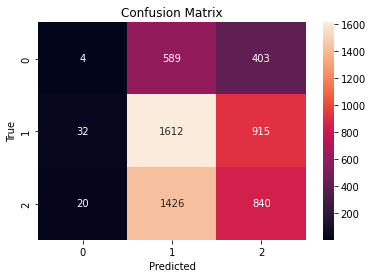

In [ ]:
from sklearn.feature_selection import SelectKBest, chi2
import pickle

X = df3['text']
Y = df3['sentiment_label']
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25)

pipeline = Pipeline([('vect', vectorizer),
                     ('chi',  SelectKBest(chi2, k=1200)),
                     ('clf', LogisticRegression(random_state=0))])

model = pipeline.fit(X_train, y_train)
with open('LogisticRegression.pickle', 'wb') as f:
    pickle.dump(model, f)

ytest = np.array(y_test)

# confusion matrix and classification report(precision, recall, F1-score)
print(classification_report(ytest, model.predict(X_test)))
print(confusion_matrix(ytest, model.predict(X_test)))

In [ ]:
matrix_count_log_1 = confusion_matrix(ytest, model.predict(X_test))
sns.heatmap(matrix_count_log_1, annot=True, fmt="d")
plt.title('Confusion Matrix of Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('True')
print(classification_report(ytest, model.predict(X_test)))

In [ ]:
from yellowbrick.classifier import ROCAUC

def plot_ROC_curve(model, xtrain, ytrain, xtest, ytest):

    # Creating visualization with the readable labels
    visualizer = ROCAUC(model, encoder={0: 'Negative', 
                                        1: 'Neutral', 
                                        2: 'Positive'})
                                        
    # Fitting to the training data first then scoring with the test data                                    
    visualizer.fit(xtrain, ytrain)
    visualizer.score(xtest, ytest)
    visualizer.show()
    
    return visualizer

In [ ]:
X_train2 = vectorizer.fit_transform(X_train)
X_train2 = X_train2.toarray()

X_test2 = vectorizer.transform(X_test)
X_test2 = X_test2.toarray()

array([0])

## 6.2 Random Forest
Let's create a model according to 3 different methods and compare their success.

<!-- k-Nearest Neighbors.
Decision Trees.
Naive Bayes.
Random Forest.
Gradient Boosting. -->

In [ ]:
forest = RandomForestClassifier() 
forest = forest.fit(X_train2, y_train)

Count Vectors Score 0.918117024967659


In [ ]:
from sklearn.metrics import accuracy_score

predictions2 = forest.predict(X_test2) 
print("Accuracy: ", accuracy_score(y_test, predictions2))

In [ ]:
matrix_count_log_3 = confusion_matrix(ytest, forest.predict(X_test2))
sns.heatmap(matrix_count_log_3, annot=True, fmt="d")
plt.title('Confusion Matrix of RandomForest Classifier')
plt.xlabel('Predicted')
plt.ylabel('True')
print(classification_report(ytest, forest.predict(X_test2)))

## 6.3 Baseline Model using MultinomialNB

In [ ]:
model_nb=MultinomialNB(alpha = 0.1)
model_nb = model_nb.fit(X_train2, y_train)

predictions3 = model_nb.predict(X_test2) 
print("Accuracy: ", accuracy_score(y_test, predictions3))

text  Sentiment
0  folk said daikon paste could treat cytokine storm          2
1  world wrong side history year hopefully bigges...          0
2                  russian vaccine created last year          2
3  fact immutable senator even youre ethically st...          1
4                               explain need vaccine          1

In [ ]:
matrix_count_log_4 = confusion_matrix(ytest, model_nb.predict(X_test2))
sns.heatmap(matrix_count_log_4, annot=True, fmt="d")
plt.title('Confusion Matrix of MultinomialNB Classifier')
plt.xlabel('Predicted')
plt.ylabel('True')
print(classification_report(ytest, model_nb.predict(X_test2)))

text  Sentiment
21607                 support joe need best vaccine fight          2
38440                   acceptance overall response tepid          2
143441  dose wellspring healthcare centre wellness hea...          2
149256  dose pmcapollo clinic kharadi floor cool space...          2
122574                 india asks eu member accept report          2

## 6.4 BERT

Converting text into tokens

In [ ]:
df.head()

user_name              user_location                                   user_description         user_created  user_followers  user_friends  user_favourites  user_verified  \
0            Rachel Roh  La Crescenta-Montrose, CA  Aggregator of Asian American news; scanning di...  2009-04-08 17:52:46             405          1692             3247          False   
1           Albert Fong          San Francisco, CA  Marketing dude, tech geek, heavy metal & '80s ...  2009-09-21 15:27:30             834           666              178          False   
2              eli🇱🇹🇪🇺👌                   Your Bed                                     heil, hydra 🖐☺  2020-06-25 23:30:28              10            88              155          False   
3         Charles Adler     Vancouver, BC - Canada  Hosting "CharlesAdlerTonight" Global News Radi...  2008-09-10 11:28:53           49165          3933            21853           True   
4  Citizen News Channel                        NaN  Citizen News Channel bringing you an alternati...  2020-04-23 17:58:42             152           580             1473          False   

                  date                                               text                                           hashtags               source  retweets  favorites is_retweet  \
0  2020-12-20 06:06:44  folk said daikon paste could treat cytokine storm                                 ['PfizerBioNTech']  Twitter for Android      0.00       0.00      False   
1  2020-12-13 16:27:13  world wrong side history year hopefully bigges...                                                NaN      Twitter Web App      1.00       1.00      False   
2  2020-12-12 20:33:45                  russian vaccine created last year  ['coronavirus', 'SputnikV', 'AstraZeneca', 'Pf...  Twitter for Android      0.00       0.00      False   
3  2020-12-12 20:23:59  fact immutable senator even youre ethically st...                                                NaN      Twitter Web App    446.00    2129.00      False   
4  2020-12-12 20:17:19                               explain need vaccine     ['whereareallthesickpeople', 'PfizerBioNTech']   Twitter for iPhone      0.00       0.00      False   

                                       original_text  polarity_score sentiment_label  Sentiment  
0  Same folks said daikon paste could treat a cyt...            0.40        Positive          2  
1  While the world has been on the wrong side of ...           -0.10        Negative          0  
2  #coronavirus #SputnikV #AstraZeneca #PfizerBio...            0.25        Positive          2  
3  Facts are immutable, Senator, even when you're...            0.00         Neutral          1  
4  Explain to me again why we need a vaccine @Bor...            0.00         Neutral          1

In [ ]:
df = df.sample(frac=1)
df.dropna(inplace=True)

In [ ]:
n=int(np.floor(df.shape[0]*0.8))
train= df[:n][['text', 'sentiment_label']]
test= df[n:][['text', 'sentiment_label']]

In [ ]:
train.head()

text sentiment_label
70706                                 yay first dose done        Positive
43157                        care least cartoon rex jones        Positive
70761                        treating second shot syringe         Neutral
133115                                   getting tomorrow         Neutral
78988   looking forward going shop spend thanks premat...        Positive

In [ ]:
model = TFBertForSequenceClassification.from_pretrained("bert-base-uncased")
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/536M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

In [ ]:
train["sentiment"] = train["sentiment_label"].map({"Neutral":0, "Positive":0.5, "Negative": 1})
test["sentiment"] = test["sentiment_label"].map({"Neutral":0, "Positive":0.5, "Negative": 1})

In [ ]:
train.head()

text sentiment_label  sentiment
70706                                 yay first dose done        Positive       0.50
43157                        care least cartoon rex jones        Positive       0.50
70761                        treating second shot syringe         Neutral       0.00
133115                                   getting tomorrow         Neutral       0.00
78988   looking forward going shop spend thanks premat...        Positive       0.50

In [ ]:
def convert_data_to_examples(train, test, DATA_COLUMN, LABEL_COLUMN):
  train_InputExamples = train.apply(lambda x : InputExample(guid=None,
                                                            text_a=x[DATA_COLUMN],
                                                            text_b=None,
                                                            label=x[LABEL_COLUMN]), axis=1)
  
  validation_InputExamples = test.apply(lambda x : InputExample(guid=None,
                                                            text_a=x[DATA_COLUMN],
                                                            text_b=None,
                                                            label=x[LABEL_COLUMN]), axis=1)

  return train_InputExamples, validation_InputExamples


def convert_examples_to_tf_dataset(examples, tokenizer, max_length=100):
  features = []

  for e in examples:
    input_dict = tokenizer.encode_plus(
        e.text_a,
        add_special_tokens=True,
        max_length=max_length,
        return_token_type_ids=True,
        return_attention_mask=True,
        pad_to_max_length=True,
        truncation=True
    )

    input_ids, token_type_ids, attention_mask = (input_dict["input_ids"], 
                                                 input_dict["token_type_ids"],
                                                 input_dict["attention_mask"])
    features.append(
        InputFeatures(
            input_ids=input_ids, 
            attention_mask=attention_mask, 
            token_type_ids=token_type_ids, 
            label=e.label
        )
    )

  def gen():
    for f in features:
      yield (
          {
              "input_ids":f.input_ids,
              "attention_mask":f.attention_mask,
              "token_type_ids":f.token_type_ids
          },
          f.label)

  return tf.data.Dataset.from_generator(
      gen,
      ({"input_ids":tf.int32, "attention_mask":tf.int32, "token_type_ids":tf.int32}, tf.int64),
      (
          {
            "input_ids":tf.TensorShape([None]),
           "attention_mask":tf.TensorShape([None]),
           "token_type_ids":tf.TensorShape([None])
          },
       tf.TensorShape([]),
      ),
      
  )

DATA_COLUMN = "text"
LABEL_COLUMN = "sentiment"

In [ ]:
train_InputExamples, validation_InputExamples = convert_data_to_examples(train, test, DATA_COLUMN, LABEL_COLUMN)

train_InputExamples.dropna(inplace=True)
validation_InputExamples.dropna(inplace=True)

train_data = convert_examples_to_tf_dataset(list(train_InputExamples), tokenizer)
train_data = train_data.shuffle(100).batch(32).repeat(2)

validation_data = convert_examples_to_tf_dataset(list(validation_InputExamples), tokenizer)
validation_data = validation_data.batch(32)

In [ ]:
# configure bert
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=3e-5, epsilon=1e-08, clipnorm=1.0),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy('accuracy')])

model.fit(train_data, epochs=2, validation_data=validation_data)

Epoch 1/2
4258/4258 [==============================] - 2762s 641ms/step - loss: 0.0790 - accuracy: 0.9696 - val_loss: 0.0641 - val_accuracy: 0.9783
Epoch 2/2
4258/4258 [==============================] - 2725s 640ms/step - loss: 0.0199 - accuracy: 0.9937 - val_loss: 0.0741 - val_accuracy: 0.9815


In [ ]:
import os

checkpoint_path = "bert_323_9096.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

In [ ]:
model.save_weights(checkpoint_path.format(epoch=2))

In [ ]:
model.summary()

Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
 dropout_37 (Dropout)        multiple                  0         
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
Total params: 109,483,778
Trainable params: 109,483,778
Non-trainable params: 0
_________________________________________________________________


## 6.4 XLNET

In [ ]:
import pandas as pd

df2 = pd.read_csv("content/data/vax_tweets_sentiment.csv",engine='python')
df2.head()

Unnamed: 0                   id             user_name  \
0          0  1340539111971516416            Rachel Roh   
1          1  1338158543359250433           Albert Fong   
2          2  1337858199140118533              eli🇱🇹🇪🇺👌   
3          3  1337855739918835717         Charles Adler   
4          4  1337854064604966912  Citizen News Channel   

               user_location  \
0  La Crescenta-Montrose, CA   
1          San Francisco, CA   
2                   Your Bed   
3     Vancouver, BC - Canada   
4                        NaN   

                                    user_description         user_created  \
0  Aggregator of Asian American news; scanning di...  2009-04-08 17:52:46   
1  Marketing dude, tech geek, heavy metal & '80s ...  2009-09-21 15:27:30   
2                                     heil, hydra 🖐☺  2020-06-25 23:30:28   
3  Hosting "CharlesAdlerTonight" Global News Radi...  2008-09-10 11:28:53   
4  Citizen News Channel bringing you an alternati...  2020-04-23 17:58:42   

  user_followers user_friends user_favourites user_verified        date  \
0            405         1692            3247         False  2020-12-20   
1            834          666             178         False  2020-12-13   
2             10           88             155         False  2020-12-12   
3          49165         3933           21853          True  2020-12-12   
4            152          580            1473         False  2020-12-12   

                                                text  \
0  Same folks said daikon paste could treat a cyt...   
1  While the world has been on the wrong side of ...   
2        Russian vaccine is created to last 2-4 y...   
3  Facts are immutable, Senator, even when you're...   
4     Explain to me again why we need a vaccine        

                                            hashtags               source  \
0                                 ['PfizerBioNTech']  Twitter for Android   
1                                                NaN      Twitter Web App   
2  ['coronavirus', 'SputnikV', 'AstraZeneca', 'Pf...  Twitter for Android   
3                                                NaN      Twitter Web App   
4     ['whereareallthesickpeople', 'PfizerBioNTech']   Twitter for iPhone   

  retweets  favorites is_retweet sentiment  \
0        0        0.0      False   neutral   
1        1        1.0      False  positive   
2        0        0.0      False   neutral   
3      446     2129.0      False   neutral   
4        0        0.0      False   neutral   

                                           orig_text  
0  Same folks said daikon paste could treat a cyt...  
1  While the world has been on the wrong side of ...  
2  #coronavirus #SputnikV #AstraZeneca #PfizerBio...  
3  Facts are immutable, Senator, even when you're...  
4  Explain to me again why we need a vaccine @Bor...

In [ ]:
df2.shape

(29452, 19)

In [ ]:
df2 = df2.drop(['id'], axis=1)

In [ ]:
lemmatizer = WordNetLemmatizer()

In [ ]:
def tweets_cleaning(df, text_col="text", emoji_map={}):
  
  # demojify
  def replace_emoji(s):
    if s is None:
      return ""
    for word, replacement in emoji_map.items():
      s = s.replace(word, " "+replacement+" ")
    return s

  df["original_text"] = df[text_col].copy()
  df[text_col] = df[text_col].apply(replace_emoji)


  # Remove twitter handles
  df[text_col] = df[text_col].apply(lambda x:re.sub('@[^\s]+','',str(x)))
    
  # Remove URLs
  df[text_col] = df[text_col].apply(lambda x:re.sub(r"http\S+", "", str(x)))

  # Remove hashtags
  df[text_col] = df[text_col].apply(lambda x:re.sub(r'\B#\S+','',str(x)))

  # Lower casing
  df[text_col] = df[text_col].str.lower()

  # remove numbers and special characters
  df[text_col] = df[text_col].apply(lambda x : re.sub(r"[^a-zA-Z ]", "", x))

  df = df[df[text_col].apply(lambda x : len(x))>2]
  
  # Remove stopwords
  def remove_stopwords(text):
    STOPWORDS = set(stopwords.words('english'))
    update_words = ['covid','#coronavirus', '#coronavirusoutbreak', '#coronavirusPandemic', 
                    '#covid19', '#covid_19', '#epitwitter', '#ihavecorona', 'amp', 'coronavirus', 'covid19']
    STOPWORDS.update(update_words)
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])

  def lemmatize(text):
    word_list = nltk.word_tokenize(text)
    lemmatized_output = ' '.join([lemmatizer.lemmatize(w) for w in word_list])
    if text!=lemmatized_output:
      print(text,"===",lemmatized_output)
    return lemmatized_output

  
  df[text_col] = df[text_col].apply(lambda text: remove_stopwords(text))

  #df[text_col] = df[text_col].apply(lambda text: lemmatize(text))

  # Single character or double space removal
  df[text_col] = df[text_col].apply(lambda x:re.sub(r'\s+[a-zA-Z]\s+', '', str(x)))
  df[text_col] = df[text_col].apply(lambda x:re.sub(r'\s+', ' ', str(x), flags=re.I))

  return df[df[text_col]!=''] # remove none

In [ ]:
df2 = tweets_cleaning(df2, emoji_map=emoji_map)

In [ ]:
df2 = df2.drop('Unnamed: 0', axis = 1)

In [ ]:
df2_base_learner = df2[:n]
print("df shape is: ", df2.shape)
print("df_base_learner shape is: ",df2_base_learner.shape)

df shape is:  (29204, 18)
df_base_learner shape is:  (29204, 18)


In [ ]:
X = df2_base_learner.drop('sentiment', axis = 1)
y = df2_base_learner['sentiment']

In [ ]:
tokenizer2 = BertTokenizer.from_pretrained("bert-base-uncased")

In [ ]:
x2=int(np.floor(df2_base_learner.shape[0]*0.8))
train2 = df2_base_learner[:x2][['sentiment', 'original_text']]
test2 = df2_base_learner[x2:][['sentiment', 'original_text']]

In [ ]:
xlnet_model = 'xlnet-base-cased'
xlnet_tokenizer = XLNetTokenizer.from_pretrained(xlnet_model)

Downloading:   0%|          | 0.00/798k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/760 [00:00<?, ?B/s]

In [ ]:
train2["sentiment_label"] = train2["sentiment"].map({"neutral":0, "positive":0.5, "negative": 1})
test2["sentiment_label"] = test2["sentiment"].map({"neutral":0, "positive":0.5, "negative": 1})

In [ ]:
def convert_data_to_examples(train, DATA_COLUMN, LABEL_COLUMN):
  train_InputExamples = train.apply(lambda x : InputExample(guid=None,
                                                            text_a=x[DATA_COLUMN],
                                                            text_b=None,
                                                            label=x[LABEL_COLUMN]), axis=1)
  return train_InputExamples

def convert_examples_to_tf_dataset(examples, tokenizer):
  features = []

  for e in examples:
    input_dict = tokenizer.encode_plus(
        e.text_a,
        add_special_tokens=True,
        max_length=len(examples),
        return_token_type_ids=True,
        return_attention_mask=True,
        pad_to_max_length=True,
        truncation=True
    )

    input_ids, token_type_ids, attention_mask = (input_dict["input_ids"], input_dict["token_type_ids"],
                                                 input_dict["attention_mask"])
  
  return np.array(input_ids), np.array(attention_mask) 

DATA_COLUMN = "original_text"
LABEL_COLUMN = "sentiment_label"

In [ ]:
def create_model_xlnet(xlnet_model):
    word_inputs = tf.keras.Input(shape=(None, ), name='word_inputs', dtype='int32')

    
    xlnet = TFXLNetModel.from_pretrained(xlnet_model)
    xlnet_encodings = xlnet(word_inputs)[0]

    # Collect last step from last hidden state (CLS)
    doc_encoding = tf.squeeze(xlnet_encodings[:, -1:, :], axis=1)
    
    doc_encoding = tf.keras.layers.Dropout(.1)(doc_encoding)
     
    outputs = tf.keras.layers.Dense(1, activation='sigmoid', name='outputs')(doc_encoding)

    model = tf.keras.Model(inputs=[word_inputs], outputs=[outputs])
    model.compile(optimizer=tf.keras.optimizers.Adam(lr=2e-5), loss='binary_crossentropy', metrics=['accuracy'])

    return model

In [ ]:
xlnet = create_model_xlnet(xlnet_model)
xlnet.summary()

Downloading:   0%|          | 0.00/565M [00:00<?, ?B/s]

Some layers from the model checkpoint at xlnet-base-cased were not used when initializing TFXLNetModel: ['lm_loss']
- This IS expected if you are initializing TFXLNetModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFXLNetModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFXLNetModel were initialized from the model checkpoint at xlnet-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFXLNetModel for predictions without further training.


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 word_inputs (InputLayer)    [(None, None)]            0         
                                                                 
 tfxl_net_model (TFXLNetMode  TFXLNetModelOutput(last_  116718336
 l)                          hidden_state=(None, None            
                             , 768),                             
                              mems=((None, None, 768)            
                             , (None, None, 768),                
                              (None, None, 768),                 
                              (None, None, 768),                 
                              (None, None, 768),                 
                              (None, None, 768),                 
                              (None, None, 768),                 
                              (None, None, 768),             

In [ ]:
train_InputExamples2 = convert_data_to_examples(train2, DATA_COLUMN, LABEL_COLUMN)
test_InputExamples2 = convert_data_to_examples(test2, DATA_COLUMN, LABEL_COLUMN)
train_input_ids, train_attention_masks = convert_examples_to_tf_dataset(list(train_InputExamples2), tokenizer)
test_input_ids, test_attention_masks = convert_examples_to_tf_dataset(list(test_InputExamples2), tokenizer)

In [ ]:
targets = train2['sentiment_label'].values
targets_y = test2['sentiment_label'].values
targets= np.array(targets).reshape(-1, 1)

In [ ]:
targets.shape

(23363, 1)

In [ ]:
train_input_ids = np.array(train_input_ids).reshape(-1, 1)
train_input_ids 

array([[  101],
       [21250],
       [ 2000],
       ...,
       [    0],
       [    0],
       [    0]])

In [ ]:
tf.config.run_functions_eagerly(True)
history_xl = xlnet.fit(train_input_ids, targets, epochs=4, batch_size=64)

Epoch 1/4


  1/366 [..............................] - ETA: 9:13 - loss: 2.9615 - accuracy: 0.2812

  2/366 [..............................] - ETA: 5:39 - loss: 2.1498 - accuracy: 0.3828

  3/366 [..............................] - ETA: 5:41 - loss: 1.7410 - accuracy: 0.4479

  4/366 [..............................] - ETA: 6:31 - loss: 1.5980 - accuracy: 0.4961

  5/366 [..............................] - ETA: 6:47 - loss: 1.5439 - accuracy: 0.5219

  6/366 [..............................] - ETA: 6:16 - loss: 1.5601 - accuracy: 0.5312

  7/366 [..............................] - ETA: 5:52 - loss: 1.5870 - accuracy: 0.5246

  8/366 [..............................] - ETA: 5:28 - loss: 1.4779 - accuracy: 0.5469

  9/366 [..............................] - ETA: 5:11 - loss: 1.4247 - accuracy: 0.5538

 10/366 [..............................] - ETA: 4:56 - loss: 1.3776 - accuracy: 0.5516

 11/366 [..............................] - ETA: 4:44 - loss: 1.3442 - accuracy: 0.5483

 12/366 [..............................] - ETA: 4:35 - loss: 1.3394 - accuracy: 0.5417

 13/366 [>.............................] - ETA: 4:27 - loss: 1.3089 - accuracy: 0.5300

 14/366 [>.............................] - ETA: 4:20 - loss: 1.2863 - accuracy: 0.5246

 15/366 [>.............................] - ETA: 4:14 - loss: 1.2642 - accuracy: 0.5188

 16/366 [>.............................] - ETA: 4:09 - loss: 1.2406 - accuracy: 0.5127

 17/366 [>.............................] - ETA: 4:08 - loss: 1.2088 - accuracy: 0.5221

 18/366 [>.............................] - ETA: 4:01 - loss: 1.1919 - accuracy: 0.5278

 19/366 [>.............................] - ETA: 3:54 - loss: 1.1715 - accuracy: 0.5288

 20/366 [>.............................] - ETA: 3:47 - loss: 1.1549 - accuracy: 0.5281

 21/366 [>.............................] - ETA: 3:41 - loss: 1.1265 - accuracy: 0.5387

 22/366 [>.............................] - ETA: 3:36 - loss: 1.1141 - accuracy: 0.5419

 23/366 [>.............................] - ETA: 3:32 - loss: 1.1039 - accuracy: 0.5421

 24/366 [>.............................] - ETA: 3:27 - loss: 1.0907 - accuracy: 0.5475

 25/366 [=>............................] - ETA: 3:23 - loss: 1.0784 - accuracy: 0.5481

 26/366 [=>............................] - ETA: 3:19 - loss: 1.0697 - accuracy: 0.5475

 27/366 [=>............................] - ETA: 3:16 - loss: 1.0554 - accuracy: 0.5486

 28/366 [=>............................] - ETA: 3:13 - loss: 1.0435 - accuracy: 0.5469

 29/366 [=>............................] - ETA: 3:10 - loss: 1.0327 - accuracy: 0.5469

 30/366 [=>............................] - ETA: 3:07 - loss: 1.0283 - accuracy: 0.5427

 31/366 [=>............................] - ETA: 3:04 - loss: 1.0179 - accuracy: 0.5428

 32/366 [=>............................] - ETA: 3:01 - loss: 1.0101 - accuracy: 0.5396

 33/366 [=>............................] - ETA: 2:59 - loss: 0.9990 - accuracy: 0.5393

 34/366 [=>............................] - ETA: 2:57 - loss: 0.9882 - accuracy: 0.5391

 35/366 [=>............................] - ETA: 2:55 - loss: 0.9811 - accuracy: 0.5406

 36/366 [=>............................] - ETA: 2:53 - loss: 0.9766 - accuracy: 0.5408

 37/366 [==>...........................] - ETA: 2:51 - loss: 0.9754 - accuracy: 0.5393

 38/366 [==>...........................] - ETA: 2:49 - loss: 0.9664 - accuracy: 0.5440

 39/366 [==>...........................] - ETA: 2:47 - loss: 0.9605 - accuracy: 0.5441

 40/366 [==>...........................] - ETA: 2:45 - loss: 0.9515 - accuracy: 0.5469

 41/366 [==>...........................] - ETA: 2:44 - loss: 0.9456 - accuracy: 0.5488

 42/366 [==>...........................] - ETA: 2:42 - loss: 0.9391 - accuracy: 0.5484

 43/366 [==>...........................] - ETA: 2:46 - loss: 0.9338 - accuracy: 0.5491

 44/366 [==>...........................] - ETA: 2:45 - loss: 0.9255 - accuracy: 0.5508

 45/366 [==>...........................] - ETA: 2:43 - loss: 0.9230 - accuracy: 0.5493

 46/366 [==>...........................] - ETA: 2:42 - loss: 0.9165 - accuracy: 0.5496

 47/366 [==>...........................] - ETA: 2:40 - loss: 0.9106 - accuracy: 0.5502

 48/366 [==>...........................] - ETA: 2:39 - loss: 0.9047 - accuracy: 0.5511

 49/366 [===>..........................] - ETA: 2:37 - loss: 0.8997 - accuracy: 0.5510

 50/366 [===>..........................] - ETA: 2:36 - loss: 0.8969 - accuracy: 0.5494

 51/366 [===>..........................] - ETA: 2:35 - loss: 0.8943 - accuracy: 0.5466

 52/366 [===>..........................] - ETA: 2:34 - loss: 0.8864 - accuracy: 0.5490

 53/366 [===>..........................] - ETA: 2:33 - loss: 0.8820 - accuracy: 0.5495

 54/366 [===>..........................] - ETA: 2:32 - loss: 0.8781 - accuracy: 0.5503

 55/366 [===>..........................] - ETA: 2:31 - loss: 0.8724 - accuracy: 0.5528

 56/366 [===>..........................] - ETA: 2:29 - loss: 0.8676 - accuracy: 0.5552

 57/366 [===>..........................] - ETA: 2:28 - loss: 0.8674 - accuracy: 0.5551

 58/366 [===>..........................] - ETA: 2:27 - loss: 0.8637 - accuracy: 0.5555

 59/366 [===>..........................] - ETA: 2:26 - loss: 0.8583 - accuracy: 0.5575

 60/366 [===>..........................] - ETA: 2:25 - loss: 0.8590 - accuracy: 0.5573

 61/366 [====>.........................] - ETA: 2:24 - loss: 0.8540 - accuracy: 0.5602

 62/366 [====>.........................] - ETA: 2:23 - loss: 0.8502 - accuracy: 0.5617

 63/366 [====>.........................] - ETA: 2:22 - loss: 0.8459 - accuracy: 0.5635

 64/366 [====>.........................] - ETA: 2:21 - loss: 0.8430 - accuracy: 0.5632

 65/366 [====>.........................] - ETA: 2:21 - loss: 0.8413 - accuracy: 0.5635

 66/366 [====>.........................] - ETA: 2:20 - loss: 0.8375 - accuracy: 0.5644

 67/366 [====>.........................] - ETA: 2:19 - loss: 0.8363 - accuracy: 0.5634

 68/366 [====>.........................] - ETA: 2:18 - loss: 0.8343 - accuracy: 0.5636

 69/366 [====>.........................] - ETA: 2:17 - loss: 0.8319 - accuracy: 0.5627

 70/366 [====>.........................] - ETA: 2:16 - loss: 0.8288 - accuracy: 0.5632

 71/366 [====>.........................] - ETA: 2:16 - loss: 0.8272 - accuracy: 0.5623

 72/366 [====>.........................] - ETA: 2:15 - loss: 0.8238 - accuracy: 0.5627

 73/366 [====>.........................] - ETA: 2:14 - loss: 0.8207 - accuracy: 0.5629

 74/366 [=====>........................] - ETA: 2:13 - loss: 0.8185 - accuracy: 0.5638

 75/366 [=====>........................] - ETA: 2:12 - loss: 0.8154 - accuracy: 0.5644

 76/366 [=====>........................] - ETA: 2:12 - loss: 0.8147 - accuracy: 0.5644

 77/366 [=====>........................] - ETA: 2:11 - loss: 0.8115 - accuracy: 0.5659

 78/366 [=====>........................] - ETA: 2:10 - loss: 0.8083 - accuracy: 0.5669

 79/366 [=====>........................] - ETA: 2:09 - loss: 0.8056 - accuracy: 0.5676

 80/366 [=====>........................] - ETA: 2:09 - loss: 0.8025 - accuracy: 0.5672

 81/366 [=====>........................] - ETA: 2:08 - loss: 0.8023 - accuracy: 0.5662

 82/366 [=====>........................] - ETA: 2:07 - loss: 0.8003 - accuracy: 0.5669

 83/366 [=====>........................] - ETA: 2:07 - loss: 0.7983 - accuracy: 0.5672

 84/366 [=====>........................] - ETA: 2:06 - loss: 0.7957 - accuracy: 0.5675

 85/366 [=====>........................] - ETA: 2:05 - loss: 0.7941 - accuracy: 0.5664

 86/366 [======>.......................] - ETA: 2:04 - loss: 0.7919 - accuracy: 0.5670

 87/366 [======>.......................] - ETA: 2:04 - loss: 0.7896 - accuracy: 0.5679

 88/366 [======>.......................] - ETA: 2:03 - loss: 0.7890 - accuracy: 0.5671

 89/366 [======>.......................] - ETA: 2:02 - loss: 0.7868 - accuracy: 0.5672

 90/366 [======>.......................] - ETA: 2:02 - loss: 0.7860 - accuracy: 0.5667

 91/366 [======>.......................] - ETA: 2:01 - loss: 0.7840 - accuracy: 0.5673

 92/366 [======>.......................] - ETA: 2:00 - loss: 0.7817 - accuracy: 0.5681

 93/366 [======>.......................] - ETA: 2:00 - loss: 0.7794 - accuracy: 0.5687

 94/366 [======>.......................] - ETA: 1:59 - loss: 0.7791 - accuracy: 0.5677

 95/366 [======>.......................] - ETA: 1:58 - loss: 0.7766 - accuracy: 0.5688

 96/366 [======>.......................] - ETA: 1:58 - loss: 0.7754 - accuracy: 0.5688

 97/366 [======>.......................] - ETA: 1:57 - loss: 0.7740 - accuracy: 0.5694

 98/366 [=======>......................] - ETA: 1:57 - loss: 0.7713 - accuracy: 0.5708

 99/366 [=======>......................] - ETA: 1:56 - loss: 0.7696 - accuracy: 0.5713

100/366 [=======>......................] - ETA: 1:55 - loss: 0.7680 - accuracy: 0.5716

101/366 [=======>......................] - ETA: 1:55 - loss: 0.7668 - accuracy: 0.5724

102/366 [=======>......................] - ETA: 1:54 - loss: 0.7655 - accuracy: 0.5732

103/366 [=======>......................] - ETA: 1:54 - loss: 0.7636 - accuracy: 0.5740

104/366 [=======>......................] - ETA: 1:53 - loss: 0.7633 - accuracy: 0.5738

105/366 [=======>......................] - ETA: 1:52 - loss: 0.7623 - accuracy: 0.5731

106/366 [=======>......................] - ETA: 1:52 - loss: 0.7614 - accuracy: 0.5730

107/366 [=======>......................] - ETA: 1:51 - loss: 0.7600 - accuracy: 0.5726

108/366 [=======>......................] - ETA: 1:51 - loss: 0.7585 - accuracy: 0.5734

109/366 [=======>......................] - ETA: 1:51 - loss: 0.7572 - accuracy: 0.5735

110/366 [========>.....................] - ETA: 1:51 - loss: 0.7562 - accuracy: 0.5734

111/366 [========>.....................] - ETA: 1:50 - loss: 0.7546 - accuracy: 0.5743

112/366 [========>.....................] - ETA: 1:51 - loss: 0.7532 - accuracy: 0.5742

113/366 [========>.....................] - ETA: 1:51 - loss: 0.7515 - accuracy: 0.5747

114/366 [========>.....................] - ETA: 1:51 - loss: 0.7513 - accuracy: 0.5746

115/366 [========>.....................] - ETA: 1:51 - loss: 0.7497 - accuracy: 0.5754

116/366 [========>.....................] - ETA: 1:52 - loss: 0.7483 - accuracy: 0.5754

117/366 [========>.....................] - ETA: 1:53 - loss: 0.7479 - accuracy: 0.5752

118/366 [========>.....................] - ETA: 1:53 - loss: 0.7470 - accuracy: 0.5757

119/366 [========>.....................] - ETA: 1:53 - loss: 0.7456 - accuracy: 0.5763

120/366 [========>.....................] - ETA: 1:53 - loss: 0.7448 - accuracy: 0.5763

121/366 [========>.....................] - ETA: 1:52 - loss: 0.7436 - accuracy: 0.5766

122/366 [=========>....................] - ETA: 1:52 - loss: 0.7423 - accuracy: 0.5770

123/366 [=========>....................] - ETA: 1:52 - loss: 0.7418 - accuracy: 0.5774

124/366 [=========>....................] - ETA: 1:52 - loss: 0.7408 - accuracy: 0.5772

125/366 [=========>....................] - ETA: 1:51 - loss: 0.7400 - accuracy: 0.5776

126/366 [=========>....................] - ETA: 1:51 - loss: 0.7384 - accuracy: 0.5786

127/366 [=========>....................] - ETA: 1:50 - loss: 0.7379 - accuracy: 0.5790

128/366 [=========>....................] - ETA: 1:49 - loss: 0.7377 - accuracy: 0.5784

129/366 [=========>....................] - ETA: 1:49 - loss: 0.7364 - accuracy: 0.5793

130/366 [=========>....................] - ETA: 1:48 - loss: 0.7354 - accuracy: 0.5796

131/366 [=========>....................] - ETA: 1:48 - loss: 0.7350 - accuracy: 0.5793

132/366 [=========>....................] - ETA: 1:47 - loss: 0.7346 - accuracy: 0.5791

133/366 [=========>....................] - ETA: 1:47 - loss: 0.7328 - accuracy: 0.5798

134/366 [=========>....................] - ETA: 1:46 - loss: 0.7322 - accuracy: 0.5798

135/366 [==========>...................] - ETA: 1:45 - loss: 0.7314 - accuracy: 0.5800

136/366 [==========>...................] - ETA: 1:45 - loss: 0.7301 - accuracy: 0.5803

137/366 [==========>...................] - ETA: 1:44 - loss: 0.7296 - accuracy: 0.5807

138/366 [==========>...................] - ETA: 1:44 - loss: 0.7285 - accuracy: 0.5810

139/366 [==========>...................] - ETA: 1:43 - loss: 0.7287 - accuracy: 0.5795

140/366 [==========>...................] - ETA: 1:42 - loss: 0.7274 - accuracy: 0.5804

141/366 [==========>...................] - ETA: 1:42 - loss: 0.7269 - accuracy: 0.5803

142/366 [==========>...................] - ETA: 1:41 - loss: 0.7256 - accuracy: 0.5807

143/366 [==========>...................] - ETA: 1:41 - loss: 0.7253 - accuracy: 0.5802

144/366 [==========>...................] - ETA: 1:40 - loss: 0.7244 - accuracy: 0.5803

145/366 [==========>...................] - ETA: 1:39 - loss: 0.7234 - accuracy: 0.5808

146/366 [==========>...................] - ETA: 1:39 - loss: 0.7225 - accuracy: 0.5808

147/366 [===========>..................] - ETA: 1:38 - loss: 0.7219 - accuracy: 0.5806

148/366 [===========>..................] - ETA: 1:38 - loss: 0.7212 - accuracy: 0.5808

149/366 [===========>..................] - ETA: 1:37 - loss: 0.7201 - accuracy: 0.5814

150/366 [===========>..................] - ETA: 1:37 - loss: 0.7200 - accuracy: 0.5814

151/366 [===========>..................] - ETA: 1:36 - loss: 0.7195 - accuracy: 0.5816

152/366 [===========>..................] - ETA: 1:36 - loss: 0.7183 - accuracy: 0.5821

153/366 [===========>..................] - ETA: 1:35 - loss: 0.7186 - accuracy: 0.5817

154/366 [===========>..................] - ETA: 1:34 - loss: 0.7179 - accuracy: 0.5822

155/366 [===========>..................] - ETA: 1:34 - loss: 0.7173 - accuracy: 0.5824

156/366 [===========>..................] - ETA: 1:33 - loss: 0.7169 - accuracy: 0.5824

157/366 [===========>..................] - ETA: 1:33 - loss: 0.7163 - accuracy: 0.5825

158/366 [===========>..................] - ETA: 1:32 - loss: 0.7154 - accuracy: 0.5832

159/366 [============>.................] - ETA: 1:32 - loss: 0.7151 - accuracy: 0.5834

160/366 [============>.................] - ETA: 1:31 - loss: 0.7142 - accuracy: 0.5837

161/366 [============>.................] - ETA: 1:31 - loss: 0.7132 - accuracy: 0.5840

162/366 [============>.................] - ETA: 1:30 - loss: 0.7127 - accuracy: 0.5839

163/366 [============>.................] - ETA: 1:30 - loss: 0.7121 - accuracy: 0.5840

164/366 [============>.................] - ETA: 1:29 - loss: 0.7115 - accuracy: 0.5842

165/366 [============>.................] - ETA: 1:29 - loss: 0.7114 - accuracy: 0.5841

166/366 [============>.................] - ETA: 1:28 - loss: 0.7108 - accuracy: 0.5841

167/366 [============>.................] - ETA: 1:28 - loss: 0.7103 - accuracy: 0.5838

168/366 [============>.................] - ETA: 1:28 - loss: 0.7102 - accuracy: 0.5842

169/366 [============>.................] - ETA: 1:28 - loss: 0.7096 - accuracy: 0.5840

170/366 [============>.................] - ETA: 1:27 - loss: 0.7086 - accuracy: 0.5846

171/366 [=============>................] - ETA: 1:27 - loss: 0.7077 - accuracy: 0.5852

172/366 [=============>................] - ETA: 1:26 - loss: 0.7072 - accuracy: 0.5852

173/366 [=============>................] - ETA: 1:26 - loss: 0.7063 - accuracy: 0.5858

174/366 [=============>................] - ETA: 1:25 - loss: 0.7059 - accuracy: 0.5856

175/366 [=============>................] - ETA: 1:25 - loss: 0.7052 - accuracy: 0.5858

176/366 [=============>................] - ETA: 1:24 - loss: 0.7047 - accuracy: 0.5854

177/366 [=============>................] - ETA: 1:24 - loss: 0.7047 - accuracy: 0.5852

178/366 [=============>................] - ETA: 1:23 - loss: 0.7044 - accuracy: 0.5851

179/366 [=============>................] - ETA: 1:22 - loss: 0.7032 - accuracy: 0.5859

180/366 [=============>................] - ETA: 1:22 - loss: 0.7020 - accuracy: 0.5868

181/366 [=============>................] - ETA: 1:21 - loss: 0.7011 - accuracy: 0.5873

182/366 [=============>................] - ETA: 1:21 - loss: 0.7001 - accuracy: 0.5879

183/366 [==============>...............] - ETA: 1:20 - loss: 0.6998 - accuracy: 0.5879

184/366 [==============>...............] - ETA: 1:20 - loss: 0.7000 - accuracy: 0.5877

185/366 [==============>...............] - ETA: 1:19 - loss: 0.6997 - accuracy: 0.5880

186/366 [==============>...............] - ETA: 1:19 - loss: 0.6991 - accuracy: 0.5877

187/366 [==============>...............] - ETA: 1:18 - loss: 0.6985 - accuracy: 0.5882

188/366 [==============>...............] - ETA: 1:18 - loss: 0.6976 - accuracy: 0.5889

189/366 [==============>...............] - ETA: 1:17 - loss: 0.6967 - accuracy: 0.5895

190/366 [==============>...............] - ETA: 1:17 - loss: 0.6964 - accuracy: 0.5896

191/366 [==============>...............] - ETA: 1:16 - loss: 0.6962 - accuracy: 0.5895

192/366 [==============>...............] - ETA: 1:16 - loss: 0.6961 - accuracy: 0.5894

193/366 [==============>...............] - ETA: 1:15 - loss: 0.6959 - accuracy: 0.5894

194/366 [==============>...............] - ETA: 1:15 - loss: 0.6951 - accuracy: 0.5898

195/366 [==============>...............] - ETA: 1:14 - loss: 0.6947 - accuracy: 0.5897

196/366 [===============>..............] - ETA: 1:14 - loss: 0.6943 - accuracy: 0.5899

197/366 [===============>..............] - ETA: 1:14 - loss: 0.6939 - accuracy: 0.5900

198/366 [===============>..............] - ETA: 1:13 - loss: 0.6938 - accuracy: 0.5896

199/366 [===============>..............] - ETA: 1:13 - loss: 0.6935 - accuracy: 0.5894

200/366 [===============>..............] - ETA: 1:12 - loss: 0.6925 - accuracy: 0.5902

201/366 [===============>..............] - ETA: 1:12 - loss: 0.6917 - accuracy: 0.5906

202/366 [===============>..............] - ETA: 1:11 - loss: 0.6912 - accuracy: 0.5909

203/366 [===============>..............] - ETA: 1:11 - loss: 0.6911 - accuracy: 0.5909

204/366 [===============>..............] - ETA: 1:10 - loss: 0.6907 - accuracy: 0.5909

205/366 [===============>..............] - ETA: 1:10 - loss: 0.6904 - accuracy: 0.5910

206/366 [===============>..............] - ETA: 1:09 - loss: 0.6902 - accuracy: 0.5909

207/366 [===============>..............] - ETA: 1:09 - loss: 0.6896 - accuracy: 0.5913

208/366 [================>.............] - ETA: 1:08 - loss: 0.6889 - accuracy: 0.5917

209/366 [================>.............] - ETA: 1:08 - loss: 0.6890 - accuracy: 0.5916

210/366 [================>.............] - ETA: 1:07 - loss: 0.6885 - accuracy: 0.5920

211/366 [================>.............] - ETA: 1:07 - loss: 0.6874 - accuracy: 0.5927

212/366 [================>.............] - ETA: 1:06 - loss: 0.6870 - accuracy: 0.5929

213/366 [================>.............] - ETA: 1:06 - loss: 0.6866 - accuracy: 0.5931

214/366 [================>.............] - ETA: 1:06 - loss: 0.6858 - accuracy: 0.5935

215/366 [================>.............] - ETA: 1:05 - loss: 0.6853 - accuracy: 0.5937

216/366 [================>.............] - ETA: 1:05 - loss: 0.6847 - accuracy: 0.5938

217/366 [================>.............] - ETA: 1:04 - loss: 0.6840 - accuracy: 0.5941

218/366 [================>.............] - ETA: 1:04 - loss: 0.6842 - accuracy: 0.5939

219/366 [================>.............] - ETA: 1:03 - loss: 0.6837 - accuracy: 0.5938

220/366 [=================>............] - ETA: 1:03 - loss: 0.6834 - accuracy: 0.5938

221/366 [=================>............] - ETA: 1:02 - loss: 0.6831 - accuracy: 0.5940

222/366 [=================>............] - ETA: 1:02 - loss: 0.6831 - accuracy: 0.5940

223/366 [=================>............] - ETA: 1:01 - loss: 0.6828 - accuracy: 0.5936

224/366 [=================>............] - ETA: 1:01 - loss: 0.6825 - accuracy: 0.5935

225/366 [=================>............] - ETA: 1:00 - loss: 0.6823 - accuracy: 0.5933

226/366 [=================>............] - ETA: 1:00 - loss: 0.6818 - accuracy: 0.5935

227/366 [=================>............] - ETA: 1:00 - loss: 0.6814 - accuracy: 0.5935

228/366 [=================>............] - ETA: 59s - loss: 0.6809 - accuracy: 0.5938 

229/366 [=================>............] - ETA: 59s - loss: 0.6806 - accuracy: 0.5938

230/366 [=================>............] - ETA: 58s - loss: 0.6801 - accuracy: 0.5938

231/366 [=================>............] - ETA: 58s - loss: 0.6797 - accuracy: 0.5941

232/366 [==================>...........] - ETA: 57s - loss: 0.6792 - accuracy: 0.5946

233/366 [==================>...........] - ETA: 57s - loss: 0.6788 - accuracy: 0.5947

234/366 [==================>...........] - ETA: 56s - loss: 0.6784 - accuracy: 0.5948

235/366 [==================>...........] - ETA: 56s - loss: 0.6784 - accuracy: 0.5950

236/366 [==================>...........] - ETA: 55s - loss: 0.6782 - accuracy: 0.5950

237/366 [==================>...........] - ETA: 55s - loss: 0.6778 - accuracy: 0.5951

238/366 [==================>...........] - ETA: 54s - loss: 0.6773 - accuracy: 0.5952

239/366 [==================>...........] - ETA: 54s - loss: 0.6768 - accuracy: 0.5951

240/366 [==================>...........] - ETA: 54s - loss: 0.6768 - accuracy: 0.5947

241/366 [==================>...........] - ETA: 53s - loss: 0.6766 - accuracy: 0.5947

242/366 [==================>...........] - ETA: 53s - loss: 0.6764 - accuracy: 0.5945

243/366 [==================>...........] - ETA: 52s - loss: 0.6760 - accuracy: 0.5947

244/366 [===================>..........] - ETA: 52s - loss: 0.6757 - accuracy: 0.5948

245/366 [===================>..........] - ETA: 51s - loss: 0.6752 - accuracy: 0.5950

246/366 [===================>..........] - ETA: 51s - loss: 0.6751 - accuracy: 0.5948

247/366 [===================>..........] - ETA: 50s - loss: 0.6747 - accuracy: 0.5951

248/366 [===================>..........] - ETA: 50s - loss: 0.6746 - accuracy: 0.5951

249/366 [===================>..........] - ETA: 50s - loss: 0.6741 - accuracy: 0.5952

250/366 [===================>..........] - ETA: 49s - loss: 0.6737 - accuracy: 0.5954

251/366 [===================>..........] - ETA: 49s - loss: 0.6738 - accuracy: 0.5954

252/366 [===================>..........] - ETA: 48s - loss: 0.6737 - accuracy: 0.5955

253/366 [===================>..........] - ETA: 48s - loss: 0.6735 - accuracy: 0.5954

254/366 [===================>..........] - ETA: 47s - loss: 0.6733 - accuracy: 0.5952

255/366 [===================>..........] - ETA: 47s - loss: 0.6729 - accuracy: 0.5953

256/366 [===================>..........] - ETA: 46s - loss: 0.6728 - accuracy: 0.5953

257/366 [====================>.........] - ETA: 46s - loss: 0.6728 - accuracy: 0.5950

258/366 [====================>.........] - ETA: 46s - loss: 0.6724 - accuracy: 0.5954

259/366 [====================>.........] - ETA: 45s - loss: 0.6723 - accuracy: 0.5953

260/366 [====================>.........] - ETA: 45s - loss: 0.6722 - accuracy: 0.5947

261/366 [====================>.........] - ETA: 45s - loss: 0.6723 - accuracy: 0.5944

262/366 [====================>.........] - ETA: 44s - loss: 0.6722 - accuracy: 0.5942

263/366 [====================>.........] - ETA: 44s - loss: 0.6718 - accuracy: 0.5942

264/366 [====================>.........] - ETA: 43s - loss: 0.6714 - accuracy: 0.5943

265/366 [====================>.........] - ETA: 43s - loss: 0.6717 - accuracy: 0.5939

266/366 [====================>.........] - ETA: 42s - loss: 0.6714 - accuracy: 0.5942

267/366 [====================>.........] - ETA: 42s - loss: 0.6709 - accuracy: 0.5945

268/366 [====================>.........] - ETA: 42s - loss: 0.6705 - accuracy: 0.5949

269/366 [=====================>........] - ETA: 41s - loss: 0.6708 - accuracy: 0.5945

270/366 [=====================>........] - ETA: 41s - loss: 0.6704 - accuracy: 0.5947

271/366 [=====================>........] - ETA: 40s - loss: 0.6705 - accuracy: 0.5943

272/366 [=====================>........] - ETA: 40s - loss: 0.6700 - accuracy: 0.5944

273/366 [=====================>........] - ETA: 40s - loss: 0.6699 - accuracy: 0.5944

274/366 [=====================>........] - ETA: 39s - loss: 0.6696 - accuracy: 0.5944

275/366 [=====================>........] - ETA: 39s - loss: 0.6699 - accuracy: 0.5941

276/366 [=====================>........] - ETA: 39s - loss: 0.6692 - accuracy: 0.5946

277/366 [=====================>........] - ETA: 38s - loss: 0.6690 - accuracy: 0.5947

278/366 [=====================>........] - ETA: 38s - loss: 0.6688 - accuracy: 0.5946

279/366 [=====================>........] - ETA: 38s - loss: 0.6686 - accuracy: 0.5949

280/366 [=====================>........] - ETA: 37s - loss: 0.6679 - accuracy: 0.5954

281/366 [======================>.......] - ETA: 37s - loss: 0.6674 - accuracy: 0.5958

282/366 [======================>.......] - ETA: 36s - loss: 0.6673 - accuracy: 0.5956

283/366 [======================>.......] - ETA: 36s - loss: 0.6674 - accuracy: 0.5956

284/366 [======================>.......] - ETA: 36s - loss: 0.6673 - accuracy: 0.5955

285/366 [======================>.......] - ETA: 35s - loss: 0.6667 - accuracy: 0.5959

286/366 [======================>.......] - ETA: 35s - loss: 0.6664 - accuracy: 0.5962

287/366 [======================>.......] - ETA: 34s - loss: 0.6666 - accuracy: 0.5960

288/366 [======================>.......] - ETA: 34s - loss: 0.6665 - accuracy: 0.5960

289/366 [======================>.......] - ETA: 34s - loss: 0.6666 - accuracy: 0.5959

290/366 [======================>.......] - ETA: 33s - loss: 0.6665 - accuracy: 0.5955

291/366 [======================>.......] - ETA: 33s - loss: 0.6663 - accuracy: 0.5955

292/366 [======================>.......] - ETA: 32s - loss: 0.6662 - accuracy: 0.5956

293/366 [=======================>......] - ETA: 32s - loss: 0.6661 - accuracy: 0.5957

294/366 [=======================>......] - ETA: 31s - loss: 0.6659 - accuracy: 0.5955

295/366 [=======================>......] - ETA: 31s - loss: 0.6658 - accuracy: 0.5952

296/366 [=======================>......] - ETA: 30s - loss: 0.6656 - accuracy: 0.5953

297/366 [=======================>......] - ETA: 30s - loss: 0.6652 - accuracy: 0.5955

298/366 [=======================>......] - ETA: 29s - loss: 0.6648 - accuracy: 0.5959

299/366 [=======================>......] - ETA: 29s - loss: 0.6641 - accuracy: 0.5963

300/366 [=======================>......] - ETA: 29s - loss: 0.6639 - accuracy: 0.5964

301/366 [=======================>......] - ETA: 28s - loss: 0.6638 - accuracy: 0.5965

302/366 [=======================>......] - ETA: 28s - loss: 0.6633 - accuracy: 0.5971

303/366 [=======================>......] - ETA: 27s - loss: 0.6632 - accuracy: 0.5972

304/366 [=======================>......] - ETA: 27s - loss: 0.6626 - accuracy: 0.5977

305/366 [========================>.....] - ETA: 26s - loss: 0.6626 - accuracy: 0.5977

306/366 [========================>.....] - ETA: 26s - loss: 0.6630 - accuracy: 0.5973

307/366 [========================>.....] - ETA: 26s - loss: 0.6624 - accuracy: 0.5976

308/366 [========================>.....] - ETA: 25s - loss: 0.6626 - accuracy: 0.5974

309/366 [========================>.....] - ETA: 25s - loss: 0.6625 - accuracy: 0.5973

310/366 [========================>.....] - ETA: 24s - loss: 0.6623 - accuracy: 0.5972

311/366 [========================>.....] - ETA: 24s - loss: 0.6622 - accuracy: 0.5971

312/366 [========================>.....] - ETA: 23s - loss: 0.6619 - accuracy: 0.5973

313/366 [========================>.....] - ETA: 23s - loss: 0.6618 - accuracy: 0.5972

314/366 [========================>.....] - ETA: 22s - loss: 0.6618 - accuracy: 0.5971

315/366 [========================>.....] - ETA: 22s - loss: 0.6616 - accuracy: 0.5970

316/366 [========================>.....] - ETA: 22s - loss: 0.6612 - accuracy: 0.5973

317/366 [========================>.....] - ETA: 21s - loss: 0.6613 - accuracy: 0.5972

318/366 [=========================>....] - ETA: 21s - loss: 0.6612 - accuracy: 0.5973

319/366 [=========================>....] - ETA: 21s - loss: 0.6609 - accuracy: 0.5973

320/366 [=========================>....] - ETA: 20s - loss: 0.6608 - accuracy: 0.5975

321/366 [=========================>....] - ETA: 20s - loss: 0.6608 - accuracy: 0.5973

322/366 [=========================>....] - ETA: 19s - loss: 0.6605 - accuracy: 0.5974

323/366 [=========================>....] - ETA: 19s - loss: 0.6605 - accuracy: 0.5976

324/366 [=========================>....] - ETA: 18s - loss: 0.6604 - accuracy: 0.5975

325/366 [=========================>....] - ETA: 18s - loss: 0.6604 - accuracy: 0.5972

326/366 [=========================>....] - ETA: 17s - loss: 0.6601 - accuracy: 0.5973

327/366 [=========================>....] - ETA: 17s - loss: 0.6600 - accuracy: 0.5971

328/366 [=========================>....] - ETA: 17s - loss: 0.6599 - accuracy: 0.5970

329/366 [=========================>....] - ETA: 16s - loss: 0.6597 - accuracy: 0.5969

330/366 [==========================>...] - ETA: 16s - loss: 0.6597 - accuracy: 0.5969

331/366 [==========================>...] - ETA: 15s - loss: 0.6596 - accuracy: 0.5967

332/366 [==========================>...] - ETA: 15s - loss: 0.6595 - accuracy: 0.5967

333/366 [==========================>...] - ETA: 14s - loss: 0.6594 - accuracy: 0.5968

334/366 [==========================>...] - ETA: 14s - loss: 0.6594 - accuracy: 0.5966

335/366 [==========================>...] - ETA: 14s - loss: 0.6593 - accuracy: 0.5967

336/366 [==========================>...] - ETA: 13s - loss: 0.6593 - accuracy: 0.5968

337/366 [==========================>...] - ETA: 13s - loss: 0.6592 - accuracy: 0.5969

338/366 [==========================>...] - ETA: 12s - loss: 0.6592 - accuracy: 0.5969

339/366 [==========================>...] - ETA: 12s - loss: 0.6590 - accuracy: 0.5972

340/366 [==========================>...] - ETA: 11s - loss: 0.6586 - accuracy: 0.5974

341/366 [==========================>...] - ETA: 11s - loss: 0.6584 - accuracy: 0.5977

342/366 [===========================>..] - ETA: 11s - loss: 0.6579 - accuracy: 0.5979

343/366 [===========================>..] - ETA: 10s - loss: 0.6577 - accuracy: 0.5982

344/366 [===========================>..] - ETA: 10s - loss: 0.6578 - accuracy: 0.5981

345/366 [===========================>..] - ETA: 9s - loss: 0.6578 - accuracy: 0.5980 

346/366 [===========================>..] - ETA: 9s - loss: 0.6576 - accuracy: 0.5979

347/366 [===========================>..] - ETA: 8s - loss: 0.6573 - accuracy: 0.5981

348/366 [===========================>..] - ETA: 8s - loss: 0.6572 - accuracy: 0.5980

349/366 [===========================>..] - ETA: 7s - loss: 0.6571 - accuracy: 0.5980

350/366 [===========================>..] - ETA: 7s - loss: 0.6566 - accuracy: 0.5984

351/366 [===========================>..] - ETA: 6s - loss: 0.6564 - accuracy: 0.5985

352/366 [===========================>..] - ETA: 6s - loss: 0.6565 - accuracy: 0.5984

353/366 [===========================>..] - ETA: 5s - loss: 0.6559 - accuracy: 0.5988

354/366 [============================>.] - ETA: 5s - loss: 0.6556 - accuracy: 0.5990

355/366 [============================>.] - ETA: 5s - loss: 0.6555 - accuracy: 0.5989

356/366 [============================>.] - ETA: 4s - loss: 0.6553 - accuracy: 0.5991

357/366 [============================>.] - ETA: 4s - loss: 0.6554 - accuracy: 0.5988

358/366 [============================>.] - ETA: 3s - loss: 0.6553 - accuracy: 0.5990

359/366 [============================>.] - ETA: 3s - loss: 0.6555 - accuracy: 0.5988

360/366 [============================>.] - ETA: 2s - loss: 0.6552 - accuracy: 0.5992

361/366 [============================>.] - ETA: 2s - loss: 0.6551 - accuracy: 0.5989

362/366 [============================>.] - ETA: 1s - loss: 0.6549 - accuracy: 0.5991

363/366 [============================>.] - ETA: 1s - loss: 0.6549 - accuracy: 0.5988

364/366 [============================>.] - ETA: 0s - loss: 0.6547 - accuracy: 0.5989

365/366 [============================>.] - ETA: 0s - loss: 0.6547 - accuracy: 0.5988

366/366 [==============================] - 167s 455ms/step - loss: 0.6547 - accuracy: 0.5989
Epoch 2/4


  1/366 [..............................] - ETA: 2:26 - loss: 0.5557 - accuracy: 0.7031

  2/366 [..............................] - ETA: 2:19 - loss: 0.5674 - accuracy: 0.6406

  3/366 [..............................] - ETA: 2:19 - loss: 0.5921 - accuracy: 0.6042

  4/366 [..............................] - ETA: 2:18 - loss: 0.5919 - accuracy: 0.6133

  5/366 [..............................] - ETA: 2:21 - loss: 0.5886 - accuracy: 0.6219

  6/366 [..............................] - ETA: 2:20 - loss: 0.5975 - accuracy: 0.6224

  7/366 [..............................] - ETA: 2:19 - loss: 0.6160 - accuracy: 0.6049

  8/366 [..............................] - ETA: 2:20 - loss: 0.6119 - accuracy: 0.6055

  9/366 [..............................] - ETA: 2:20 - loss: 0.6202 - accuracy: 0.5938

 10/366 [..............................] - ETA: 2:20 - loss: 0.6118 - accuracy: 0.6000

 11/366 [..............................] - ETA: 2:20 - loss: 0.6120 - accuracy: 0.5994

 12/366 [..............................] - ETA: 2:19 - loss: 0.6065 - accuracy: 0.6016

 13/366 [>.............................] - ETA: 2:19 - loss: 0.6036 - accuracy: 0.6046

 14/366 [>.............................] - ETA: 2:19 - loss: 0.6017 - accuracy: 0.6060

 15/366 [>.............................] - ETA: 2:19 - loss: 0.5966 - accuracy: 0.6083

 16/366 [>.............................] - ETA: 2:19 - loss: 0.5939 - accuracy: 0.6074

 17/366 [>.............................] - ETA: 2:18 - loss: 0.5898 - accuracy: 0.6140

 18/366 [>.............................] - ETA: 2:18 - loss: 0.5923 - accuracy: 0.6146

 19/366 [>.............................] - ETA: 2:17 - loss: 0.5953 - accuracy: 0.6118

 20/366 [>.............................] - ETA: 2:17 - loss: 0.5987 - accuracy: 0.6094

 21/366 [>.............................] - ETA: 2:16 - loss: 0.5965 - accuracy: 0.6109

 22/366 [>.............................] - ETA: 2:15 - loss: 0.5985 - accuracy: 0.6108

 23/366 [>.............................] - ETA: 2:17 - loss: 0.5984 - accuracy: 0.6094

 24/366 [>.............................] - ETA: 2:17 - loss: 0.5952 - accuracy: 0.6146

 25/366 [=>............................] - ETA: 2:17 - loss: 0.5985 - accuracy: 0.6144

 26/366 [=>............................] - ETA: 2:17 - loss: 0.5947 - accuracy: 0.6208

 27/366 [=>............................] - ETA: 2:17 - loss: 0.5953 - accuracy: 0.6192

 28/366 [=>............................] - ETA: 2:21 - loss: 0.5980 - accuracy: 0.6161

 29/366 [=>............................] - ETA: 2:26 - loss: 0.5974 - accuracy: 0.6164

 30/366 [=>............................] - ETA: 2:30 - loss: 0.5987 - accuracy: 0.6156

 31/366 [=>............................] - ETA: 2:32 - loss: 0.5954 - accuracy: 0.6179

 32/366 [=>............................] - ETA: 2:32 - loss: 0.5967 - accuracy: 0.6162

 33/366 [=>............................] - ETA: 2:33 - loss: 0.5961 - accuracy: 0.6165

 34/366 [=>............................] - ETA: 2:33 - loss: 0.5977 - accuracy: 0.6135

 35/366 [=>............................] - ETA: 2:34 - loss: 0.5986 - accuracy: 0.6138

 36/366 [=>............................] - ETA: 2:34 - loss: 0.5991 - accuracy: 0.6133

 37/366 [==>...........................] - ETA: 2:35 - loss: 0.5991 - accuracy: 0.6119

 38/366 [==>...........................] - ETA: 2:35 - loss: 0.5997 - accuracy: 0.6094

 39/366 [==>...........................] - ETA: 2:36 - loss: 0.5985 - accuracy: 0.6102

 40/366 [==>...........................] - ETA: 2:36 - loss: 0.5977 - accuracy: 0.6105

 41/366 [==>...........................] - ETA: 2:35 - loss: 0.5984 - accuracy: 0.6105

 42/366 [==>...........................] - ETA: 2:34 - loss: 0.5975 - accuracy: 0.6112

 43/366 [==>...........................] - ETA: 2:32 - loss: 0.5980 - accuracy: 0.6105

 44/366 [==>...........................] - ETA: 2:31 - loss: 0.5980 - accuracy: 0.6104

 45/366 [==>...........................] - ETA: 2:30 - loss: 0.5985 - accuracy: 0.6104

 46/366 [==>...........................] - ETA: 2:29 - loss: 0.5982 - accuracy: 0.6111

 47/366 [==>...........................] - ETA: 2:28 - loss: 0.5968 - accuracy: 0.6127

 48/366 [==>...........................] - ETA: 2:27 - loss: 0.5971 - accuracy: 0.6126

 49/366 [===>..........................] - ETA: 2:26 - loss: 0.5965 - accuracy: 0.6142

 50/366 [===>..........................] - ETA: 2:25 - loss: 0.5953 - accuracy: 0.6159

 51/366 [===>..........................] - ETA: 2:24 - loss: 0.5959 - accuracy: 0.6158

 52/366 [===>..........................] - ETA: 2:23 - loss: 0.5968 - accuracy: 0.6157

 53/366 [===>..........................] - ETA: 2:22 - loss: 0.5965 - accuracy: 0.6156

 54/366 [===>..........................] - ETA: 2:22 - loss: 0.5939 - accuracy: 0.6186

 55/366 [===>..........................] - ETA: 2:21 - loss: 0.5931 - accuracy: 0.6196

 56/366 [===>..........................] - ETA: 2:20 - loss: 0.5920 - accuracy: 0.6203

 57/366 [===>..........................] - ETA: 2:19 - loss: 0.5931 - accuracy: 0.6192

 58/366 [===>..........................] - ETA: 2:18 - loss: 0.5934 - accuracy: 0.6188

 59/366 [===>..........................] - ETA: 2:17 - loss: 0.5937 - accuracy: 0.6184

 60/366 [===>..........................] - ETA: 2:17 - loss: 0.5933 - accuracy: 0.6193

 61/366 [====>.........................] - ETA: 2:16 - loss: 0.5928 - accuracy: 0.6204

 62/366 [====>.........................] - ETA: 2:15 - loss: 0.5925 - accuracy: 0.6210

 63/366 [====>.........................] - ETA: 2:14 - loss: 0.5932 - accuracy: 0.6203

 64/366 [====>.........................] - ETA: 2:14 - loss: 0.5940 - accuracy: 0.6196

 65/366 [====>.........................] - ETA: 2:13 - loss: 0.5936 - accuracy: 0.6202

 66/366 [====>.........................] - ETA: 2:12 - loss: 0.5934 - accuracy: 0.6200

 67/366 [====>.........................] - ETA: 2:11 - loss: 0.5939 - accuracy: 0.6199

 68/366 [====>.........................] - ETA: 2:11 - loss: 0.5927 - accuracy: 0.6218

 69/366 [====>.........................] - ETA: 2:10 - loss: 0.5930 - accuracy: 0.6216

 70/366 [====>.........................] - ETA: 2:09 - loss: 0.5923 - accuracy: 0.6225

 71/366 [====>.........................] - ETA: 2:09 - loss: 0.5925 - accuracy: 0.6221

 72/366 [====>.........................] - ETA: 2:08 - loss: 0.5927 - accuracy: 0.6226

 73/366 [====>.........................] - ETA: 2:07 - loss: 0.5918 - accuracy: 0.6226

 74/366 [=====>........................] - ETA: 2:07 - loss: 0.5924 - accuracy: 0.6229

 75/366 [=====>........................] - ETA: 2:06 - loss: 0.5907 - accuracy: 0.6242

 76/366 [=====>........................] - ETA: 2:05 - loss: 0.5906 - accuracy: 0.6250

 77/366 [=====>........................] - ETA: 2:05 - loss: 0.5905 - accuracy: 0.6246

 78/366 [=====>........................] - ETA: 2:04 - loss: 0.5896 - accuracy: 0.6254

 79/366 [=====>........................] - ETA: 2:04 - loss: 0.5903 - accuracy: 0.6250

 80/366 [=====>........................] - ETA: 2:03 - loss: 0.5906 - accuracy: 0.6242

 81/366 [=====>........................] - ETA: 2:02 - loss: 0.5907 - accuracy: 0.6248

 82/366 [=====>........................] - ETA: 2:02 - loss: 0.5914 - accuracy: 0.6246

 83/366 [=====>........................] - ETA: 2:01 - loss: 0.5912 - accuracy: 0.6244

 84/366 [=====>........................] - ETA: 2:00 - loss: 0.5911 - accuracy: 0.6248

 85/366 [=====>........................] - ETA: 2:00 - loss: 0.5913 - accuracy: 0.6244

 86/366 [======>.......................] - ETA: 1:59 - loss: 0.5913 - accuracy: 0.6246

 87/366 [======>.......................] - ETA: 1:59 - loss: 0.5908 - accuracy: 0.6252

 88/366 [======>.......................] - ETA: 1:58 - loss: 0.5909 - accuracy: 0.6245

 89/366 [======>.......................] - ETA: 1:58 - loss: 0.5909 - accuracy: 0.6254

 90/366 [======>.......................] - ETA: 1:57 - loss: 0.5900 - accuracy: 0.6262

 91/366 [======>.......................] - ETA: 1:56 - loss: 0.5908 - accuracy: 0.6257

 92/366 [======>.......................] - ETA: 1:56 - loss: 0.5910 - accuracy: 0.6264

 93/366 [======>.......................] - ETA: 1:55 - loss: 0.5909 - accuracy: 0.6263

 94/366 [======>.......................] - ETA: 1:55 - loss: 0.5908 - accuracy: 0.6260

 95/366 [======>.......................] - ETA: 1:54 - loss: 0.5907 - accuracy: 0.6263

 96/366 [======>.......................] - ETA: 1:54 - loss: 0.5902 - accuracy: 0.6265

 97/366 [======>.......................] - ETA: 1:53 - loss: 0.5898 - accuracy: 0.6263

 98/366 [=======>......................] - ETA: 1:53 - loss: 0.5899 - accuracy: 0.6261

 99/366 [=======>......................] - ETA: 1:52 - loss: 0.5904 - accuracy: 0.6259

100/366 [=======>......................] - ETA: 1:52 - loss: 0.5900 - accuracy: 0.6266

101/366 [=======>......................] - ETA: 1:51 - loss: 0.5906 - accuracy: 0.6258

102/366 [=======>......................] - ETA: 1:51 - loss: 0.5906 - accuracy: 0.6252

103/366 [=======>......................] - ETA: 1:50 - loss: 0.5909 - accuracy: 0.6248

104/366 [=======>......................] - ETA: 1:50 - loss: 0.5907 - accuracy: 0.6253

105/366 [=======>......................] - ETA: 1:49 - loss: 0.5920 - accuracy: 0.6232

106/366 [=======>......................] - ETA: 1:49 - loss: 0.5916 - accuracy: 0.6235

107/366 [=======>......................] - ETA: 1:48 - loss: 0.5920 - accuracy: 0.6235

108/366 [=======>......................] - ETA: 1:48 - loss: 0.5923 - accuracy: 0.6228

109/366 [=======>......................] - ETA: 1:47 - loss: 0.5918 - accuracy: 0.6237

110/366 [========>.....................] - ETA: 1:47 - loss: 0.5913 - accuracy: 0.6249

111/366 [========>.....................] - ETA: 1:46 - loss: 0.5914 - accuracy: 0.6247

112/366 [========>.....................] - ETA: 1:46 - loss: 0.5917 - accuracy: 0.6246

113/366 [========>.....................] - ETA: 1:45 - loss: 0.5911 - accuracy: 0.6250

114/366 [========>.....................] - ETA: 1:45 - loss: 0.5910 - accuracy: 0.6249

115/366 [========>.....................] - ETA: 1:44 - loss: 0.5919 - accuracy: 0.6238

116/366 [========>.....................] - ETA: 1:44 - loss: 0.5916 - accuracy: 0.6241

117/366 [========>.....................] - ETA: 1:43 - loss: 0.5928 - accuracy: 0.6231

118/366 [========>.....................] - ETA: 1:43 - loss: 0.5925 - accuracy: 0.6230

119/366 [========>.....................] - ETA: 1:42 - loss: 0.5924 - accuracy: 0.6230

120/366 [========>.....................] - ETA: 1:42 - loss: 0.5926 - accuracy: 0.6228

121/366 [========>.....................] - ETA: 1:41 - loss: 0.5927 - accuracy: 0.6231

122/366 [=========>....................] - ETA: 1:41 - loss: 0.5923 - accuracy: 0.6236

123/366 [=========>....................] - ETA: 1:40 - loss: 0.5919 - accuracy: 0.6244

124/366 [=========>....................] - ETA: 1:40 - loss: 0.5929 - accuracy: 0.6236

125/366 [=========>....................] - ETA: 1:39 - loss: 0.5928 - accuracy: 0.6235

126/366 [=========>....................] - ETA: 1:39 - loss: 0.5933 - accuracy: 0.6231

127/366 [=========>....................] - ETA: 1:38 - loss: 0.5928 - accuracy: 0.6234

128/366 [=========>....................] - ETA: 1:38 - loss: 0.5939 - accuracy: 0.6227

129/366 [=========>....................] - ETA: 1:37 - loss: 0.5932 - accuracy: 0.6233

130/366 [=========>....................] - ETA: 1:37 - loss: 0.5936 - accuracy: 0.6230

131/366 [=========>....................] - ETA: 1:36 - loss: 0.5935 - accuracy: 0.6230

132/366 [=========>....................] - ETA: 1:36 - loss: 0.5934 - accuracy: 0.6230

133/366 [=========>....................] - ETA: 1:35 - loss: 0.5936 - accuracy: 0.6225

134/366 [=========>....................] - ETA: 1:35 - loss: 0.5936 - accuracy: 0.6223

135/366 [==========>...................] - ETA: 1:35 - loss: 0.5939 - accuracy: 0.6220

136/366 [==========>...................] - ETA: 1:34 - loss: 0.5940 - accuracy: 0.6218

137/366 [==========>...................] - ETA: 1:34 - loss: 0.5938 - accuracy: 0.6217

138/366 [==========>...................] - ETA: 1:33 - loss: 0.5938 - accuracy: 0.6217

139/366 [==========>...................] - ETA: 1:33 - loss: 0.5936 - accuracy: 0.6221

140/366 [==========>...................] - ETA: 1:32 - loss: 0.5934 - accuracy: 0.6222

141/366 [==========>...................] - ETA: 1:32 - loss: 0.5929 - accuracy: 0.6225

142/366 [==========>...................] - ETA: 1:31 - loss: 0.5926 - accuracy: 0.6227

143/366 [==========>...................] - ETA: 1:31 - loss: 0.5927 - accuracy: 0.6219

144/366 [==========>...................] - ETA: 1:30 - loss: 0.5919 - accuracy: 0.6224

145/366 [==========>...................] - ETA: 1:30 - loss: 0.5915 - accuracy: 0.6232

146/366 [==========>...................] - ETA: 1:30 - loss: 0.5918 - accuracy: 0.6231

147/366 [===========>..................] - ETA: 1:29 - loss: 0.5927 - accuracy: 0.6224

148/366 [===========>..................] - ETA: 1:29 - loss: 0.5933 - accuracy: 0.6221

149/366 [===========>..................] - ETA: 1:28 - loss: 0.5932 - accuracy: 0.6224

150/366 [===========>..................] - ETA: 1:28 - loss: 0.5931 - accuracy: 0.6225

151/366 [===========>..................] - ETA: 1:27 - loss: 0.5937 - accuracy: 0.6221

152/366 [===========>..................] - ETA: 1:27 - loss: 0.5938 - accuracy: 0.6219

153/366 [===========>..................] - ETA: 1:26 - loss: 0.5939 - accuracy: 0.6213

154/366 [===========>..................] - ETA: 1:26 - loss: 0.5943 - accuracy: 0.6205

155/366 [===========>..................] - ETA: 1:26 - loss: 0.5943 - accuracy: 0.6203

156/366 [===========>..................] - ETA: 1:25 - loss: 0.5946 - accuracy: 0.6196

157/366 [===========>..................] - ETA: 1:25 - loss: 0.5946 - accuracy: 0.6196

158/366 [===========>..................] - ETA: 1:24 - loss: 0.5947 - accuracy: 0.6198

159/366 [============>.................] - ETA: 1:24 - loss: 0.5945 - accuracy: 0.6196

160/366 [============>.................] - ETA: 1:24 - loss: 0.5941 - accuracy: 0.6198

161/366 [============>.................] - ETA: 1:24 - loss: 0.5939 - accuracy: 0.6201

162/366 [============>.................] - ETA: 1:24 - loss: 0.5938 - accuracy: 0.6203

163/366 [============>.................] - ETA: 1:24 - loss: 0.5933 - accuracy: 0.6208

164/366 [============>.................] - ETA: 1:24 - loss: 0.5927 - accuracy: 0.6214

165/366 [============>.................] - ETA: 1:24 - loss: 0.5926 - accuracy: 0.6218

166/366 [============>.................] - ETA: 1:24 - loss: 0.5929 - accuracy: 0.6218

167/366 [============>.................] - ETA: 1:25 - loss: 0.5934 - accuracy: 0.6215

168/366 [============>.................] - ETA: 1:25 - loss: 0.5941 - accuracy: 0.6210

169/366 [============>.................] - ETA: 1:25 - loss: 0.5941 - accuracy: 0.6212

170/366 [============>.................] - ETA: 1:24 - loss: 0.5942 - accuracy: 0.6206

171/366 [=============>................] - ETA: 1:24 - loss: 0.5945 - accuracy: 0.6204

172/366 [=============>................] - ETA: 1:23 - loss: 0.5947 - accuracy: 0.6201

173/366 [=============>................] - ETA: 1:23 - loss: 0.5945 - accuracy: 0.6203

174/366 [=============>................] - ETA: 1:23 - loss: 0.5949 - accuracy: 0.6198

175/366 [=============>................] - ETA: 1:22 - loss: 0.5949 - accuracy: 0.6196

176/366 [=============>................] - ETA: 1:22 - loss: 0.5950 - accuracy: 0.6199

177/366 [=============>................] - ETA: 1:21 - loss: 0.5952 - accuracy: 0.6196

178/366 [=============>................] - ETA: 1:21 - loss: 0.5952 - accuracy: 0.6195

179/366 [=============>................] - ETA: 1:20 - loss: 0.5951 - accuracy: 0.6196

180/366 [=============>................] - ETA: 1:20 - loss: 0.5957 - accuracy: 0.6190

181/366 [=============>................] - ETA: 1:19 - loss: 0.5952 - accuracy: 0.6194

182/366 [=============>................] - ETA: 1:19 - loss: 0.5950 - accuracy: 0.6199

183/366 [==============>...............] - ETA: 1:18 - loss: 0.5947 - accuracy: 0.6201

184/366 [==============>...............] - ETA: 1:18 - loss: 0.5949 - accuracy: 0.6202

185/366 [==============>...............] - ETA: 1:17 - loss: 0.5956 - accuracy: 0.6198

186/366 [==============>...............] - ETA: 1:17 - loss: 0.5958 - accuracy: 0.6196

187/366 [==============>...............] - ETA: 1:16 - loss: 0.5961 - accuracy: 0.6193

188/366 [==============>...............] - ETA: 1:16 - loss: 0.5962 - accuracy: 0.6190

189/366 [==============>...............] - ETA: 1:15 - loss: 0.5956 - accuracy: 0.6195

190/366 [==============>...............] - ETA: 1:15 - loss: 0.5956 - accuracy: 0.6195

191/366 [==============>...............] - ETA: 1:14 - loss: 0.5957 - accuracy: 0.6193

192/366 [==============>...............] - ETA: 1:14 - loss: 0.5959 - accuracy: 0.6188

193/366 [==============>...............] - ETA: 1:14 - loss: 0.5959 - accuracy: 0.6188

194/366 [==============>...............] - ETA: 1:13 - loss: 0.5963 - accuracy: 0.6186

195/366 [==============>...............] - ETA: 1:13 - loss: 0.5965 - accuracy: 0.6183

196/366 [===============>..............] - ETA: 1:12 - loss: 0.5965 - accuracy: 0.6185

197/366 [===============>..............] - ETA: 1:12 - loss: 0.5962 - accuracy: 0.6188

198/366 [===============>..............] - ETA: 1:11 - loss: 0.5962 - accuracy: 0.6189

199/366 [===============>..............] - ETA: 1:11 - loss: 0.5962 - accuracy: 0.6190

200/366 [===============>..............] - ETA: 1:10 - loss: 0.5955 - accuracy: 0.6198

201/366 [===============>..............] - ETA: 1:10 - loss: 0.5957 - accuracy: 0.6196

202/366 [===============>..............] - ETA: 1:09 - loss: 0.5954 - accuracy: 0.6200

203/366 [===============>..............] - ETA: 1:09 - loss: 0.5957 - accuracy: 0.6200

204/366 [===============>..............] - ETA: 1:08 - loss: 0.5963 - accuracy: 0.6198

205/366 [===============>..............] - ETA: 1:08 - loss: 0.5960 - accuracy: 0.6201

206/366 [===============>..............] - ETA: 1:08 - loss: 0.5962 - accuracy: 0.6202

207/366 [===============>..............] - ETA: 1:07 - loss: 0.5962 - accuracy: 0.6201

208/366 [================>.............] - ETA: 1:07 - loss: 0.5962 - accuracy: 0.6202

209/366 [================>.............] - ETA: 1:06 - loss: 0.5964 - accuracy: 0.6201

210/366 [================>.............] - ETA: 1:06 - loss: 0.5961 - accuracy: 0.6202

211/366 [================>.............] - ETA: 1:05 - loss: 0.5965 - accuracy: 0.6197

212/366 [================>.............] - ETA: 1:05 - loss: 0.5964 - accuracy: 0.6198

213/366 [================>.............] - ETA: 1:04 - loss: 0.5965 - accuracy: 0.6197

214/366 [================>.............] - ETA: 1:04 - loss: 0.5963 - accuracy: 0.6198

215/366 [================>.............] - ETA: 1:04 - loss: 0.5962 - accuracy: 0.6198

216/366 [================>.............] - ETA: 1:03 - loss: 0.5962 - accuracy: 0.6199

217/366 [================>.............] - ETA: 1:03 - loss: 0.5964 - accuracy: 0.6200

218/366 [================>.............] - ETA: 1:02 - loss: 0.5964 - accuracy: 0.6199

219/366 [================>.............] - ETA: 1:02 - loss: 0.5966 - accuracy: 0.6198

220/366 [=================>............] - ETA: 1:01 - loss: 0.5963 - accuracy: 0.6201

221/366 [=================>............] - ETA: 1:01 - loss: 0.5962 - accuracy: 0.6205

222/366 [=================>............] - ETA: 1:00 - loss: 0.5959 - accuracy: 0.6208

223/366 [=================>............] - ETA: 1:00 - loss: 0.5961 - accuracy: 0.6207

224/366 [=================>............] - ETA: 59s - loss: 0.5959 - accuracy: 0.6205 

225/366 [=================>............] - ETA: 59s - loss: 0.5961 - accuracy: 0.6205

226/366 [=================>............] - ETA: 59s - loss: 0.5962 - accuracy: 0.6205

227/366 [=================>............] - ETA: 58s - loss: 0.5960 - accuracy: 0.6208

228/366 [=================>............] - ETA: 58s - loss: 0.5960 - accuracy: 0.6207

229/366 [=================>............] - ETA: 57s - loss: 0.5959 - accuracy: 0.6208

230/366 [=================>............] - ETA: 57s - loss: 0.5958 - accuracy: 0.6207

231/366 [=================>............] - ETA: 56s - loss: 0.5957 - accuracy: 0.6209

232/366 [==================>...........] - ETA: 56s - loss: 0.5958 - accuracy: 0.6206

233/366 [==================>...........] - ETA: 56s - loss: 0.5958 - accuracy: 0.6206

234/366 [==================>...........] - ETA: 56s - loss: 0.5960 - accuracy: 0.6204

235/366 [==================>...........] - ETA: 55s - loss: 0.5956 - accuracy: 0.6209

236/366 [==================>...........] - ETA: 55s - loss: 0.5958 - accuracy: 0.6207

237/366 [==================>...........] - ETA: 54s - loss: 0.5959 - accuracy: 0.6205

238/366 [==================>...........] - ETA: 54s - loss: 0.5959 - accuracy: 0.6205

239/366 [==================>...........] - ETA: 53s - loss: 0.5957 - accuracy: 0.6209

240/366 [==================>...........] - ETA: 53s - loss: 0.5956 - accuracy: 0.6212

241/366 [==================>...........] - ETA: 53s - loss: 0.5957 - accuracy: 0.6209

242/366 [==================>...........] - ETA: 52s - loss: 0.5955 - accuracy: 0.6212

243/366 [==================>...........] - ETA: 52s - loss: 0.5954 - accuracy: 0.6211

244/366 [===================>..........] - ETA: 51s - loss: 0.5956 - accuracy: 0.6207

245/366 [===================>..........] - ETA: 51s - loss: 0.5956 - accuracy: 0.6207

246/366 [===================>..........] - ETA: 50s - loss: 0.5950 - accuracy: 0.6211

247/366 [===================>..........] - ETA: 50s - loss: 0.5951 - accuracy: 0.6210

248/366 [===================>..........] - ETA: 49s - loss: 0.5949 - accuracy: 0.6212

249/366 [===================>..........] - ETA: 49s - loss: 0.5948 - accuracy: 0.6209

250/366 [===================>..........] - ETA: 49s - loss: 0.5954 - accuracy: 0.6203

251/366 [===================>..........] - ETA: 48s - loss: 0.5954 - accuracy: 0.6201

252/366 [===================>..........] - ETA: 48s - loss: 0.5953 - accuracy: 0.6201

253/366 [===================>..........] - ETA: 47s - loss: 0.5953 - accuracy: 0.6199

254/366 [===================>..........] - ETA: 47s - loss: 0.5956 - accuracy: 0.6195

255/366 [===================>..........] - ETA: 46s - loss: 0.5956 - accuracy: 0.6194

256/366 [===================>..........] - ETA: 46s - loss: 0.5957 - accuracy: 0.6190

257/366 [====================>.........] - ETA: 46s - loss: 0.5956 - accuracy: 0.6189

258/366 [====================>.........] - ETA: 45s - loss: 0.5959 - accuracy: 0.6184

259/366 [====================>.........] - ETA: 45s - loss: 0.5961 - accuracy: 0.6183

260/366 [====================>.........] - ETA: 44s - loss: 0.5961 - accuracy: 0.6184

261/366 [====================>.........] - ETA: 44s - loss: 0.5962 - accuracy: 0.6184

262/366 [====================>.........] - ETA: 43s - loss: 0.5963 - accuracy: 0.6184

263/366 [====================>.........] - ETA: 43s - loss: 0.5964 - accuracy: 0.6185

264/366 [====================>.........] - ETA: 43s - loss: 0.5964 - accuracy: 0.6184

265/366 [====================>.........] - ETA: 42s - loss: 0.5968 - accuracy: 0.6182

266/366 [====================>.........] - ETA: 42s - loss: 0.5968 - accuracy: 0.6181

267/366 [====================>.........] - ETA: 41s - loss: 0.5967 - accuracy: 0.6183

268/366 [====================>.........] - ETA: 41s - loss: 0.5967 - accuracy: 0.6182

269/366 [=====================>........] - ETA: 40s - loss: 0.5965 - accuracy: 0.6183

270/366 [=====================>........] - ETA: 40s - loss: 0.5962 - accuracy: 0.6187

271/366 [=====================>........] - ETA: 40s - loss: 0.5964 - accuracy: 0.6185

272/366 [=====================>........] - ETA: 39s - loss: 0.5964 - accuracy: 0.6186

273/366 [=====================>........] - ETA: 39s - loss: 0.5966 - accuracy: 0.6182

274/366 [=====================>........] - ETA: 38s - loss: 0.5965 - accuracy: 0.6183

275/366 [=====================>........] - ETA: 38s - loss: 0.5963 - accuracy: 0.6187

276/366 [=====================>........] - ETA: 37s - loss: 0.5960 - accuracy: 0.6189

277/366 [=====================>........] - ETA: 37s - loss: 0.5961 - accuracy: 0.6189

278/366 [=====================>........] - ETA: 36s - loss: 0.5959 - accuracy: 0.6188

279/366 [=====================>........] - ETA: 36s - loss: 0.5959 - accuracy: 0.6188

280/366 [=====================>........] - ETA: 36s - loss: 0.5956 - accuracy: 0.6188

281/366 [======================>.......] - ETA: 35s - loss: 0.5958 - accuracy: 0.6187

282/366 [======================>.......] - ETA: 35s - loss: 0.5960 - accuracy: 0.6185

283/366 [======================>.......] - ETA: 34s - loss: 0.5960 - accuracy: 0.6185

284/366 [======================>.......] - ETA: 34s - loss: 0.5961 - accuracy: 0.6186

285/366 [======================>.......] - ETA: 33s - loss: 0.5963 - accuracy: 0.6185

286/366 [======================>.......] - ETA: 33s - loss: 0.5962 - accuracy: 0.6187

287/366 [======================>.......] - ETA: 33s - loss: 0.5962 - accuracy: 0.6184

288/366 [======================>.......] - ETA: 32s - loss: 0.5961 - accuracy: 0.6184

289/366 [======================>.......] - ETA: 32s - loss: 0.5958 - accuracy: 0.6187

290/366 [======================>.......] - ETA: 31s - loss: 0.5960 - accuracy: 0.6185

291/366 [======================>.......] - ETA: 31s - loss: 0.5959 - accuracy: 0.6186

292/366 [======================>.......] - ETA: 30s - loss: 0.5958 - accuracy: 0.6187

293/366 [=======================>......] - ETA: 30s - loss: 0.5955 - accuracy: 0.6191

294/366 [=======================>......] - ETA: 30s - loss: 0.5955 - accuracy: 0.6191

295/366 [=======================>......] - ETA: 29s - loss: 0.5958 - accuracy: 0.6189

296/366 [=======================>......] - ETA: 29s - loss: 0.5960 - accuracy: 0.6187

297/366 [=======================>......] - ETA: 28s - loss: 0.5959 - accuracy: 0.6187

298/366 [=======================>......] - ETA: 28s - loss: 0.5956 - accuracy: 0.6191

299/366 [=======================>......] - ETA: 27s - loss: 0.5952 - accuracy: 0.6195

300/366 [=======================>......] - ETA: 27s - loss: 0.5951 - accuracy: 0.6196

301/366 [=======================>......] - ETA: 27s - loss: 0.5953 - accuracy: 0.6195

302/366 [=======================>......] - ETA: 26s - loss: 0.5957 - accuracy: 0.6192

303/366 [=======================>......] - ETA: 26s - loss: 0.5956 - accuracy: 0.6193

304/366 [=======================>......] - ETA: 25s - loss: 0.5954 - accuracy: 0.6195

305/366 [========================>.....] - ETA: 25s - loss: 0.5953 - accuracy: 0.6195

306/366 [========================>.....] - ETA: 25s - loss: 0.5952 - accuracy: 0.6196

307/366 [========================>.....] - ETA: 24s - loss: 0.5951 - accuracy: 0.6198

308/366 [========================>.....] - ETA: 24s - loss: 0.5951 - accuracy: 0.6198

309/366 [========================>.....] - ETA: 23s - loss: 0.5949 - accuracy: 0.6198

310/366 [========================>.....] - ETA: 23s - loss: 0.5949 - accuracy: 0.6198

311/366 [========================>.....] - ETA: 22s - loss: 0.5947 - accuracy: 0.6199

312/366 [========================>.....] - ETA: 22s - loss: 0.5949 - accuracy: 0.6196

313/366 [========================>.....] - ETA: 22s - loss: 0.5952 - accuracy: 0.6194

314/366 [========================>.....] - ETA: 21s - loss: 0.5954 - accuracy: 0.6190

315/366 [========================>.....] - ETA: 21s - loss: 0.5952 - accuracy: 0.6192

316/366 [========================>.....] - ETA: 20s - loss: 0.5947 - accuracy: 0.6198

317/366 [========================>.....] - ETA: 20s - loss: 0.5946 - accuracy: 0.6197

318/366 [=========================>....] - ETA: 19s - loss: 0.5948 - accuracy: 0.6197

319/366 [=========================>....] - ETA: 19s - loss: 0.5949 - accuracy: 0.6195

320/366 [=========================>....] - ETA: 19s - loss: 0.5947 - accuracy: 0.6199

321/366 [=========================>....] - ETA: 18s - loss: 0.5946 - accuracy: 0.6201

322/366 [=========================>....] - ETA: 18s - loss: 0.5946 - accuracy: 0.6201

323/366 [=========================>....] - ETA: 17s - loss: 0.5948 - accuracy: 0.6202

324/366 [=========================>....] - ETA: 17s - loss: 0.5945 - accuracy: 0.6203

325/366 [=========================>....] - ETA: 17s - loss: 0.5945 - accuracy: 0.6204

326/366 [=========================>....] - ETA: 16s - loss: 0.5945 - accuracy: 0.6204

327/366 [=========================>....] - ETA: 16s - loss: 0.5944 - accuracy: 0.6202

328/366 [=========================>....] - ETA: 15s - loss: 0.5944 - accuracy: 0.6202

329/366 [=========================>....] - ETA: 15s - loss: 0.5943 - accuracy: 0.6204

330/366 [==========================>...] - ETA: 14s - loss: 0.5945 - accuracy: 0.6202

331/366 [==========================>...] - ETA: 14s - loss: 0.5945 - accuracy: 0.6202

332/366 [==========================>...] - ETA: 14s - loss: 0.5948 - accuracy: 0.6201

333/366 [==========================>...] - ETA: 13s - loss: 0.5946 - accuracy: 0.6204

334/366 [==========================>...] - ETA: 13s - loss: 0.5945 - accuracy: 0.6204

335/366 [==========================>...] - ETA: 12s - loss: 0.5944 - accuracy: 0.6203

336/366 [==========================>...] - ETA: 12s - loss: 0.5945 - accuracy: 0.6202

337/366 [==========================>...] - ETA: 11s - loss: 0.5946 - accuracy: 0.6203

338/366 [==========================>...] - ETA: 11s - loss: 0.5947 - accuracy: 0.6202

339/366 [==========================>...] - ETA: 11s - loss: 0.5946 - accuracy: 0.6204

340/366 [==========================>...] - ETA: 10s - loss: 0.5943 - accuracy: 0.6206

341/366 [==========================>...] - ETA: 10s - loss: 0.5941 - accuracy: 0.6207

342/366 [===========================>..] - ETA: 9s - loss: 0.5939 - accuracy: 0.6210 

343/366 [===========================>..] - ETA: 9s - loss: 0.5939 - accuracy: 0.6210

344/366 [===========================>..] - ETA: 9s - loss: 0.5939 - accuracy: 0.6209

345/366 [===========================>..] - ETA: 8s - loss: 0.5941 - accuracy: 0.6208

346/366 [===========================>..] - ETA: 8s - loss: 0.5940 - accuracy: 0.6209

347/366 [===========================>..] - ETA: 7s - loss: 0.5940 - accuracy: 0.6209

348/366 [===========================>..] - ETA: 7s - loss: 0.5939 - accuracy: 0.6211

349/366 [===========================>..] - ETA: 7s - loss: 0.5938 - accuracy: 0.6212

350/366 [===========================>..] - ETA: 6s - loss: 0.5937 - accuracy: 0.6213

351/366 [===========================>..] - ETA: 6s - loss: 0.5939 - accuracy: 0.6210

352/366 [===========================>..] - ETA: 5s - loss: 0.5939 - accuracy: 0.6210

353/366 [===========================>..] - ETA: 5s - loss: 0.5937 - accuracy: 0.6213

354/366 [============================>.] - ETA: 4s - loss: 0.5937 - accuracy: 0.6212

355/366 [============================>.] - ETA: 4s - loss: 0.5939 - accuracy: 0.6210

356/366 [============================>.] - ETA: 4s - loss: 0.5942 - accuracy: 0.6208

357/366 [============================>.] - ETA: 3s - loss: 0.5942 - accuracy: 0.6208

358/366 [============================>.] - ETA: 3s - loss: 0.5943 - accuracy: 0.6207

359/366 [============================>.] - ETA: 2s - loss: 0.5942 - accuracy: 0.6208

360/366 [============================>.] - ETA: 2s - loss: 0.5944 - accuracy: 0.6207

361/366 [============================>.] - ETA: 2s - loss: 0.5943 - accuracy: 0.6208

362/366 [============================>.] - ETA: 1s - loss: 0.5944 - accuracy: 0.6209

363/366 [============================>.] - ETA: 1s - loss: 0.5942 - accuracy: 0.6211

364/366 [============================>.] - ETA: 0s - loss: 0.5939 - accuracy: 0.6214

365/366 [============================>.] - ETA: 0s - loss: 0.5940 - accuracy: 0.6213

366/366 [==============================] - 151s 411ms/step - loss: 0.5940 - accuracy: 0.6212
Epoch 3/4


  1/366 [..............................] - ETA: 2:24 - loss: 0.5407 - accuracy: 0.6875

  2/366 [..............................] - ETA: 2:21 - loss: 0.5524 - accuracy: 0.6797

  3/366 [..............................] - ETA: 2:21 - loss: 0.5586 - accuracy: 0.6510

  4/366 [..............................] - ETA: 2:21 - loss: 0.5507 - accuracy: 0.6484

  5/366 [..............................] - ETA: 2:20 - loss: 0.5586 - accuracy: 0.6469

  6/366 [..............................] - ETA: 2:19 - loss: 0.5656 - accuracy: 0.6536

  7/366 [..............................] - ETA: 2:18 - loss: 0.5590 - accuracy: 0.6585

  8/366 [..............................] - ETA: 2:18 - loss: 0.5577 - accuracy: 0.6602

  9/366 [..............................] - ETA: 2:17 - loss: 0.5647 - accuracy: 0.6528

 10/366 [..............................] - ETA: 2:17 - loss: 0.5609 - accuracy: 0.6578

 11/366 [..............................] - ETA: 2:16 - loss: 0.5623 - accuracy: 0.6548

 12/366 [..............................] - ETA: 2:16 - loss: 0.5683 - accuracy: 0.6484

 13/366 [>.............................] - ETA: 2:15 - loss: 0.5638 - accuracy: 0.6538

 14/366 [>.............................] - ETA: 2:15 - loss: 0.5645 - accuracy: 0.6562

 15/366 [>.............................] - ETA: 2:14 - loss: 0.5682 - accuracy: 0.6510

 16/366 [>.............................] - ETA: 2:14 - loss: 0.5648 - accuracy: 0.6514

 17/366 [>.............................] - ETA: 2:14 - loss: 0.5621 - accuracy: 0.6535

 18/366 [>.............................] - ETA: 2:13 - loss: 0.5673 - accuracy: 0.6458

 19/366 [>.............................] - ETA: 2:13 - loss: 0.5665 - accuracy: 0.6488

 20/366 [>.............................] - ETA: 2:13 - loss: 0.5702 - accuracy: 0.6469

 21/366 [>.............................] - ETA: 2:12 - loss: 0.5684 - accuracy: 0.6510

 22/366 [>.............................] - ETA: 2:12 - loss: 0.5701 - accuracy: 0.6499

 23/366 [>.............................] - ETA: 2:11 - loss: 0.5719 - accuracy: 0.6461

 24/366 [>.............................] - ETA: 2:11 - loss: 0.5737 - accuracy: 0.6426

 25/366 [=>............................] - ETA: 2:11 - loss: 0.5733 - accuracy: 0.6431

 26/366 [=>............................] - ETA: 2:10 - loss: 0.5741 - accuracy: 0.6400

 27/366 [=>............................] - ETA: 2:10 - loss: 0.5726 - accuracy: 0.6418

 28/366 [=>............................] - ETA: 2:09 - loss: 0.5692 - accuracy: 0.6451

 29/366 [=>............................] - ETA: 2:09 - loss: 0.5697 - accuracy: 0.6428

 30/366 [=>............................] - ETA: 2:09 - loss: 0.5715 - accuracy: 0.6427

 31/366 [=>............................] - ETA: 2:09 - loss: 0.5700 - accuracy: 0.6426

 32/366 [=>............................] - ETA: 2:08 - loss: 0.5667 - accuracy: 0.6465

 33/366 [=>............................] - ETA: 2:08 - loss: 0.5679 - accuracy: 0.6454

 34/366 [=>............................] - ETA: 2:07 - loss: 0.5681 - accuracy: 0.6448

 35/366 [=>............................] - ETA: 2:07 - loss: 0.5677 - accuracy: 0.6455

 36/366 [=>............................] - ETA: 2:07 - loss: 0.5654 - accuracy: 0.6484

 37/366 [==>...........................] - ETA: 2:07 - loss: 0.5676 - accuracy: 0.6465

 38/366 [==>...........................] - ETA: 2:07 - loss: 0.5695 - accuracy: 0.6435

 39/366 [==>...........................] - ETA: 2:06 - loss: 0.5691 - accuracy: 0.6434

 40/366 [==>...........................] - ETA: 2:06 - loss: 0.5665 - accuracy: 0.6453

 41/366 [==>...........................] - ETA: 2:05 - loss: 0.5671 - accuracy: 0.6460

 42/366 [==>...........................] - ETA: 2:05 - loss: 0.5687 - accuracy: 0.6436

 43/366 [==>...........................] - ETA: 2:05 - loss: 0.5672 - accuracy: 0.6457

 44/366 [==>...........................] - ETA: 2:04 - loss: 0.5686 - accuracy: 0.6445

 45/366 [==>...........................] - ETA: 2:04 - loss: 0.5684 - accuracy: 0.6441

 46/366 [==>...........................] - ETA: 2:04 - loss: 0.5681 - accuracy: 0.6440

 47/366 [==>...........................] - ETA: 2:03 - loss: 0.5688 - accuracy: 0.6430

 48/366 [==>...........................] - ETA: 2:03 - loss: 0.5709 - accuracy: 0.6413

 49/366 [===>..........................] - ETA: 2:03 - loss: 0.5700 - accuracy: 0.6422

 50/366 [===>..........................] - ETA: 2:02 - loss: 0.5707 - accuracy: 0.6406

 51/366 [===>..........................] - ETA: 2:02 - loss: 0.5710 - accuracy: 0.6403

 52/366 [===>..........................] - ETA: 2:01 - loss: 0.5707 - accuracy: 0.6409

 53/366 [===>..........................] - ETA: 2:01 - loss: 0.5711 - accuracy: 0.6400

 54/366 [===>..........................] - ETA: 2:01 - loss: 0.5711 - accuracy: 0.6403

 55/366 [===>..........................] - ETA: 2:00 - loss: 0.5712 - accuracy: 0.6398

 56/366 [===>..........................] - ETA: 2:00 - loss: 0.5720 - accuracy: 0.6390

 57/366 [===>..........................] - ETA: 1:59 - loss: 0.5732 - accuracy: 0.6379

 58/366 [===>..........................] - ETA: 1:59 - loss: 0.5733 - accuracy: 0.6385

 59/366 [===>..........................] - ETA: 1:59 - loss: 0.5741 - accuracy: 0.6377

 60/366 [===>..........................] - ETA: 1:58 - loss: 0.5760 - accuracy: 0.6354

 61/366 [====>.........................] - ETA: 1:58 - loss: 0.5756 - accuracy: 0.6365

 62/366 [====>.........................] - ETA: 1:58 - loss: 0.5753 - accuracy: 0.6373

 63/366 [====>.........................] - ETA: 1:57 - loss: 0.5754 - accuracy: 0.6374

 64/366 [====>.........................] - ETA: 1:57 - loss: 0.5763 - accuracy: 0.6370

 65/366 [====>.........................] - ETA: 1:57 - loss: 0.5759 - accuracy: 0.6365

 66/366 [====>.........................] - ETA: 1:56 - loss: 0.5759 - accuracy: 0.6364

 67/366 [====>.........................] - ETA: 1:56 - loss: 0.5765 - accuracy: 0.6362

 68/366 [====>.........................] - ETA: 1:55 - loss: 0.5780 - accuracy: 0.6342

 69/366 [====>.........................] - ETA: 1:55 - loss: 0.5788 - accuracy: 0.6336

 70/366 [====>.........................] - ETA: 1:55 - loss: 0.5788 - accuracy: 0.6337

 71/366 [====>.........................] - ETA: 1:54 - loss: 0.5807 - accuracy: 0.6312

 72/366 [====>.........................] - ETA: 1:54 - loss: 0.5813 - accuracy: 0.6304

 73/366 [====>.........................] - ETA: 1:53 - loss: 0.5818 - accuracy: 0.6299

 74/366 [=====>........................] - ETA: 1:53 - loss: 0.5822 - accuracy: 0.6299

 75/366 [=====>........................] - ETA: 1:53 - loss: 0.5825 - accuracy: 0.6298

 76/366 [=====>........................] - ETA: 1:52 - loss: 0.5836 - accuracy: 0.6289

 77/366 [=====>........................] - ETA: 1:52 - loss: 0.5834 - accuracy: 0.6291

 78/366 [=====>........................] - ETA: 1:52 - loss: 0.5838 - accuracy: 0.6294

 79/366 [=====>........................] - ETA: 1:51 - loss: 0.5839 - accuracy: 0.6292

 80/366 [=====>........................] - ETA: 1:51 - loss: 0.5830 - accuracy: 0.6301

 81/366 [=====>........................] - ETA: 1:51 - loss: 0.5827 - accuracy: 0.6304

 82/366 [=====>........................] - ETA: 1:50 - loss: 0.5839 - accuracy: 0.6288

 83/366 [=====>........................] - ETA: 1:50 - loss: 0.5834 - accuracy: 0.6293

 84/366 [=====>........................] - ETA: 1:49 - loss: 0.5851 - accuracy: 0.6283

 85/366 [=====>........................] - ETA: 1:49 - loss: 0.5863 - accuracy: 0.6278

 86/366 [======>.......................] - ETA: 1:49 - loss: 0.5855 - accuracy: 0.6294

 87/366 [======>.......................] - ETA: 1:48 - loss: 0.5850 - accuracy: 0.6293

 88/366 [======>.......................] - ETA: 1:48 - loss: 0.5841 - accuracy: 0.6307

 89/366 [======>.......................] - ETA: 1:47 - loss: 0.5828 - accuracy: 0.6318

 90/366 [======>.......................] - ETA: 1:47 - loss: 0.5825 - accuracy: 0.6321

 91/366 [======>.......................] - ETA: 1:47 - loss: 0.5847 - accuracy: 0.6298

 92/366 [======>.......................] - ETA: 1:46 - loss: 0.5858 - accuracy: 0.6284

 93/366 [======>.......................] - ETA: 1:46 - loss: 0.5858 - accuracy: 0.6285

 94/366 [======>.......................] - ETA: 1:46 - loss: 0.5861 - accuracy: 0.6287

 95/366 [======>.......................] - ETA: 1:45 - loss: 0.5868 - accuracy: 0.6273

 96/366 [======>.......................] - ETA: 1:45 - loss: 0.5868 - accuracy: 0.6274

 97/366 [======>.......................] - ETA: 1:44 - loss: 0.5866 - accuracy: 0.6271

 98/366 [=======>......................] - ETA: 1:44 - loss: 0.5873 - accuracy: 0.6264

 99/366 [=======>......................] - ETA: 1:44 - loss: 0.5881 - accuracy: 0.6255

100/366 [=======>......................] - ETA: 1:43 - loss: 0.5880 - accuracy: 0.6259

101/366 [=======>......................] - ETA: 1:43 - loss: 0.5876 - accuracy: 0.6267

102/366 [=======>......................] - ETA: 1:43 - loss: 0.5874 - accuracy: 0.6270

103/366 [=======>......................] - ETA: 1:42 - loss: 0.5875 - accuracy: 0.6267

104/366 [=======>......................] - ETA: 1:42 - loss: 0.5879 - accuracy: 0.6258

105/366 [=======>......................] - ETA: 1:41 - loss: 0.5881 - accuracy: 0.6254

106/366 [=======>......................] - ETA: 1:41 - loss: 0.5888 - accuracy: 0.6250

107/366 [=======>......................] - ETA: 1:41 - loss: 0.5899 - accuracy: 0.6241

108/366 [=======>......................] - ETA: 1:40 - loss: 0.5909 - accuracy: 0.6231

109/366 [=======>......................] - ETA: 1:40 - loss: 0.5899 - accuracy: 0.6247

110/366 [========>.....................] - ETA: 1:39 - loss: 0.5901 - accuracy: 0.6250

111/366 [========>.....................] - ETA: 1:39 - loss: 0.5897 - accuracy: 0.6253

112/366 [========>.....................] - ETA: 1:39 - loss: 0.5888 - accuracy: 0.6268

113/366 [========>.....................] - ETA: 1:38 - loss: 0.5893 - accuracy: 0.6265

114/366 [========>.....................] - ETA: 1:38 - loss: 0.5892 - accuracy: 0.6261

115/366 [========>.....................] - ETA: 1:38 - loss: 0.5886 - accuracy: 0.6269

116/366 [========>.....................] - ETA: 1:37 - loss: 0.5879 - accuracy: 0.6276

117/366 [========>.....................] - ETA: 1:37 - loss: 0.5880 - accuracy: 0.6273

118/366 [========>.....................] - ETA: 1:36 - loss: 0.5874 - accuracy: 0.6279

119/366 [========>.....................] - ETA: 1:36 - loss: 0.5875 - accuracy: 0.6280

120/366 [========>.....................] - ETA: 1:36 - loss: 0.5883 - accuracy: 0.6272

121/366 [========>.....................] - ETA: 1:35 - loss: 0.5873 - accuracy: 0.6282

122/366 [=========>....................] - ETA: 1:35 - loss: 0.5869 - accuracy: 0.6286

123/366 [=========>....................] - ETA: 1:34 - loss: 0.5880 - accuracy: 0.6275

124/366 [=========>....................] - ETA: 1:34 - loss: 0.5882 - accuracy: 0.6273

125/366 [=========>....................] - ETA: 1:34 - loss: 0.5880 - accuracy: 0.6273

126/366 [=========>....................] - ETA: 1:33 - loss: 0.5874 - accuracy: 0.6279

127/366 [=========>....................] - ETA: 1:33 - loss: 0.5870 - accuracy: 0.6276

128/366 [=========>....................] - ETA: 1:33 - loss: 0.5875 - accuracy: 0.6272

129/366 [=========>....................] - ETA: 1:32 - loss: 0.5878 - accuracy: 0.6271

130/366 [=========>....................] - ETA: 1:32 - loss: 0.5878 - accuracy: 0.6270

131/366 [=========>....................] - ETA: 1:31 - loss: 0.5872 - accuracy: 0.6277

132/366 [=========>....................] - ETA: 1:31 - loss: 0.5876 - accuracy: 0.6271

133/366 [=========>....................] - ETA: 1:31 - loss: 0.5885 - accuracy: 0.6262

134/366 [=========>....................] - ETA: 1:30 - loss: 0.5894 - accuracy: 0.6256

135/366 [==========>...................] - ETA: 1:30 - loss: 0.5900 - accuracy: 0.6248

136/366 [==========>...................] - ETA: 1:29 - loss: 0.5899 - accuracy: 0.6252

137/366 [==========>...................] - ETA: 1:29 - loss: 0.5900 - accuracy: 0.6248

138/366 [==========>...................] - ETA: 1:29 - loss: 0.5896 - accuracy: 0.6249

139/366 [==========>...................] - ETA: 1:28 - loss: 0.5896 - accuracy: 0.6250

140/366 [==========>...................] - ETA: 1:28 - loss: 0.5892 - accuracy: 0.6253

141/366 [==========>...................] - ETA: 1:27 - loss: 0.5900 - accuracy: 0.6252

142/366 [==========>...................] - ETA: 1:27 - loss: 0.5899 - accuracy: 0.6253

143/366 [==========>...................] - ETA: 1:27 - loss: 0.5897 - accuracy: 0.6253

144/366 [==========>...................] - ETA: 1:26 - loss: 0.5898 - accuracy: 0.6254

145/366 [==========>...................] - ETA: 1:26 - loss: 0.5895 - accuracy: 0.6260

146/366 [==========>...................] - ETA: 1:25 - loss: 0.5886 - accuracy: 0.6266

147/366 [===========>..................] - ETA: 1:25 - loss: 0.5890 - accuracy: 0.6262

148/366 [===========>..................] - ETA: 1:25 - loss: 0.5890 - accuracy: 0.6260

149/366 [===========>..................] - ETA: 1:24 - loss: 0.5885 - accuracy: 0.6264

150/366 [===========>..................] - ETA: 1:24 - loss: 0.5883 - accuracy: 0.6264

151/366 [===========>..................] - ETA: 1:23 - loss: 0.5885 - accuracy: 0.6260

152/366 [===========>..................] - ETA: 1:23 - loss: 0.5882 - accuracy: 0.6265

153/366 [===========>..................] - ETA: 1:23 - loss: 0.5887 - accuracy: 0.6261

154/366 [===========>..................] - ETA: 1:22 - loss: 0.5890 - accuracy: 0.6255

155/366 [===========>..................] - ETA: 1:22 - loss: 0.5892 - accuracy: 0.6251

156/366 [===========>..................] - ETA: 1:21 - loss: 0.5896 - accuracy: 0.6247

157/366 [===========>..................] - ETA: 1:21 - loss: 0.5898 - accuracy: 0.6241

158/366 [===========>..................] - ETA: 1:21 - loss: 0.5898 - accuracy: 0.6243

159/366 [============>.................] - ETA: 1:20 - loss: 0.5900 - accuracy: 0.6239

160/366 [============>.................] - ETA: 1:20 - loss: 0.5900 - accuracy: 0.6239

161/366 [============>.................] - ETA: 1:20 - loss: 0.5901 - accuracy: 0.6234

162/366 [============>.................] - ETA: 1:19 - loss: 0.5898 - accuracy: 0.6243

163/366 [============>.................] - ETA: 1:19 - loss: 0.5899 - accuracy: 0.6245

164/366 [============>.................] - ETA: 1:18 - loss: 0.5897 - accuracy: 0.6246

165/366 [============>.................] - ETA: 1:18 - loss: 0.5895 - accuracy: 0.6251

166/366 [============>.................] - ETA: 1:18 - loss: 0.5892 - accuracy: 0.6257

167/366 [============>.................] - ETA: 1:17 - loss: 0.5894 - accuracy: 0.6255

168/366 [============>.................] - ETA: 1:17 - loss: 0.5889 - accuracy: 0.6259

169/366 [============>.................] - ETA: 1:16 - loss: 0.5894 - accuracy: 0.6254

170/366 [============>.................] - ETA: 1:16 - loss: 0.5893 - accuracy: 0.6257

171/366 [=============>................] - ETA: 1:16 - loss: 0.5891 - accuracy: 0.6259

172/366 [=============>................] - ETA: 1:15 - loss: 0.5900 - accuracy: 0.6248

173/366 [=============>................] - ETA: 1:15 - loss: 0.5903 - accuracy: 0.6251

174/366 [=============>................] - ETA: 1:14 - loss: 0.5905 - accuracy: 0.6247

175/366 [=============>................] - ETA: 1:14 - loss: 0.5901 - accuracy: 0.6252

176/366 [=============>................] - ETA: 1:14 - loss: 0.5903 - accuracy: 0.6249

177/366 [=============>................] - ETA: 1:13 - loss: 0.5906 - accuracy: 0.6246

178/366 [=============>................] - ETA: 1:13 - loss: 0.5908 - accuracy: 0.6247

179/366 [=============>................] - ETA: 1:12 - loss: 0.5906 - accuracy: 0.6248

180/366 [=============>................] - ETA: 1:12 - loss: 0.5906 - accuracy: 0.6246

181/366 [=============>................] - ETA: 1:12 - loss: 0.5910 - accuracy: 0.6240

182/366 [=============>................] - ETA: 1:11 - loss: 0.5909 - accuracy: 0.6239

183/366 [==============>...............] - ETA: 1:11 - loss: 0.5903 - accuracy: 0.6243

184/366 [==============>...............] - ETA: 1:10 - loss: 0.5907 - accuracy: 0.6237

185/366 [==============>...............] - ETA: 1:10 - loss: 0.5914 - accuracy: 0.6235

186/366 [==============>...............] - ETA: 1:10 - loss: 0.5917 - accuracy: 0.6232

187/366 [==============>...............] - ETA: 1:09 - loss: 0.5910 - accuracy: 0.6239

188/366 [==============>...............] - ETA: 1:09 - loss: 0.5909 - accuracy: 0.6239

189/366 [==============>...............] - ETA: 1:09 - loss: 0.5913 - accuracy: 0.6236

190/366 [==============>...............] - ETA: 1:08 - loss: 0.5916 - accuracy: 0.6234

191/366 [==============>...............] - ETA: 1:08 - loss: 0.5922 - accuracy: 0.6227

192/366 [==============>...............] - ETA: 1:07 - loss: 0.5921 - accuracy: 0.6228

193/366 [==============>...............] - ETA: 1:07 - loss: 0.5921 - accuracy: 0.6231

194/366 [==============>...............] - ETA: 1:07 - loss: 0.5921 - accuracy: 0.6231

195/366 [==============>...............] - ETA: 1:06 - loss: 0.5920 - accuracy: 0.6231

196/366 [===============>..............] - ETA: 1:06 - loss: 0.5919 - accuracy: 0.6233

197/366 [===============>..............] - ETA: 1:05 - loss: 0.5916 - accuracy: 0.6237

198/366 [===============>..............] - ETA: 1:06 - loss: 0.5913 - accuracy: 0.6243

199/366 [===============>..............] - ETA: 1:05 - loss: 0.5914 - accuracy: 0.6242

200/366 [===============>..............] - ETA: 1:05 - loss: 0.5915 - accuracy: 0.6241

201/366 [===============>..............] - ETA: 1:04 - loss: 0.5914 - accuracy: 0.6241

202/366 [===============>..............] - ETA: 1:04 - loss: 0.5909 - accuracy: 0.6245

203/366 [===============>..............] - ETA: 1:04 - loss: 0.5909 - accuracy: 0.6245

204/366 [===============>..............] - ETA: 1:03 - loss: 0.5913 - accuracy: 0.6242

205/366 [===============>..............] - ETA: 1:03 - loss: 0.5910 - accuracy: 0.6242

206/366 [===============>..............] - ETA: 1:03 - loss: 0.5911 - accuracy: 0.6242

207/366 [===============>..............] - ETA: 1:02 - loss: 0.5910 - accuracy: 0.6242

208/366 [================>.............] - ETA: 1:02 - loss: 0.5910 - accuracy: 0.6241

209/366 [================>.............] - ETA: 1:01 - loss: 0.5912 - accuracy: 0.6237

210/366 [================>.............] - ETA: 1:01 - loss: 0.5910 - accuracy: 0.6239

211/366 [================>.............] - ETA: 1:01 - loss: 0.5910 - accuracy: 0.6239

212/366 [================>.............] - ETA: 1:00 - loss: 0.5908 - accuracy: 0.6242

213/366 [================>.............] - ETA: 1:00 - loss: 0.5907 - accuracy: 0.6243

214/366 [================>.............] - ETA: 59s - loss: 0.5905 - accuracy: 0.6248 

215/366 [================>.............] - ETA: 59s - loss: 0.5907 - accuracy: 0.6243

216/366 [================>.............] - ETA: 59s - loss: 0.5908 - accuracy: 0.6243

217/366 [================>.............] - ETA: 58s - loss: 0.5908 - accuracy: 0.6241

218/366 [================>.............] - ETA: 58s - loss: 0.5906 - accuracy: 0.6241

219/366 [================>.............] - ETA: 57s - loss: 0.5906 - accuracy: 0.6237

220/366 [=================>............] - ETA: 57s - loss: 0.5903 - accuracy: 0.6241

221/366 [=================>............] - ETA: 57s - loss: 0.5905 - accuracy: 0.6239

222/366 [=================>............] - ETA: 56s - loss: 0.5902 - accuracy: 0.6242

223/366 [=================>............] - ETA: 56s - loss: 0.5900 - accuracy: 0.6244

224/366 [=================>............] - ETA: 55s - loss: 0.5898 - accuracy: 0.6245

225/366 [=================>............] - ETA: 55s - loss: 0.5898 - accuracy: 0.6244

226/366 [=================>............] - ETA: 55s - loss: 0.5901 - accuracy: 0.6246

227/366 [=================>............] - ETA: 54s - loss: 0.5898 - accuracy: 0.6248

228/366 [=================>............] - ETA: 54s - loss: 0.5901 - accuracy: 0.6243

229/366 [=================>............] - ETA: 53s - loss: 0.5900 - accuracy: 0.6242

230/366 [=================>............] - ETA: 53s - loss: 0.5898 - accuracy: 0.6244

231/366 [=================>............] - ETA: 53s - loss: 0.5902 - accuracy: 0.6243

232/366 [==================>...........] - ETA: 52s - loss: 0.5903 - accuracy: 0.6241

233/366 [==================>...........] - ETA: 52s - loss: 0.5904 - accuracy: 0.6241

234/366 [==================>...........] - ETA: 51s - loss: 0.5908 - accuracy: 0.6237

235/366 [==================>...........] - ETA: 51s - loss: 0.5906 - accuracy: 0.6240

236/366 [==================>...........] - ETA: 51s - loss: 0.5907 - accuracy: 0.6239

237/366 [==================>...........] - ETA: 50s - loss: 0.5907 - accuracy: 0.6236

238/366 [==================>...........] - ETA: 50s - loss: 0.5906 - accuracy: 0.6236

239/366 [==================>...........] - ETA: 49s - loss: 0.5905 - accuracy: 0.6239

240/366 [==================>...........] - ETA: 49s - loss: 0.5903 - accuracy: 0.6242

241/366 [==================>...........] - ETA: 49s - loss: 0.5906 - accuracy: 0.6238

242/366 [==================>...........] - ETA: 48s - loss: 0.5903 - accuracy: 0.6242

243/366 [==================>...........] - ETA: 48s - loss: 0.5903 - accuracy: 0.6242

244/366 [===================>..........] - ETA: 47s - loss: 0.5904 - accuracy: 0.6240

245/366 [===================>..........] - ETA: 47s - loss: 0.5900 - accuracy: 0.6243

246/366 [===================>..........] - ETA: 47s - loss: 0.5901 - accuracy: 0.6239

247/366 [===================>..........] - ETA: 46s - loss: 0.5898 - accuracy: 0.6241

248/366 [===================>..........] - ETA: 46s - loss: 0.5899 - accuracy: 0.6239

249/366 [===================>..........] - ETA: 46s - loss: 0.5896 - accuracy: 0.6242

250/366 [===================>..........] - ETA: 45s - loss: 0.5894 - accuracy: 0.6242

251/366 [===================>..........] - ETA: 45s - loss: 0.5894 - accuracy: 0.6243

252/366 [===================>..........] - ETA: 44s - loss: 0.5892 - accuracy: 0.6248

253/366 [===================>..........] - ETA: 44s - loss: 0.5893 - accuracy: 0.6248

254/366 [===================>..........] - ETA: 44s - loss: 0.5894 - accuracy: 0.6247

255/366 [===================>..........] - ETA: 43s - loss: 0.5896 - accuracy: 0.6245

256/366 [===================>..........] - ETA: 43s - loss: 0.5896 - accuracy: 0.6244

257/366 [====================>.........] - ETA: 42s - loss: 0.5896 - accuracy: 0.6242

258/366 [====================>.........] - ETA: 42s - loss: 0.5892 - accuracy: 0.6245

259/366 [====================>.........] - ETA: 42s - loss: 0.5890 - accuracy: 0.6245

260/366 [====================>.........] - ETA: 41s - loss: 0.5892 - accuracy: 0.6240

261/366 [====================>.........] - ETA: 41s - loss: 0.5895 - accuracy: 0.6237

262/366 [====================>.........] - ETA: 40s - loss: 0.5894 - accuracy: 0.6239

263/366 [====================>.........] - ETA: 40s - loss: 0.5892 - accuracy: 0.6241

264/366 [====================>.........] - ETA: 40s - loss: 0.5893 - accuracy: 0.6240

265/366 [====================>.........] - ETA: 39s - loss: 0.5890 - accuracy: 0.6243

266/366 [====================>.........] - ETA: 39s - loss: 0.5892 - accuracy: 0.6241

267/366 [====================>.........] - ETA: 39s - loss: 0.5888 - accuracy: 0.6245

268/366 [====================>.........] - ETA: 38s - loss: 0.5889 - accuracy: 0.6245

269/366 [=====================>........] - ETA: 38s - loss: 0.5891 - accuracy: 0.6242

270/366 [=====================>........] - ETA: 38s - loss: 0.5893 - accuracy: 0.6242

271/366 [=====================>........] - ETA: 37s - loss: 0.5890 - accuracy: 0.6245

272/366 [=====================>........] - ETA: 37s - loss: 0.5892 - accuracy: 0.6244

273/366 [=====================>........] - ETA: 36s - loss: 0.5890 - accuracy: 0.6245

274/366 [=====================>........] - ETA: 36s - loss: 0.5891 - accuracy: 0.6246

275/366 [=====================>........] - ETA: 36s - loss: 0.5893 - accuracy: 0.6244

276/366 [=====================>........] - ETA: 35s - loss: 0.5894 - accuracy: 0.6246

277/366 [=====================>........] - ETA: 35s - loss: 0.5894 - accuracy: 0.6248

278/366 [=====================>........] - ETA: 34s - loss: 0.5895 - accuracy: 0.6247

279/366 [=====================>........] - ETA: 34s - loss: 0.5896 - accuracy: 0.6245

280/366 [=====================>........] - ETA: 34s - loss: 0.5896 - accuracy: 0.6245

281/366 [======================>.......] - ETA: 33s - loss: 0.5898 - accuracy: 0.6244

282/366 [======================>.......] - ETA: 33s - loss: 0.5897 - accuracy: 0.6244

283/366 [======================>.......] - ETA: 32s - loss: 0.5898 - accuracy: 0.6246

284/366 [======================>.......] - ETA: 32s - loss: 0.5899 - accuracy: 0.6246

285/366 [======================>.......] - ETA: 32s - loss: 0.5899 - accuracy: 0.6244

286/366 [======================>.......] - ETA: 31s - loss: 0.5900 - accuracy: 0.6243

287/366 [======================>.......] - ETA: 31s - loss: 0.5900 - accuracy: 0.6244

288/366 [======================>.......] - ETA: 30s - loss: 0.5900 - accuracy: 0.6244

289/366 [======================>.......] - ETA: 30s - loss: 0.5898 - accuracy: 0.6245

290/366 [======================>.......] - ETA: 30s - loss: 0.5898 - accuracy: 0.6245

291/366 [======================>.......] - ETA: 29s - loss: 0.5896 - accuracy: 0.6249

292/366 [======================>.......] - ETA: 29s - loss: 0.5896 - accuracy: 0.6249

293/366 [=======================>......] - ETA: 28s - loss: 0.5899 - accuracy: 0.6247

294/366 [=======================>......] - ETA: 28s - loss: 0.5901 - accuracy: 0.6247

295/366 [=======================>......] - ETA: 28s - loss: 0.5901 - accuracy: 0.6247

296/366 [=======================>......] - ETA: 27s - loss: 0.5901 - accuracy: 0.6246

297/366 [=======================>......] - ETA: 27s - loss: 0.5901 - accuracy: 0.6246

298/366 [=======================>......] - ETA: 26s - loss: 0.5900 - accuracy: 0.6248

299/366 [=======================>......] - ETA: 26s - loss: 0.5897 - accuracy: 0.6251

300/366 [=======================>......] - ETA: 26s - loss: 0.5897 - accuracy: 0.6249

301/366 [=======================>......] - ETA: 25s - loss: 0.5895 - accuracy: 0.6254

302/366 [=======================>......] - ETA: 25s - loss: 0.5893 - accuracy: 0.6256

303/366 [=======================>......] - ETA: 24s - loss: 0.5891 - accuracy: 0.6258

304/366 [=======================>......] - ETA: 24s - loss: 0.5892 - accuracy: 0.6258

305/366 [========================>.....] - ETA: 24s - loss: 0.5893 - accuracy: 0.6258

306/366 [========================>.....] - ETA: 23s - loss: 0.5892 - accuracy: 0.6259

307/366 [========================>.....] - ETA: 23s - loss: 0.5892 - accuracy: 0.6259

308/366 [========================>.....] - ETA: 22s - loss: 0.5889 - accuracy: 0.6261

309/366 [========================>.....] - ETA: 22s - loss: 0.5893 - accuracy: 0.6258

310/366 [========================>.....] - ETA: 22s - loss: 0.5893 - accuracy: 0.6256

311/366 [========================>.....] - ETA: 21s - loss: 0.5892 - accuracy: 0.6257

312/366 [========================>.....] - ETA: 21s - loss: 0.5890 - accuracy: 0.6257

313/366 [========================>.....] - ETA: 20s - loss: 0.5891 - accuracy: 0.6255

314/366 [========================>.....] - ETA: 20s - loss: 0.5891 - accuracy: 0.6256

315/366 [========================>.....] - ETA: 20s - loss: 0.5891 - accuracy: 0.6254

316/366 [========================>.....] - ETA: 19s - loss: 0.5892 - accuracy: 0.6254

317/366 [========================>.....] - ETA: 19s - loss: 0.5892 - accuracy: 0.6256

318/366 [=========================>....] - ETA: 19s - loss: 0.5891 - accuracy: 0.6258

319/366 [=========================>....] - ETA: 18s - loss: 0.5893 - accuracy: 0.6256

320/366 [=========================>....] - ETA: 18s - loss: 0.5894 - accuracy: 0.6255

321/366 [=========================>....] - ETA: 17s - loss: 0.5895 - accuracy: 0.6252

322/366 [=========================>....] - ETA: 17s - loss: 0.5896 - accuracy: 0.6252

323/366 [=========================>....] - ETA: 17s - loss: 0.5896 - accuracy: 0.6251

324/366 [=========================>....] - ETA: 16s - loss: 0.5895 - accuracy: 0.6253

325/366 [=========================>....] - ETA: 16s - loss: 0.5893 - accuracy: 0.6255

326/366 [=========================>....] - ETA: 15s - loss: 0.5891 - accuracy: 0.6257

327/366 [=========================>....] - ETA: 15s - loss: 0.5890 - accuracy: 0.6257

328/366 [=========================>....] - ETA: 15s - loss: 0.5888 - accuracy: 0.6258

329/366 [=========================>....] - ETA: 14s - loss: 0.5886 - accuracy: 0.6259

330/366 [==========================>...] - ETA: 14s - loss: 0.5887 - accuracy: 0.6258

331/366 [==========================>...] - ETA: 13s - loss: 0.5887 - accuracy: 0.6258

332/366 [==========================>...] - ETA: 13s - loss: 0.5888 - accuracy: 0.6260

333/366 [==========================>...] - ETA: 13s - loss: 0.5888 - accuracy: 0.6260

334/366 [==========================>...] - ETA: 12s - loss: 0.5886 - accuracy: 0.6262

335/366 [==========================>...] - ETA: 12s - loss: 0.5886 - accuracy: 0.6262

336/366 [==========================>...] - ETA: 11s - loss: 0.5884 - accuracy: 0.6264

337/366 [==========================>...] - ETA: 11s - loss: 0.5884 - accuracy: 0.6264

338/366 [==========================>...] - ETA: 11s - loss: 0.5887 - accuracy: 0.6261

339/366 [==========================>...] - ETA: 10s - loss: 0.5886 - accuracy: 0.6264

340/366 [==========================>...] - ETA: 10s - loss: 0.5886 - accuracy: 0.6264

341/366 [==========================>...] - ETA: 9s - loss: 0.5886 - accuracy: 0.6265 

342/366 [===========================>..] - ETA: 9s - loss: 0.5886 - accuracy: 0.6266

343/366 [===========================>..] - ETA: 9s - loss: 0.5886 - accuracy: 0.6264

344/366 [===========================>..] - ETA: 8s - loss: 0.5885 - accuracy: 0.6265

345/366 [===========================>..] - ETA: 8s - loss: 0.5887 - accuracy: 0.6264

346/366 [===========================>..] - ETA: 7s - loss: 0.5890 - accuracy: 0.6260

347/366 [===========================>..] - ETA: 7s - loss: 0.5889 - accuracy: 0.6261

348/366 [===========================>..] - ETA: 7s - loss: 0.5888 - accuracy: 0.6262

349/366 [===========================>..] - ETA: 6s - loss: 0.5888 - accuracy: 0.6262

350/366 [===========================>..] - ETA: 6s - loss: 0.5890 - accuracy: 0.6262

351/366 [===========================>..] - ETA: 5s - loss: 0.5887 - accuracy: 0.6263

352/366 [===========================>..] - ETA: 5s - loss: 0.5889 - accuracy: 0.6261

353/366 [===========================>..] - ETA: 5s - loss: 0.5889 - accuracy: 0.6261

354/366 [============================>.] - ETA: 4s - loss: 0.5891 - accuracy: 0.6258

355/366 [============================>.] - ETA: 4s - loss: 0.5890 - accuracy: 0.6259

356/366 [============================>.] - ETA: 3s - loss: 0.5890 - accuracy: 0.6260

357/366 [============================>.] - ETA: 3s - loss: 0.5890 - accuracy: 0.6257

358/366 [============================>.] - ETA: 3s - loss: 0.5891 - accuracy: 0.6256

359/366 [============================>.] - ETA: 2s - loss: 0.5891 - accuracy: 0.6254

360/366 [============================>.] - ETA: 2s - loss: 0.5891 - accuracy: 0.6255

361/366 [============================>.] - ETA: 1s - loss: 0.5892 - accuracy: 0.6253

362/366 [============================>.] - ETA: 1s - loss: 0.5891 - accuracy: 0.6254

363/366 [============================>.] - ETA: 1s - loss: 0.5891 - accuracy: 0.6254

364/366 [============================>.] - ETA: 0s - loss: 0.5891 - accuracy: 0.6253

365/366 [============================>.] - ETA: 0s - loss: 0.5892 - accuracy: 0.6252

366/366 [==============================] - 145s 395ms/step - loss: 0.5892 - accuracy: 0.6252
Epoch 4/4


  1/366 [..............................] - ETA: 2:30 - loss: 0.5746 - accuracy: 0.6719

  2/366 [..............................] - ETA: 2:25 - loss: 0.6020 - accuracy: 0.6484

  3/366 [..............................] - ETA: 2:25 - loss: 0.5916 - accuracy: 0.6510

  4/366 [..............................] - ETA: 2:24 - loss: 0.5850 - accuracy: 0.6406

  5/366 [..............................] - ETA: 2:24 - loss: 0.6067 - accuracy: 0.6094

  6/366 [..............................] - ETA: 2:23 - loss: 0.5992 - accuracy: 0.6120

  7/366 [..............................] - ETA: 2:22 - loss: 0.5947 - accuracy: 0.6183

  8/366 [..............................] - ETA: 2:21 - loss: 0.5926 - accuracy: 0.6172

  9/366 [..............................] - ETA: 2:20 - loss: 0.5974 - accuracy: 0.6128

 10/366 [..............................] - ETA: 2:20 - loss: 0.5938 - accuracy: 0.6156

 11/366 [..............................] - ETA: 2:19 - loss: 0.5923 - accuracy: 0.6193

 12/366 [..............................] - ETA: 2:18 - loss: 0.5908 - accuracy: 0.6198

 13/366 [>.............................] - ETA: 2:18 - loss: 0.5914 - accuracy: 0.6166

 14/366 [>.............................] - ETA: 2:17 - loss: 0.5876 - accuracy: 0.6205

 15/366 [>.............................] - ETA: 2:17 - loss: 0.5880 - accuracy: 0.6208

 16/366 [>.............................] - ETA: 2:17 - loss: 0.5926 - accuracy: 0.6211

 17/366 [>.............................] - ETA: 2:16 - loss: 0.5974 - accuracy: 0.6195

 18/366 [>.............................] - ETA: 2:16 - loss: 0.5984 - accuracy: 0.6181

 19/366 [>.............................] - ETA: 2:16 - loss: 0.5970 - accuracy: 0.6184

 20/366 [>.............................] - ETA: 2:16 - loss: 0.5969 - accuracy: 0.6203

 21/366 [>.............................] - ETA: 2:16 - loss: 0.5945 - accuracy: 0.6243

 22/366 [>.............................] - ETA: 2:15 - loss: 0.5965 - accuracy: 0.6200

 23/366 [>.............................] - ETA: 2:15 - loss: 0.5956 - accuracy: 0.6202

 24/366 [>.............................] - ETA: 2:14 - loss: 0.5960 - accuracy: 0.6198

 25/366 [=>............................] - ETA: 2:14 - loss: 0.5974 - accuracy: 0.6175

 26/366 [=>............................] - ETA: 2:14 - loss: 0.5968 - accuracy: 0.6160

 27/366 [=>............................] - ETA: 2:13 - loss: 0.5950 - accuracy: 0.6186

 28/366 [=>............................] - ETA: 2:13 - loss: 0.5944 - accuracy: 0.6189

 29/366 [=>............................] - ETA: 2:13 - loss: 0.5968 - accuracy: 0.6175

 30/366 [=>............................] - ETA: 2:12 - loss: 0.5945 - accuracy: 0.6203

 31/366 [=>............................] - ETA: 2:12 - loss: 0.5969 - accuracy: 0.6190

 32/366 [=>............................] - ETA: 2:12 - loss: 0.5971 - accuracy: 0.6191

 33/366 [=>............................] - ETA: 2:11 - loss: 0.5969 - accuracy: 0.6198

 34/366 [=>............................] - ETA: 2:11 - loss: 0.5958 - accuracy: 0.6209

 35/366 [=>............................] - ETA: 2:11 - loss: 0.5955 - accuracy: 0.6219

 36/366 [=>............................] - ETA: 2:10 - loss: 0.5959 - accuracy: 0.6207

 37/366 [==>...........................] - ETA: 2:10 - loss: 0.5934 - accuracy: 0.6220

 38/366 [==>...........................] - ETA: 2:10 - loss: 0.5937 - accuracy: 0.6209

 39/366 [==>...........................] - ETA: 2:09 - loss: 0.5950 - accuracy: 0.6202

 40/366 [==>...........................] - ETA: 2:09 - loss: 0.5953 - accuracy: 0.6191

 41/366 [==>...........................] - ETA: 2:08 - loss: 0.5947 - accuracy: 0.6197

 42/366 [==>...........................] - ETA: 2:08 - loss: 0.5928 - accuracy: 0.6217

 43/366 [==>...........................] - ETA: 2:07 - loss: 0.5924 - accuracy: 0.6199

 44/366 [==>...........................] - ETA: 2:07 - loss: 0.5937 - accuracy: 0.6183

 45/366 [==>...........................] - ETA: 2:07 - loss: 0.5936 - accuracy: 0.6187

 46/366 [==>...........................] - ETA: 2:06 - loss: 0.5919 - accuracy: 0.6209

 47/366 [==>...........................] - ETA: 2:06 - loss: 0.5929 - accuracy: 0.6200

 48/366 [==>...........................] - ETA: 2:05 - loss: 0.5929 - accuracy: 0.6201

 49/366 [===>..........................] - ETA: 2:05 - loss: 0.5914 - accuracy: 0.6215

 50/366 [===>..........................] - ETA: 2:05 - loss: 0.5916 - accuracy: 0.6209

 51/366 [===>..........................] - ETA: 2:04 - loss: 0.5907 - accuracy: 0.6204

 52/366 [===>..........................] - ETA: 2:04 - loss: 0.5888 - accuracy: 0.6217

 53/366 [===>..........................] - ETA: 2:03 - loss: 0.5888 - accuracy: 0.6209

 54/366 [===>..........................] - ETA: 2:03 - loss: 0.5902 - accuracy: 0.6198

 55/366 [===>..........................] - ETA: 2:03 - loss: 0.5911 - accuracy: 0.6193

 56/366 [===>..........................] - ETA: 2:02 - loss: 0.5906 - accuracy: 0.6205

 57/366 [===>..........................] - ETA: 2:02 - loss: 0.5907 - accuracy: 0.6198

 58/366 [===>..........................] - ETA: 2:01 - loss: 0.5905 - accuracy: 0.6193

 59/366 [===>..........................] - ETA: 2:01 - loss: 0.5911 - accuracy: 0.6189

 60/366 [===>..........................] - ETA: 2:01 - loss: 0.5913 - accuracy: 0.6190

 61/366 [====>.........................] - ETA: 2:00 - loss: 0.5917 - accuracy: 0.6189

 62/366 [====>.........................] - ETA: 2:00 - loss: 0.5927 - accuracy: 0.6174

 63/366 [====>.........................] - ETA: 2:00 - loss: 0.5937 - accuracy: 0.6166

 64/366 [====>.........................] - ETA: 1:59 - loss: 0.5934 - accuracy: 0.6174

 65/366 [====>.........................] - ETA: 1:59 - loss: 0.5936 - accuracy: 0.6173

 66/366 [====>.........................] - ETA: 1:59 - loss: 0.5940 - accuracy: 0.6167

 67/366 [====>.........................] - ETA: 1:58 - loss: 0.5942 - accuracy: 0.6166

 68/366 [====>.........................] - ETA: 1:58 - loss: 0.5948 - accuracy: 0.6167

 69/366 [====>.........................] - ETA: 1:57 - loss: 0.5951 - accuracy: 0.6159

 70/366 [====>.........................] - ETA: 1:57 - loss: 0.5950 - accuracy: 0.6158

 71/366 [====>.........................] - ETA: 1:57 - loss: 0.5959 - accuracy: 0.6149

 72/366 [====>.........................] - ETA: 1:56 - loss: 0.5956 - accuracy: 0.6152

 73/366 [====>.........................] - ETA: 1:56 - loss: 0.5948 - accuracy: 0.6164

 74/366 [=====>........................] - ETA: 1:56 - loss: 0.5962 - accuracy: 0.6157

 75/366 [=====>........................] - ETA: 1:55 - loss: 0.5960 - accuracy: 0.6158

 76/366 [=====>........................] - ETA: 1:55 - loss: 0.5958 - accuracy: 0.6166

 77/366 [=====>........................] - ETA: 1:55 - loss: 0.5966 - accuracy: 0.6165

 78/366 [=====>........................] - ETA: 1:54 - loss: 0.5963 - accuracy: 0.6164

 79/366 [=====>........................] - ETA: 1:54 - loss: 0.5954 - accuracy: 0.6173

 80/366 [=====>........................] - ETA: 1:53 - loss: 0.5960 - accuracy: 0.6178

 81/366 [=====>........................] - ETA: 1:53 - loss: 0.5959 - accuracy: 0.6175

 82/366 [=====>........................] - ETA: 1:53 - loss: 0.5963 - accuracy: 0.6172

 83/366 [=====>........................] - ETA: 1:52 - loss: 0.5960 - accuracy: 0.6177

 84/366 [=====>........................] - ETA: 1:52 - loss: 0.5962 - accuracy: 0.6174

 85/366 [=====>........................] - ETA: 1:51 - loss: 0.5963 - accuracy: 0.6171

 86/366 [======>.......................] - ETA: 1:51 - loss: 0.5969 - accuracy: 0.6165

 87/366 [======>.......................] - ETA: 1:51 - loss: 0.5968 - accuracy: 0.6166

 88/366 [======>.......................] - ETA: 1:50 - loss: 0.5967 - accuracy: 0.6163

 89/366 [======>.......................] - ETA: 1:50 - loss: 0.5961 - accuracy: 0.6167

 90/366 [======>.......................] - ETA: 1:49 - loss: 0.5953 - accuracy: 0.6174

 91/366 [======>.......................] - ETA: 1:49 - loss: 0.5957 - accuracy: 0.6169

 92/366 [======>.......................] - ETA: 1:49 - loss: 0.5958 - accuracy: 0.6170

 93/366 [======>.......................] - ETA: 1:48 - loss: 0.5947 - accuracy: 0.6181

 94/366 [======>.......................] - ETA: 1:48 - loss: 0.5945 - accuracy: 0.6185

 95/366 [======>.......................] - ETA: 1:48 - loss: 0.5935 - accuracy: 0.6201

 96/366 [======>.......................] - ETA: 1:47 - loss: 0.5928 - accuracy: 0.6204

 97/366 [======>.......................] - ETA: 1:47 - loss: 0.5927 - accuracy: 0.6207

 98/366 [=======>......................] - ETA: 1:46 - loss: 0.5929 - accuracy: 0.6204

 99/366 [=======>......................] - ETA: 1:46 - loss: 0.5913 - accuracy: 0.6220

100/366 [=======>......................] - ETA: 1:46 - loss: 0.5914 - accuracy: 0.6220

101/366 [=======>......................] - ETA: 1:45 - loss: 0.5907 - accuracy: 0.6224

102/366 [=======>......................] - ETA: 1:45 - loss: 0.5906 - accuracy: 0.6227

103/366 [=======>......................] - ETA: 1:44 - loss: 0.5900 - accuracy: 0.6236

104/366 [=======>......................] - ETA: 1:44 - loss: 0.5892 - accuracy: 0.6241

105/366 [=======>......................] - ETA: 1:44 - loss: 0.5887 - accuracy: 0.6249

106/366 [=======>......................] - ETA: 1:43 - loss: 0.5877 - accuracy: 0.6251

107/366 [=======>......................] - ETA: 1:43 - loss: 0.5871 - accuracy: 0.6257

108/366 [=======>......................] - ETA: 1:42 - loss: 0.5867 - accuracy: 0.6260

109/366 [=======>......................] - ETA: 1:42 - loss: 0.5869 - accuracy: 0.6257

110/366 [========>.....................] - ETA: 1:42 - loss: 0.5871 - accuracy: 0.6260

111/366 [========>.....................] - ETA: 1:41 - loss: 0.5869 - accuracy: 0.6263

112/366 [========>.....................] - ETA: 1:41 - loss: 0.5866 - accuracy: 0.6268

113/366 [========>.....................] - ETA: 1:40 - loss: 0.5857 - accuracy: 0.6276

114/366 [========>.....................] - ETA: 1:40 - loss: 0.5857 - accuracy: 0.6272

115/366 [========>.....................] - ETA: 1:40 - loss: 0.5859 - accuracy: 0.6268

116/366 [========>.....................] - ETA: 1:39 - loss: 0.5862 - accuracy: 0.6262

117/366 [========>.....................] - ETA: 1:39 - loss: 0.5875 - accuracy: 0.6254

118/366 [========>.....................] - ETA: 1:38 - loss: 0.5878 - accuracy: 0.6251

119/366 [========>.....................] - ETA: 1:38 - loss: 0.5883 - accuracy: 0.6247

120/366 [========>.....................] - ETA: 1:38 - loss: 0.5887 - accuracy: 0.6243

121/366 [========>.....................] - ETA: 1:37 - loss: 0.5884 - accuracy: 0.6249

122/366 [=========>....................] - ETA: 1:37 - loss: 0.5882 - accuracy: 0.6253

123/366 [=========>....................] - ETA: 1:36 - loss: 0.5881 - accuracy: 0.6254

124/366 [=========>....................] - ETA: 1:36 - loss: 0.5876 - accuracy: 0.6259

125/366 [=========>....................] - ETA: 1:36 - loss: 0.5882 - accuracy: 0.6251

126/366 [=========>....................] - ETA: 1:35 - loss: 0.5884 - accuracy: 0.6248

127/366 [=========>....................] - ETA: 1:35 - loss: 0.5883 - accuracy: 0.6250

128/366 [=========>....................] - ETA: 1:35 - loss: 0.5881 - accuracy: 0.6250

129/366 [=========>....................] - ETA: 1:34 - loss: 0.5871 - accuracy: 0.6258

130/366 [=========>....................] - ETA: 1:34 - loss: 0.5870 - accuracy: 0.6263

131/366 [=========>....................] - ETA: 1:33 - loss: 0.5870 - accuracy: 0.6264

132/366 [=========>....................] - ETA: 1:33 - loss: 0.5865 - accuracy: 0.6268

133/366 [=========>....................] - ETA: 1:33 - loss: 0.5871 - accuracy: 0.6262

134/366 [=========>....................] - ETA: 1:32 - loss: 0.5869 - accuracy: 0.6263

135/366 [==========>...................] - ETA: 1:32 - loss: 0.5867 - accuracy: 0.6263

136/366 [==========>...................] - ETA: 1:31 - loss: 0.5869 - accuracy: 0.6260

137/366 [==========>...................] - ETA: 1:31 - loss: 0.5871 - accuracy: 0.6259

138/366 [==========>...................] - ETA: 1:31 - loss: 0.5873 - accuracy: 0.6256

139/366 [==========>...................] - ETA: 1:30 - loss: 0.5877 - accuracy: 0.6252

140/366 [==========>...................] - ETA: 1:30 - loss: 0.5882 - accuracy: 0.6246

141/366 [==========>...................] - ETA: 1:29 - loss: 0.5882 - accuracy: 0.6247

142/366 [==========>...................] - ETA: 1:29 - loss: 0.5882 - accuracy: 0.6250

143/366 [==========>...................] - ETA: 1:28 - loss: 0.5884 - accuracy: 0.6247

144/366 [==========>...................] - ETA: 1:28 - loss: 0.5880 - accuracy: 0.6250

145/366 [==========>...................] - ETA: 1:28 - loss: 0.5881 - accuracy: 0.6248

146/366 [==========>...................] - ETA: 1:27 - loss: 0.5876 - accuracy: 0.6250

147/366 [===========>..................] - ETA: 1:27 - loss: 0.5877 - accuracy: 0.6248

148/366 [===========>..................] - ETA: 1:26 - loss: 0.5879 - accuracy: 0.6247

149/366 [===========>..................] - ETA: 1:26 - loss: 0.5884 - accuracy: 0.6246

150/366 [===========>..................] - ETA: 1:26 - loss: 0.5897 - accuracy: 0.6234

151/366 [===========>..................] - ETA: 1:25 - loss: 0.5896 - accuracy: 0.6233

152/366 [===========>..................] - ETA: 1:25 - loss: 0.5897 - accuracy: 0.6238

153/366 [===========>..................] - ETA: 1:25 - loss: 0.5896 - accuracy: 0.6238

154/366 [===========>..................] - ETA: 1:24 - loss: 0.5894 - accuracy: 0.6241

155/366 [===========>..................] - ETA: 1:24 - loss: 0.5898 - accuracy: 0.6237

156/366 [===========>..................] - ETA: 1:23 - loss: 0.5899 - accuracy: 0.6236

157/366 [===========>..................] - ETA: 1:23 - loss: 0.5904 - accuracy: 0.6231

158/366 [===========>..................] - ETA: 1:23 - loss: 0.5906 - accuracy: 0.6232

159/366 [============>.................] - ETA: 1:22 - loss: 0.5909 - accuracy: 0.6229

160/366 [============>.................] - ETA: 1:22 - loss: 0.5911 - accuracy: 0.6229

161/366 [============>.................] - ETA: 1:21 - loss: 0.5914 - accuracy: 0.6231

162/366 [============>.................] - ETA: 1:21 - loss: 0.5915 - accuracy: 0.6230

163/366 [============>.................] - ETA: 1:21 - loss: 0.5910 - accuracy: 0.6237

164/366 [============>.................] - ETA: 1:20 - loss: 0.5915 - accuracy: 0.6233

165/366 [============>.................] - ETA: 1:20 - loss: 0.5908 - accuracy: 0.6240

166/366 [============>.................] - ETA: 1:19 - loss: 0.5909 - accuracy: 0.6239

167/366 [============>.................] - ETA: 1:19 - loss: 0.5904 - accuracy: 0.6243

168/366 [============>.................] - ETA: 1:19 - loss: 0.5913 - accuracy: 0.6239

169/366 [============>.................] - ETA: 1:18 - loss: 0.5919 - accuracy: 0.6233

170/366 [============>.................] - ETA: 1:18 - loss: 0.5914 - accuracy: 0.6236

171/366 [=============>................] - ETA: 1:17 - loss: 0.5907 - accuracy: 0.6243

172/366 [=============>................] - ETA: 1:17 - loss: 0.5901 - accuracy: 0.6247

173/366 [=============>................] - ETA: 1:17 - loss: 0.5902 - accuracy: 0.6248

174/366 [=============>................] - ETA: 1:16 - loss: 0.5901 - accuracy: 0.6249

175/366 [=============>................] - ETA: 1:16 - loss: 0.5905 - accuracy: 0.6248

176/366 [=============>................] - ETA: 1:15 - loss: 0.5905 - accuracy: 0.6246

177/366 [=============>................] - ETA: 1:15 - loss: 0.5907 - accuracy: 0.6240

178/366 [=============>................] - ETA: 1:15 - loss: 0.5911 - accuracy: 0.6232

179/366 [=============>................] - ETA: 1:14 - loss: 0.5911 - accuracy: 0.6235

180/366 [=============>................] - ETA: 1:14 - loss: 0.5912 - accuracy: 0.6235

181/366 [=============>................] - ETA: 1:13 - loss: 0.5912 - accuracy: 0.6238

182/366 [=============>................] - ETA: 1:13 - loss: 0.5917 - accuracy: 0.6230

183/366 [==============>...............] - ETA: 1:13 - loss: 0.5917 - accuracy: 0.6232

184/366 [==============>...............] - ETA: 1:12 - loss: 0.5923 - accuracy: 0.6221

185/366 [==============>...............] - ETA: 1:12 - loss: 0.5923 - accuracy: 0.6219

186/366 [==============>...............] - ETA: 1:11 - loss: 0.5921 - accuracy: 0.6225

187/366 [==============>...............] - ETA: 1:11 - loss: 0.5922 - accuracy: 0.6222

188/366 [==============>...............] - ETA: 1:11 - loss: 0.5921 - accuracy: 0.6220

189/366 [==============>...............] - ETA: 1:10 - loss: 0.5923 - accuracy: 0.6217

190/366 [==============>...............] - ETA: 1:10 - loss: 0.5927 - accuracy: 0.6211

191/366 [==============>...............] - ETA: 1:09 - loss: 0.5928 - accuracy: 0.6209

192/366 [==============>...............] - ETA: 1:09 - loss: 0.5928 - accuracy: 0.6209

193/366 [==============>...............] - ETA: 1:09 - loss: 0.5928 - accuracy: 0.6207

194/366 [==============>...............] - ETA: 1:08 - loss: 0.5933 - accuracy: 0.6202

195/366 [==============>...............] - ETA: 1:08 - loss: 0.5932 - accuracy: 0.6202

196/366 [===============>..............] - ETA: 1:07 - loss: 0.5930 - accuracy: 0.6205

197/366 [===============>..............] - ETA: 1:07 - loss: 0.5930 - accuracy: 0.6204

198/366 [===============>..............] - ETA: 1:07 - loss: 0.5932 - accuracy: 0.6200

199/366 [===============>..............] - ETA: 1:06 - loss: 0.5933 - accuracy: 0.6200

200/366 [===============>..............] - ETA: 1:06 - loss: 0.5934 - accuracy: 0.6197

201/366 [===============>..............] - ETA: 1:05 - loss: 0.5934 - accuracy: 0.6196

202/366 [===============>..............] - ETA: 1:05 - loss: 0.5932 - accuracy: 0.6200

203/366 [===============>..............] - ETA: 1:05 - loss: 0.5930 - accuracy: 0.6205

204/366 [===============>..............] - ETA: 1:04 - loss: 0.5929 - accuracy: 0.6205

205/366 [===============>..............] - ETA: 1:04 - loss: 0.5928 - accuracy: 0.6206

206/366 [===============>..............] - ETA: 1:03 - loss: 0.5929 - accuracy: 0.6204

207/366 [===============>..............] - ETA: 1:03 - loss: 0.5932 - accuracy: 0.6199

208/366 [================>.............] - ETA: 1:03 - loss: 0.5932 - accuracy: 0.6198

209/366 [================>.............] - ETA: 1:02 - loss: 0.5932 - accuracy: 0.6196

210/366 [================>.............] - ETA: 1:02 - loss: 0.5928 - accuracy: 0.6201

211/366 [================>.............] - ETA: 1:01 - loss: 0.5929 - accuracy: 0.6200

212/366 [================>.............] - ETA: 1:01 - loss: 0.5929 - accuracy: 0.6198

213/366 [================>.............] - ETA: 1:01 - loss: 0.5926 - accuracy: 0.6201

214/366 [================>.............] - ETA: 1:00 - loss: 0.5927 - accuracy: 0.6200

215/366 [================>.............] - ETA: 1:00 - loss: 0.5930 - accuracy: 0.6196

216/366 [================>.............] - ETA: 59s - loss: 0.5933 - accuracy: 0.6193 

217/366 [================>.............] - ETA: 59s - loss: 0.5931 - accuracy: 0.6199

218/366 [================>.............] - ETA: 59s - loss: 0.5930 - accuracy: 0.6198

219/366 [================>.............] - ETA: 58s - loss: 0.5935 - accuracy: 0.6194

220/366 [=================>............] - ETA: 58s - loss: 0.5936 - accuracy: 0.6190

221/366 [=================>............] - ETA: 57s - loss: 0.5934 - accuracy: 0.6193

222/366 [=================>............] - ETA: 57s - loss: 0.5933 - accuracy: 0.6198

223/366 [=================>............] - ETA: 57s - loss: 0.5934 - accuracy: 0.6195

224/366 [=================>............] - ETA: 56s - loss: 0.5929 - accuracy: 0.6201

225/366 [=================>............] - ETA: 56s - loss: 0.5929 - accuracy: 0.6203

226/366 [=================>............] - ETA: 55s - loss: 0.5932 - accuracy: 0.6200

227/366 [=================>............] - ETA: 55s - loss: 0.5931 - accuracy: 0.6200

228/366 [=================>............] - ETA: 55s - loss: 0.5928 - accuracy: 0.6204

229/366 [=================>............] - ETA: 54s - loss: 0.5928 - accuracy: 0.6204

230/366 [=================>............] - ETA: 54s - loss: 0.5926 - accuracy: 0.6205

231/366 [=================>............] - ETA: 53s - loss: 0.5928 - accuracy: 0.6203

232/366 [==================>...........] - ETA: 53s - loss: 0.5921 - accuracy: 0.6211

233/366 [==================>...........] - ETA: 53s - loss: 0.5925 - accuracy: 0.6208

234/366 [==================>...........] - ETA: 52s - loss: 0.5928 - accuracy: 0.6205

235/366 [==================>...........] - ETA: 52s - loss: 0.5924 - accuracy: 0.6211

236/366 [==================>...........] - ETA: 51s - loss: 0.5926 - accuracy: 0.6212

237/366 [==================>...........] - ETA: 51s - loss: 0.5926 - accuracy: 0.6213

238/366 [==================>...........] - ETA: 51s - loss: 0.5926 - accuracy: 0.6215

239/366 [==================>...........] - ETA: 50s - loss: 0.5928 - accuracy: 0.6212

240/366 [==================>...........] - ETA: 50s - loss: 0.5928 - accuracy: 0.6212

241/366 [==================>...........] - ETA: 49s - loss: 0.5930 - accuracy: 0.6210

242/366 [==================>...........] - ETA: 49s - loss: 0.5929 - accuracy: 0.6213

243/366 [==================>...........] - ETA: 49s - loss: 0.5929 - accuracy: 0.6213

244/366 [===================>..........] - ETA: 48s - loss: 0.5928 - accuracy: 0.6212

245/366 [===================>..........] - ETA: 48s - loss: 0.5928 - accuracy: 0.6212

246/366 [===================>..........] - ETA: 47s - loss: 0.5927 - accuracy: 0.6212

247/366 [===================>..........] - ETA: 47s - loss: 0.5925 - accuracy: 0.6213

248/366 [===================>..........] - ETA: 47s - loss: 0.5925 - accuracy: 0.6214

249/366 [===================>..........] - ETA: 46s - loss: 0.5924 - accuracy: 0.6214

250/366 [===================>..........] - ETA: 46s - loss: 0.5922 - accuracy: 0.6216

251/366 [===================>..........] - ETA: 45s - loss: 0.5923 - accuracy: 0.6215

252/366 [===================>..........] - ETA: 45s - loss: 0.5923 - accuracy: 0.6215

253/366 [===================>..........] - ETA: 45s - loss: 0.5922 - accuracy: 0.6215

254/366 [===================>..........] - ETA: 44s - loss: 0.5919 - accuracy: 0.6217

255/366 [===================>..........] - ETA: 44s - loss: 0.5916 - accuracy: 0.6221

256/366 [===================>..........] - ETA: 43s - loss: 0.5915 - accuracy: 0.6221

257/366 [====================>.........] - ETA: 43s - loss: 0.5914 - accuracy: 0.6220

258/366 [====================>.........] - ETA: 43s - loss: 0.5911 - accuracy: 0.6224

259/366 [====================>.........] - ETA: 42s - loss: 0.5912 - accuracy: 0.6223

260/366 [====================>.........] - ETA: 42s - loss: 0.5911 - accuracy: 0.6224

261/366 [====================>.........] - ETA: 41s - loss: 0.5913 - accuracy: 0.6224

262/366 [====================>.........] - ETA: 41s - loss: 0.5912 - accuracy: 0.6227

263/366 [====================>.........] - ETA: 41s - loss: 0.5911 - accuracy: 0.6227

264/366 [====================>.........] - ETA: 40s - loss: 0.5912 - accuracy: 0.6226

265/366 [====================>.........] - ETA: 40s - loss: 0.5909 - accuracy: 0.6229

266/366 [====================>.........] - ETA: 39s - loss: 0.5904 - accuracy: 0.6235

267/366 [====================>.........] - ETA: 39s - loss: 0.5902 - accuracy: 0.6238

268/366 [====================>.........] - ETA: 39s - loss: 0.5905 - accuracy: 0.6234

269/366 [=====================>........] - ETA: 38s - loss: 0.5908 - accuracy: 0.6233

270/366 [=====================>........] - ETA: 38s - loss: 0.5907 - accuracy: 0.6232

271/366 [=====================>........] - ETA: 37s - loss: 0.5906 - accuracy: 0.6234

272/366 [=====================>........] - ETA: 37s - loss: 0.5905 - accuracy: 0.6235

273/366 [=====================>........] - ETA: 37s - loss: 0.5904 - accuracy: 0.6235

274/366 [=====================>........] - ETA: 36s - loss: 0.5900 - accuracy: 0.6239

275/366 [=====================>........] - ETA: 36s - loss: 0.5899 - accuracy: 0.6241

276/366 [=====================>........] - ETA: 35s - loss: 0.5895 - accuracy: 0.6245

277/366 [=====================>........] - ETA: 35s - loss: 0.5893 - accuracy: 0.6247

278/366 [=====================>........] - ETA: 35s - loss: 0.5889 - accuracy: 0.6249

279/366 [=====================>........] - ETA: 34s - loss: 0.5887 - accuracy: 0.6249

280/366 [=====================>........] - ETA: 34s - loss: 0.5889 - accuracy: 0.6250

281/366 [======================>.......] - ETA: 33s - loss: 0.5891 - accuracy: 0.6248

282/366 [======================>.......] - ETA: 33s - loss: 0.5891 - accuracy: 0.6249

283/366 [======================>.......] - ETA: 33s - loss: 0.5893 - accuracy: 0.6246

284/366 [======================>.......] - ETA: 32s - loss: 0.5893 - accuracy: 0.6248

285/366 [======================>.......] - ETA: 32s - loss: 0.5893 - accuracy: 0.6248

286/366 [======================>.......] - ETA: 31s - loss: 0.5893 - accuracy: 0.6248

287/366 [======================>.......] - ETA: 31s - loss: 0.5893 - accuracy: 0.6248

288/366 [======================>.......] - ETA: 31s - loss: 0.5894 - accuracy: 0.6247

289/366 [======================>.......] - ETA: 30s - loss: 0.5896 - accuracy: 0.6244

290/366 [======================>.......] - ETA: 30s - loss: 0.5897 - accuracy: 0.6244

291/366 [======================>.......] - ETA: 29s - loss: 0.5896 - accuracy: 0.6242

292/366 [======================>.......] - ETA: 29s - loss: 0.5897 - accuracy: 0.6241

293/366 [=======================>......] - ETA: 29s - loss: 0.5897 - accuracy: 0.6241

294/366 [=======================>......] - ETA: 28s - loss: 0.5895 - accuracy: 0.6241

295/366 [=======================>......] - ETA: 28s - loss: 0.5895 - accuracy: 0.6241

296/366 [=======================>......] - ETA: 27s - loss: 0.5893 - accuracy: 0.6243

297/366 [=======================>......] - ETA: 27s - loss: 0.5895 - accuracy: 0.6242

298/366 [=======================>......] - ETA: 27s - loss: 0.5893 - accuracy: 0.6243

299/366 [=======================>......] - ETA: 26s - loss: 0.5895 - accuracy: 0.6241

300/366 [=======================>......] - ETA: 26s - loss: 0.5896 - accuracy: 0.6241

301/366 [=======================>......] - ETA: 25s - loss: 0.5897 - accuracy: 0.6239

302/366 [=======================>......] - ETA: 25s - loss: 0.5900 - accuracy: 0.6237

303/366 [=======================>......] - ETA: 25s - loss: 0.5900 - accuracy: 0.6238

304/366 [=======================>......] - ETA: 24s - loss: 0.5899 - accuracy: 0.6240

305/366 [========================>.....] - ETA: 24s - loss: 0.5896 - accuracy: 0.6243

306/366 [========================>.....] - ETA: 23s - loss: 0.5898 - accuracy: 0.6242

307/366 [========================>.....] - ETA: 23s - loss: 0.5900 - accuracy: 0.6241

308/366 [========================>.....] - ETA: 23s - loss: 0.5900 - accuracy: 0.6241

309/366 [========================>.....] - ETA: 22s - loss: 0.5901 - accuracy: 0.6239

310/366 [========================>.....] - ETA: 22s - loss: 0.5902 - accuracy: 0.6238

311/366 [========================>.....] - ETA: 21s - loss: 0.5901 - accuracy: 0.6240

312/366 [========================>.....] - ETA: 21s - loss: 0.5900 - accuracy: 0.6238

313/366 [========================>.....] - ETA: 21s - loss: 0.5901 - accuracy: 0.6236

314/366 [========================>.....] - ETA: 20s - loss: 0.5901 - accuracy: 0.6237

315/366 [========================>.....] - ETA: 20s - loss: 0.5901 - accuracy: 0.6236

316/366 [========================>.....] - ETA: 19s - loss: 0.5899 - accuracy: 0.6238

317/366 [========================>.....] - ETA: 19s - loss: 0.5901 - accuracy: 0.6236

318/366 [=========================>....] - ETA: 19s - loss: 0.5900 - accuracy: 0.6237

319/366 [=========================>....] - ETA: 18s - loss: 0.5897 - accuracy: 0.6238

320/366 [=========================>....] - ETA: 18s - loss: 0.5897 - accuracy: 0.6239

321/366 [=========================>....] - ETA: 17s - loss: 0.5897 - accuracy: 0.6240

322/366 [=========================>....] - ETA: 17s - loss: 0.5897 - accuracy: 0.6240

323/366 [=========================>....] - ETA: 17s - loss: 0.5897 - accuracy: 0.6241

324/366 [=========================>....] - ETA: 16s - loss: 0.5896 - accuracy: 0.6240

325/366 [=========================>....] - ETA: 16s - loss: 0.5897 - accuracy: 0.6240

326/366 [=========================>....] - ETA: 15s - loss: 0.5895 - accuracy: 0.6243

327/366 [=========================>....] - ETA: 15s - loss: 0.5892 - accuracy: 0.6245

328/366 [=========================>....] - ETA: 15s - loss: 0.5890 - accuracy: 0.6248

329/366 [=========================>....] - ETA: 14s - loss: 0.5888 - accuracy: 0.6250

330/366 [==========================>...] - ETA: 14s - loss: 0.5885 - accuracy: 0.6251

331/366 [==========================>...] - ETA: 13s - loss: 0.5886 - accuracy: 0.6250

332/366 [==========================>...] - ETA: 13s - loss: 0.5884 - accuracy: 0.6255

333/366 [==========================>...] - ETA: 13s - loss: 0.5884 - accuracy: 0.6255

334/366 [==========================>...] - ETA: 12s - loss: 0.5882 - accuracy: 0.6257

335/366 [==========================>...] - ETA: 12s - loss: 0.5881 - accuracy: 0.6257

336/366 [==========================>...] - ETA: 11s - loss: 0.5881 - accuracy: 0.6258

337/366 [==========================>...] - ETA: 11s - loss: 0.5881 - accuracy: 0.6258

338/366 [==========================>...] - ETA: 11s - loss: 0.5881 - accuracy: 0.6258

339/366 [==========================>...] - ETA: 10s - loss: 0.5881 - accuracy: 0.6258

340/366 [==========================>...] - ETA: 10s - loss: 0.5879 - accuracy: 0.6260

341/366 [==========================>...] - ETA: 9s - loss: 0.5881 - accuracy: 0.6256 

342/366 [===========================>..] - ETA: 9s - loss: 0.5881 - accuracy: 0.6255

343/366 [===========================>..] - ETA: 9s - loss: 0.5882 - accuracy: 0.6252

344/366 [===========================>..] - ETA: 8s - loss: 0.5882 - accuracy: 0.6253

345/366 [===========================>..] - ETA: 8s - loss: 0.5881 - accuracy: 0.6254

346/366 [===========================>..] - ETA: 7s - loss: 0.5882 - accuracy: 0.6255

347/366 [===========================>..] - ETA: 7s - loss: 0.5883 - accuracy: 0.6252

348/366 [===========================>..] - ETA: 7s - loss: 0.5884 - accuracy: 0.6250

349/366 [===========================>..] - ETA: 6s - loss: 0.5884 - accuracy: 0.6250

350/366 [===========================>..] - ETA: 6s - loss: 0.5882 - accuracy: 0.6253

351/366 [===========================>..] - ETA: 5s - loss: 0.5881 - accuracy: 0.6255

352/366 [===========================>..] - ETA: 5s - loss: 0.5881 - accuracy: 0.6256

353/366 [===========================>..] - ETA: 5s - loss: 0.5881 - accuracy: 0.6256

354/366 [============================>.] - ETA: 4s - loss: 0.5883 - accuracy: 0.6254

355/366 [============================>.] - ETA: 4s - loss: 0.5882 - accuracy: 0.6256

356/366 [============================>.] - ETA: 3s - loss: 0.5881 - accuracy: 0.6257

357/366 [============================>.] - ETA: 3s - loss: 0.5881 - accuracy: 0.6256

358/366 [============================>.] - ETA: 3s - loss: 0.5880 - accuracy: 0.6256

359/366 [============================>.] - ETA: 2s - loss: 0.5877 - accuracy: 0.6259

360/366 [============================>.] - ETA: 2s - loss: 0.5877 - accuracy: 0.6259

361/366 [============================>.] - ETA: 1s - loss: 0.5876 - accuracy: 0.6260

362/366 [============================>.] - ETA: 1s - loss: 0.5876 - accuracy: 0.6260

363/366 [============================>.] - ETA: 1s - loss: 0.5874 - accuracy: 0.6263

364/366 [============================>.] - ETA: 0s - loss: 0.5877 - accuracy: 0.6260

365/366 [============================>.] - ETA: 0s - loss: 0.5876 - accuracy: 0.6262

366/366 [==============================] - 147s 400ms/step - loss: 0.5876 - accuracy: 0.6262


In [ ]:
targets_y.shape

(5841,)

## 6.6 Linear SVC

In [ ]:
!pip install ktrain

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 25.3 MB 2.0 MB/s 
     |████████████████████████████████| 981 kB 54.1 MB/s 
     |████████████████████████████████| 263 kB 52.5 MB/s 
     |████████████████████████████████| 3.8 MB 53.7 MB/s 
     |████████████████████████████████| 468 kB 62.8 MB/s 
     |████████████████████████████████| 880 kB 57.8 MB/s 
  Created wheel for ktrain: filename=ktrain-0.31.10-py3-none-any.whl size=25312982 sha256=5022a512fb021a09ae27ea857c0e6139de169374204a3ab3d8324fc738d71b7b
  Stored in directory: /root/.cache/pip/wheels/9c/1c/1b/6df2db85720b8f5c6ea5e3ae37313cfc656f248abf910b7cfd
  Created wheel for keras-bert: filename=keras_bert-0.89.0-py3-none-any.whl size=33516 sha256=3657e076b3ca942752bda4a3b524d7a1058f9c0594baa8dd3b1cbee638b5722f
  Stored in directory: /root/.cache/pip/wheels/a4/e8/45/842b3a39831261aef9154b907eacbc4ac99499a99ae829b06f
  Created wheel for keras

In [ ]:
import ktrain
from ktrain import text

In [ ]:
df2 = df2.dropna()

In [ ]:
X = df2.drop('sentiment', axis = 1)
Y = pd.DataFrame(df2['sentiment'])
Y["sentiment_label"] = Y["sentiment"].map({"neutral":0, "positive":0.5, "negative": 1})

In [ ]:
Y = Y.drop('sentiment', axis = 1)

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state=0)
X_train.shape
Y_train.shape

(13708, 1)

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train['text'])
X_test_counts = count_vect.fit_transform(X_test['text'])

In [ ]:
X_train_counts.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [ ]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer = TfidfTransformer()
X_train_tfidf= tfidf_transformer.fit_transform(X_train_counts)
X_train_tfidf.shape

(13708, 12261)

In [ ]:
print(Y.shape)

(17136, 1)


In [ ]:
from sklearn import svm
linear = svm.LinearSVC
svmmodel = linear().fit(X_train_tfidf, Y_train.astype(int))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
from sklearn.pipeline import Pipeline
text_clf = Pipeline([('vect', CountVectorizer()), ('tfidf', TfidfTransformer()), ('svmmodel', linear())])
text_clf = text_clf.fit(X_train['text'].squeeze().ravel(), Y_train.astype('int').squeeze().ravel())

In [ ]:
predicted = text_clf.predict(X_test['text'].values.astype('U'))
text_clf.score(X_test['text'].values.astype('U'), Y_test.astype('int'))

0.9063593932322054

In [ ]:
y_pred = pd.Series(text_clf.predict(X_test['text']))

0.7351962475508987


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


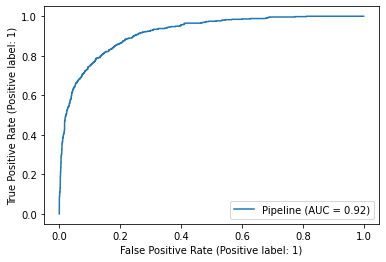

In [ ]:
from sklearn import metrics
import matplotlib.pyplot as plt

#calculate AUC of model
auc = metrics.roc_auc_score(Y_test.astype('int'), y_pred.astype('int'))

#print AUC score
print(auc)

metrics.plot_roc_curve(text_clf, X_test['text'], Y_test.astype('int')) 

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


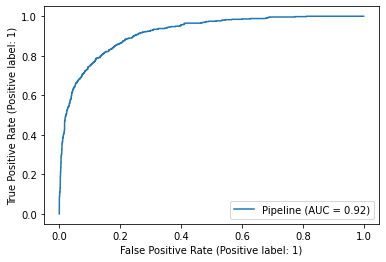

In [ ]:
metrics.plot_roc_curve(text_clf, X_test['text'], Y_test.astype('int'))

In [ ]:
linear_svc = svm.LinearSVC(verbose=0)
linear_svc = linear_svc.fit(X_train2, y_train)

predictions4 = linear_svc.predict(X_test2) 
print("Accuracy: ", accuracy_score(y_test, predictions4))

In [ ]:
matrix_count_log_5 = confusion_matrix(ytest, linear_svc.predict(X_test2))
sns.heatmap(matrix_count_log_5, annot=True, fmt="d")
plt.title('Confusion Matrix of LinearSVC Classifier')
plt.xlabel('Predicted')
plt.ylabel('True')
print(classification_report(ytest, linear_svc.predict(X_test2)))